# 0. Imports

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from warnings import filterwarnings
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.cluster import SpectralClustering, KMeans
pd.set_option('display.float_format', '{:.4f}'.format)
filterwarnings(action='ignore')

In [2]:
def plot_variable_vs_logodds(df, variables, target):
    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Plotando
        plt.figure(figsize=(8, 6))
        plt.plot(X, y, marker='o')
        plt.xlabel(variable)
        plt.ylabel('Log(Odds)')
        plt.title(f'{variable} vs Log(Odds) of {target}\nR^2 = {r2:.2f}')
        plt.grid(True)
        plt.show()

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)



# Função para plotar o R² (linearidade) com a LogOdds
def calculate_r2_for_logodds(df, variables, target, threshold):
    results = []

    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Decidindo sobre a engenharia de recursos com base no valor de R^2 e no threshold fornecido
        feat_eng = "Usar como contínua" if r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'R^2': r2,
            'Feat Eng': feat_eng
        })

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

    return pd.DataFrame(results)


# Transformações para as variáveis de baixo R²
def calculate_r2_for_logodds_and_transformations(df, variables, target, threshold):
    results = []

    transformations = {
        'AbsLog': lambda x: np.log(np.abs(x) + 1),  # Adicionamos 1 para evitar log(0)
        'Quadratic': lambda x: x**2
    }

    for variable in variables:
        best_transform_r2 = -np.inf
        best_transform_name = 'None'
        best_transform_function = None

        for transform_name, transform_function in transformations.items():
            transformed_var = transform_function(df[variable])

            # Verificando o número de valores únicos
            unique_vals = transformed_var.nunique()
            if unique_vals == 1:
                continue

            n_bins = min(10, unique_vals)

            # Criando bins para a variável transformada
            df['bin'] = pd.cut(transformed_var, bins=n_bins, labels=False, duplicates='drop')

            # Calculando a proporção de eventos positivos para cada bin
            mean_target = df.groupby('bin')[target].mean()

            # Calculando o log(odds) e tratando valores infinitos
            log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

            # Calculando R^2
            X = df.groupby('bin')[transformed_var.name].mean()[log_odds.index].values.reshape(-1, 1)
            y = log_odds.values
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)

            # Se essa transformação for a melhor até agora, atualize as melhores variáveis
            if r2 > best_transform_r2:
                best_transform_r2 = r2
                best_transform_name = transform_name
                best_transform_function = transform_function

            # Removendo a coluna bin
            df.drop('bin', axis=1, inplace=True)

        feat_eng = "Usar como contínua" if best_transform_r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'Best Transformation': best_transform_name,
            'R^2 of Transformation': best_transform_r2,
            'Feat Eng': feat_eng,
            'Transformation Equation': f'{best_transform_name}({variable})'
        })

    return pd.DataFrame(results)


# Função que aplica as melhores transformações
def apply_best_transformations(results_df, original_df, drop_original=False):
    transformed_df = original_df.copy()

    transformations = {
        'LogAbs': lambda x: np.log(np.abs(x) + 1),
        'Quadratic': lambda x: x**2
    }

    variables_transformed = []

    for index, row in results_df.iterrows():
        variable = row['Variable']
        best_transform_name = row['Best Transformation']
        feat_eng = row['Feat Eng']

        # Aplica a transformação apenas se Feat Eng estiver marcada como "Categorizar"
        if feat_eng == 'Usar como contínua' and best_transform_name in transformations:
            transform_function = transformations[best_transform_name]
            transformed_var = transform_function(original_df[variable])
            transformed_df[f'TFE_{variable}'] = transformed_var
            variables_transformed.append(variable)

    # Descarta as variáveis originais se drop_original for True
    if drop_original:
        transformed_df.drop(variables_transformed, axis=1, inplace=True)

    return transformed_df



# Função para checar se existe ordenação entre categorias
def analyze_variable(dataframe, variable, target):

    # Se a variável for numérica, arredonda para 4 casas decimais
    if pd.api.types.is_numeric_dtype(dataframe[variable]):
        dataframe[variable] = dataframe[variable].round(4)
        dataframe[variable] = dataframe[variable].astype(str)

    # Calcula a taxa de evento e o volume para cada categoria da variável
    result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
    result.columns = [variable, 'Taxa_de_Evento', 'Volume']

    # Ordena o resultado pela Taxa de Evento em ordem decrescente
    result = result.sort_values(by='Taxa_de_Evento', ascending=False)

    # Plota o gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Y esquerdo: Volume
    bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Volume', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Eixo Y direito: Taxa de Evento
    ax2 = ax1.twinx()
    lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
    ax2.set_ylabel('Taxa de Evento (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
    plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
    labels = [plot.get_label() for plot in plots]
    plt.legend(plots, labels, loc='upper left')

    plt.title(f'Volume e Taxa de Evento por {variable}')
    plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
    plt.tight_layout()
    plt.show()

    return result

# Função de Categorização com Decision Tree
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
    import numpy as np
    # Preparar os dados
    X = dataframe[[numeric_var]]
    y = dataframe[target]

    # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
    tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
    tree.fit(X, y)

    # Predizer a categoria (folha) para cada entrada no DataFrame
    leaf_ids = tree.apply(X)

    # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
    temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

    result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
    result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

    # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
    result = result.sort_values(by='Lower_Bound')
    for i in range(1, len(result)):
        result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

    # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
    result.iloc[0, 3] = -np.inf
    result.iloc[-1, 4] = np.inf

    return result



# Função de Categorização com Decision Tree
def apply_tree_bins(data, transformation_df, numeric_var):

    result.Upper_Bound = result.Upper_Bound.astype('float')
    result.Lower_Bound = result.Lower_Bound.astype('float')

    import numpy as np
    df_copy = data.copy()

    # Obtenha os limites superiores e ordene-os
    upper_bounds = transformation_df['Upper_Bound'].sort_values().values

    # Use numpy.digitize para determinar a qual bin cada valor pertence
    df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].astype(float), upper_bounds)
    df_copy.drop(axis=1,columns=[numeric_var],inplace=True)

    return df_copy


# Função para aplicar a Reg. Log

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard


# Função para Gerar as Métricas de Modelo e Ordenação dos Decis

def calculate_metrics(train_df, test_df, score_column, score_0, target_column,bins=10):
    def compute_metrics(df, score_column, score_0, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_0], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_0, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_0, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, score_0, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, score_0, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test


def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

# 1. Carregando e Juntando as Bases

In [3]:
tbl_funcionarios = pd.read_csv('./DATASETS/tb_funcionarios.csv')
tbl_survey_funcionarios = pd.read_csv('./DATASETS/tb_pesquisa_funcionarios.csv')
tbl_survey_gestores = pd.read_csv('./DATASETS/tb_pesquisa_gestores.csv')

In [4]:
tbl_funcionarios.shape, tbl_survey_funcionarios.shape, tbl_survey_gestores.shape

((4410, 24), (4410, 4), (4410, 3))

In [5]:
# Tabela final precisa ter 4410 Linhas e 24 + 4 + 3 - 2 = 29 Colunas
abt = (
    tbl_funcionarios.merge(
        right= tbl_survey_funcionarios,
        on= 'IDDoEmpregado',
        how= 'left'
    ).merge(
        right= tbl_survey_gestores,
        on= 'IDDoEmpregado',
        how= 'left'
    )
)
abt.shape

(4410, 29)

In [6]:
abt['TARGET'] = abt['Rotatividade'].apply(lambda x: 1 if x == 'Sim' else 0)

# 2. EDA

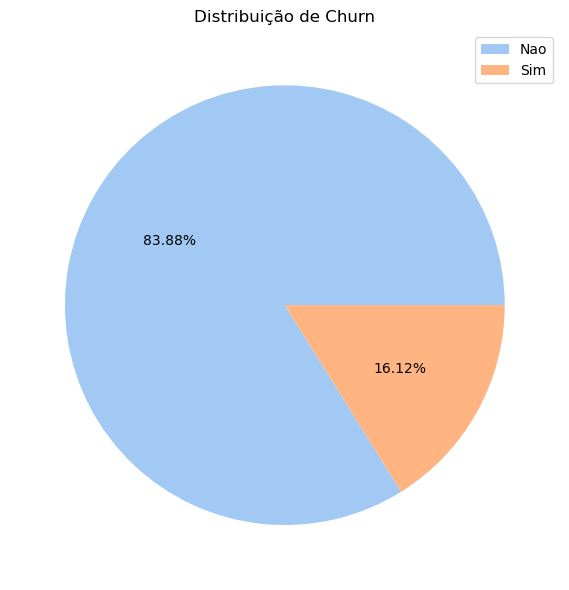

In [7]:
plt.figure(figsize=(12, 6))
churn_counts = abt['Rotatividade'].value_counts()
churn_counts.plot(kind='pie', autopct='%1.2f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=churn_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Distribuição de Churn')

plt.tight_layout() 

plt.show()

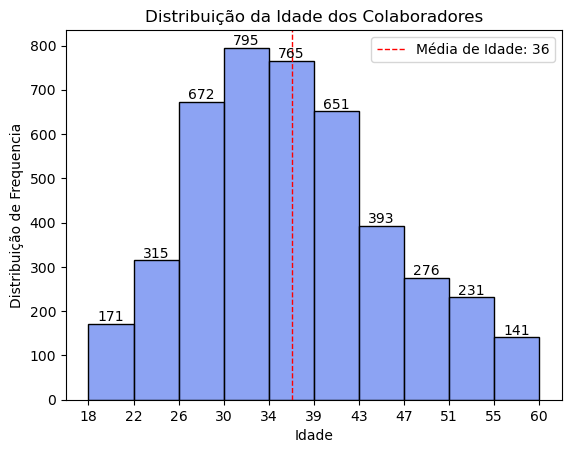

In [8]:
n_bins = 10

ax = sns.histplot(
    data= abt,
    x= 'Idade',
    bins= n_bins,
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor = 'black'
)

intervals = np.linspace(abt['Idade'].min(), abt['Idade'].max(), n_bins+1)

plt.xticks(intervals, labels=intervals.astype(int))

plt.xlabel('Idade')
plt.ylabel('Distribuição de Frequencia')
plt.title('Distribuição da Idade dos Colaboradores')

plt.axvline(x = abt['Idade'].mean(), color = 'red', linestyle= '--', linewidth= 1, label= 'Média de Idade: {}'.format(int(abt['Idade'].mean())))

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend()
plt.show()

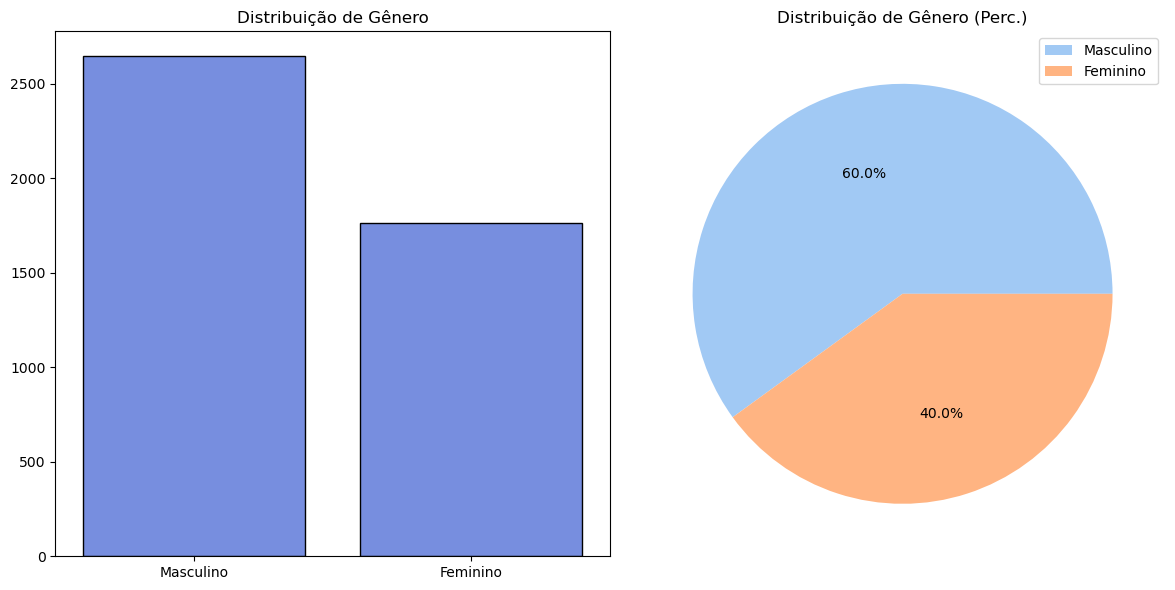

In [9]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)  # (linhas, colunas, índice)
sns.barplot(
    data=abt,
    x=abt['Genero'].value_counts().index.tolist(),
    y=abt['Genero'].value_counts().values.tolist(),
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)
plt.title('Distribuição de Gênero')

# Gráfico de pizza
plt.subplot(1, 2, 2)  # (linhas, colunas, índice)
gender_counts = abt['Genero'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), labels=None)
plt.legend(labels=gender_counts.index, loc="upper right")
plt.ylabel('')
plt.title('Distribuição de Gênero (Perc.)')

plt.tight_layout() 

plt.show()

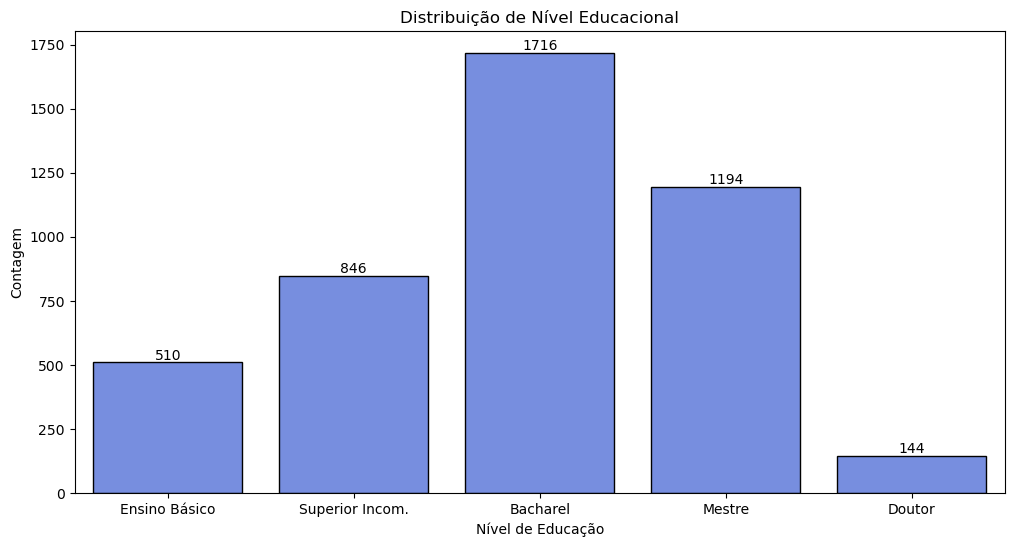

In [10]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
ax = sns.barplot(
    data=abt,
    x=abt['Educacao'].value_counts().index.tolist(),
    y=abt['Educacao'].value_counts().values.tolist(),
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

plt.xticks(ticks=range(5), labels=['Ensino Básico', 'Superior Incom.', 'Bacharel', 'Mestre', 'Doutor'])
plt.title('Distribuição de Nível Educacional')
plt.xlabel('Nível de Educação')
plt.ylabel('Contagem')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

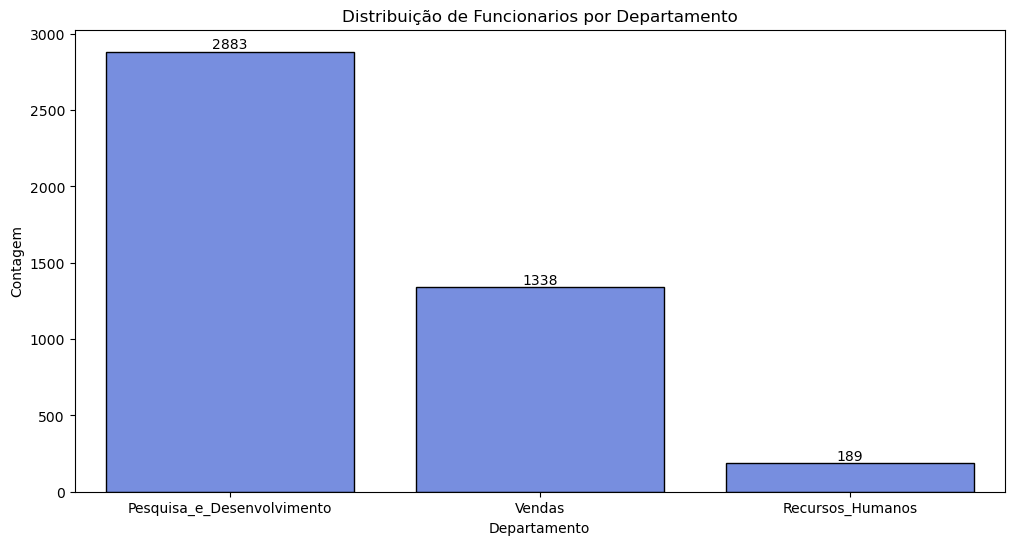

In [11]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
ax = sns.barplot(
    data=abt,
    x=abt['Departamento'].value_counts().index.tolist(),
    y=abt['Departamento'].value_counts().values.tolist(),
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

plt.title('Distribuição de Funcionarios por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Contagem')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

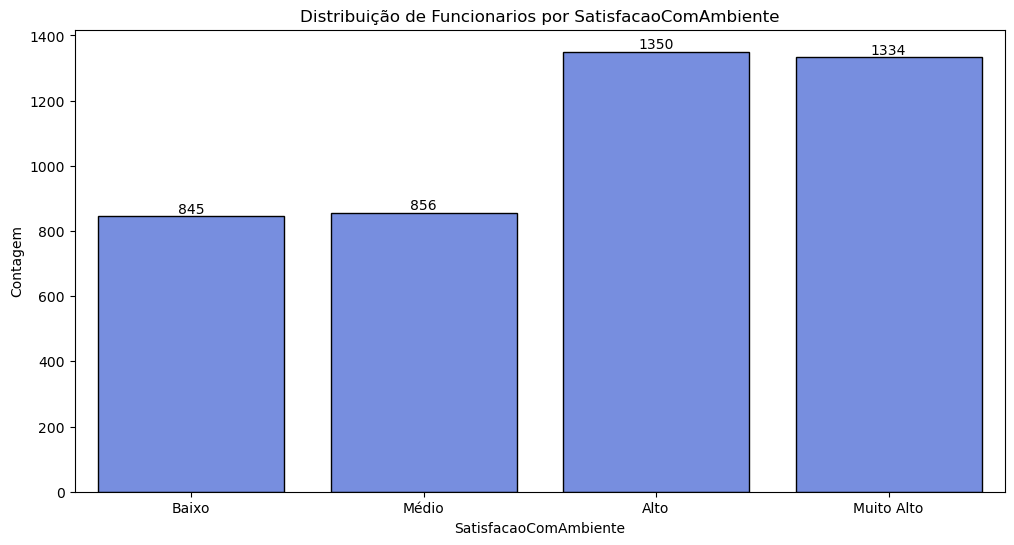

In [12]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
ax = sns.barplot(
    data=abt,
    x=abt['SatisfacaoComAmbiente'].value_counts().index.tolist(),
    y=abt['SatisfacaoComAmbiente'].value_counts().values.tolist(),
    color=(102/255, 132/255, 240/255, 0.64), 
    edgecolor='black'
)

plt.title('Distribuição de Funcionarios por SatisfacaoComAmbiente')
plt.xlabel('SatisfacaoComAmbiente')
plt.xticks(ticks=range(4), labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])
plt.ylabel('Contagem')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Nesta etapa, passamos por algumas variáveis que nos explicam um pouco sobre o público que estamos lidando. Observamos que:

* Temos uma alta taxa de Churn (`16.12%`)

* Publico masculino predominante (`60%`)

* Os colaboradores, em sua maioria, possuem Ensino Superior Completo ou Mestrado. Devido as exigencias do mercado, normalmente esse público possui mais oportunidades em comparação com os que não possuem educação de niveis superiores.

* Pesquisa e Desenvolvimento é o departamento com maior volume de funcionários.

* A satisfação dos colaboradores em relação ao ambiente de trabalho, embora predominantemente boa, apresenta indices altos de satisfação média/baixa.

* Os colaboradores possuem idade majoritariamente entre 26 e 43 anos.

A partir daqui vou checar como a `taxa de rotatividade` está presente no público.

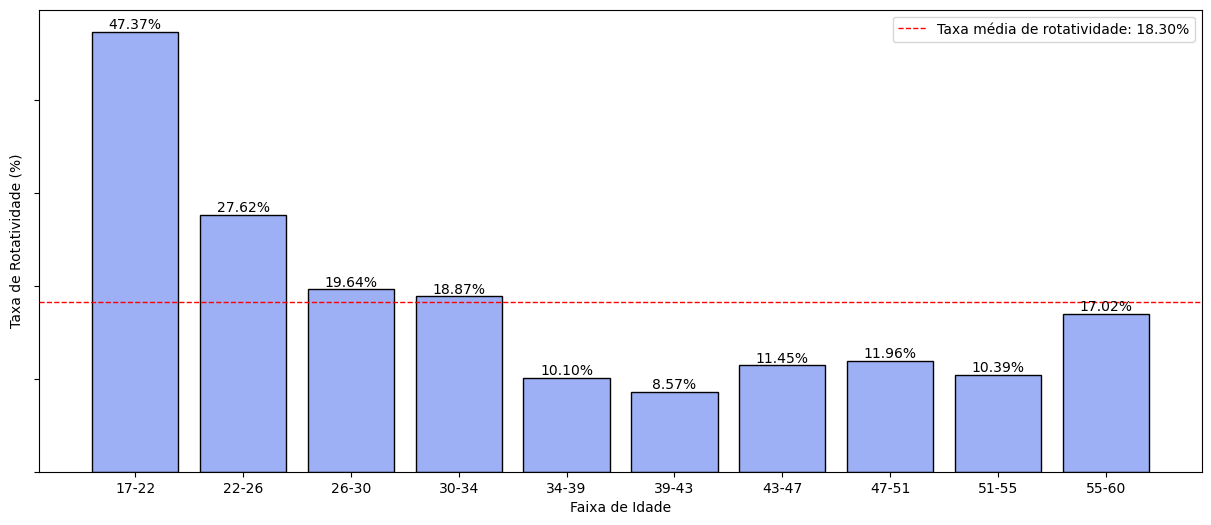

In [13]:
# Categorizando em 10 faixas
bins = pd.cut(
    x=abt['Idade'],
    bins=10
)

# Calculando a taxa de rotatividade para cada faixa de idade
tx_churn_by_age = (abt.groupby(bins)['Rotatividade'].apply(lambda x: (x == 'Sim').mean()) * 100).round(2)

# Plotando o gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(range(len(tx_churn_by_age)), tx_churn_by_age, color=(102/255, 132/255, 240/255, 0.64), edgecolor='black')


for i, taxa in enumerate(tx_churn_by_age):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10)

plt.axhline(tx_churn_by_age.mean(), color='red', linestyle='dashed', linewidth=1, label='Taxa média de rotatividade: {:.2f}%'.format(tx_churn_by_age.mean()))

plt.xticks(range(tx_churn_by_age.count()), ['{}-{}'.format(int(inf),int(sup)) for inf,sup in zip(pd.IntervalIndex(tx_churn_by_age.index).left, pd.IntervalIndex(tx_churn_by_age.index).right)])

# Adicionando rótulos aos eixos
plt.xlabel('Faixa de Idade')
plt.ylabel('Taxa de Rotatividade (%)')

plt.gca().axes.yaxis.set_ticklabels([])

plt.legend()

# Exibindo o gráfico
plt.show()

* A faixa com colaboradores entre `17` e `22` anos possui a maior taxa de rotatividade: alarmantes 47%! No entando, esta também é a segunda faixa de idade que possui a menor quantidade de colaboradores. 

* Uma interpretação semelhante serve para a faixa entre `22` e `26` anos: É a segunda com maior rotatividade (27%), porém e também está entre as menores em quantidade de colaboradores.

* Mais à frente, entre os `26` e `34` anos, temos uma alta taxa de rotatividade, porém aqui é onde há a maior concentração de colaboradores. 

* Após a faixa citada acima, a taxa de rotatividade permanece em um valor relativamente alto, porém já bem abaixo da média, crescendo apenas na última faixa de idade (entre `55` e `60` anos).

Com essas informações, podemos inferir que:

1. A empresa possui dificuldade em reter novos talentos: Um público jovem possui mais facilidade de se movimentar pelo mercado, o que pode indicar uma falta de incentivo aos jovens a permanecerem à longo prazo, como oportunidades de crescimento ou melhores beneficios. 

2. Uma alta taxa de rotatividade na última faixa de idade pode ser considerada natural, devido à aposentadoria.

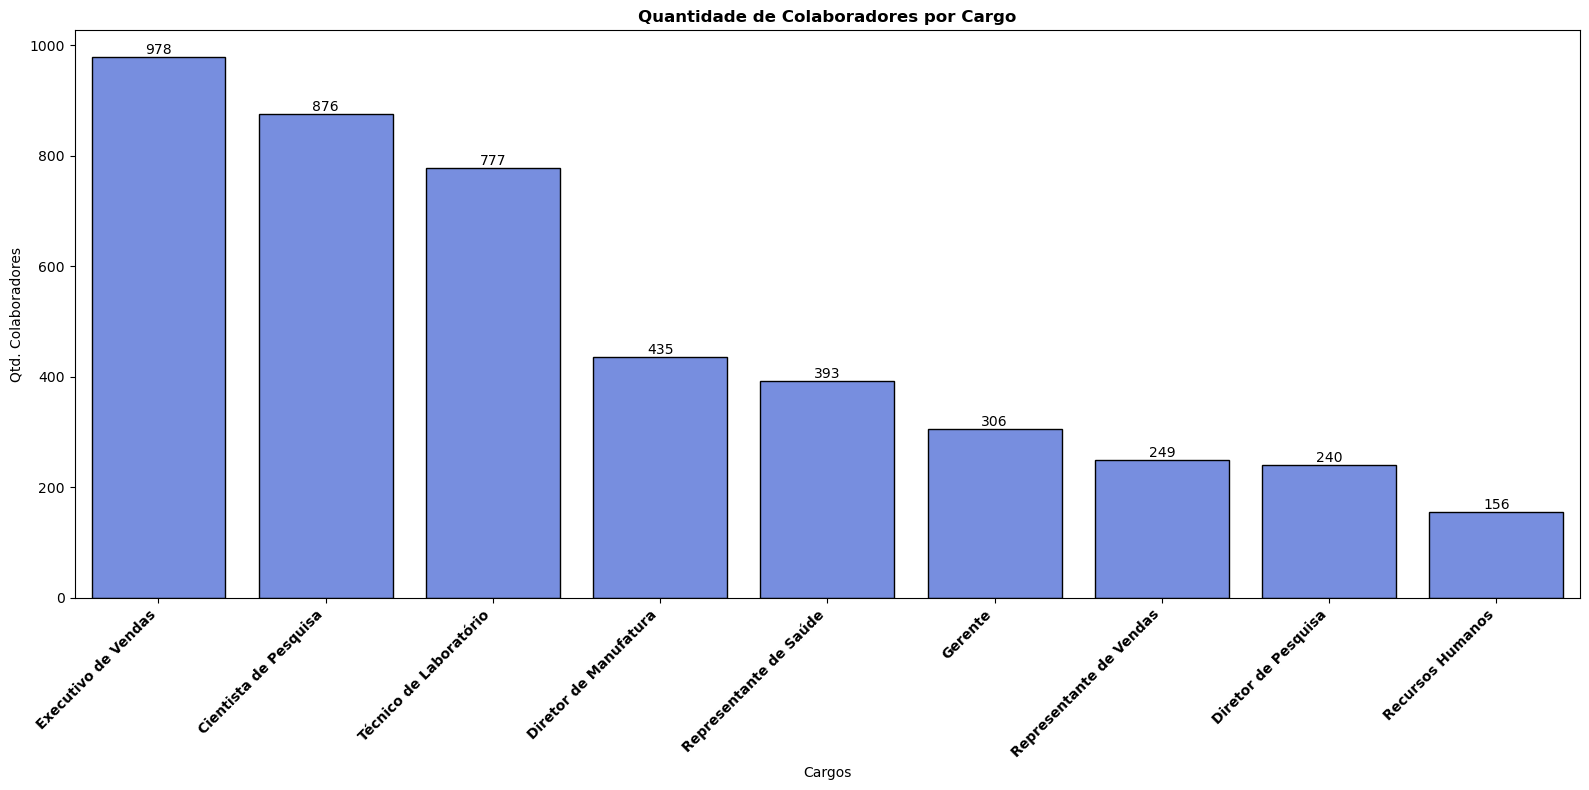

In [14]:
plt.figure(figsize=(16,8))

ax = sns.countplot(
    data = abt,
    x = 'Funcao',
    order = abt['Funcao'].value_counts().sort_values(ascending= False).index,
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

plt.title('Quantidade de Colaboradores por Cargo', weight= 'bold')
plt.ylabel('Qtd. Colaboradores')
plt.xlabel('Cargos')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.xticks(rotation= 45, ha= 'right', weight= 'bold')
plt.tight_layout()
plt.show()

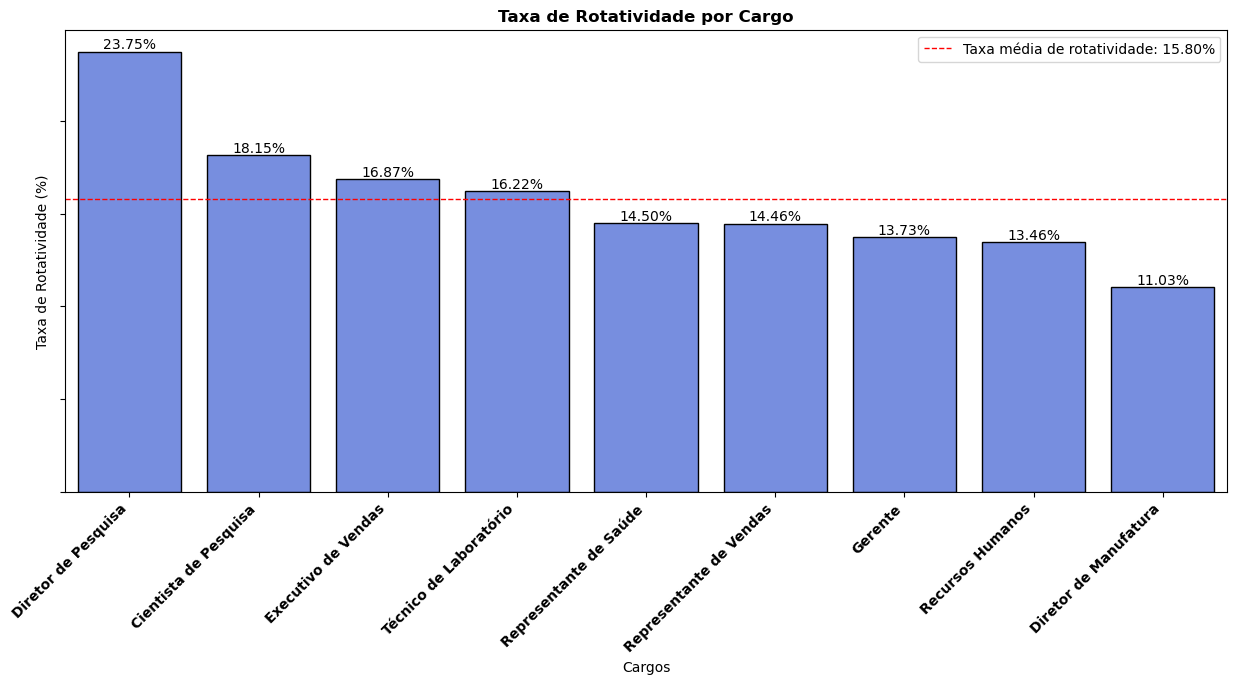

In [15]:
# Calculando a taxa de rotatividade para cargo
tx_churn_by_job = (abt.groupby(['Funcao'])['Rotatividade'].apply(lambda x: (x == "Sim").mean())*100).round(2).sort_values(ascending= False)

# Plotando o gráfico de barras
plt.figure(figsize=(15, 6))
sns.barplot(
    x = tx_churn_by_job.index,
    y = tx_churn_by_job.values,
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

for i, taxa in enumerate(tx_churn_by_job):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10)

plt.axhline(tx_churn_by_job.mean(), color='red', linestyle='dashed', linewidth=1, label='Taxa média de rotatividade: {:.2f}%'.format(tx_churn_by_job.mean()))

# Adicionando rótulos aos eixos
plt.title('Taxa de Rotatividade por Cargo', weight= 'bold')
plt.xlabel('Cargos')
plt.ylabel('Taxa de Rotatividade (%)')
plt.xticks(rotation= 45, ha= 'right', weight= 'bold')
plt.gca().axes.yaxis.set_ticklabels([]) # Remove os yticks

plt.legend() # Exibe a Legenda

plt.show()

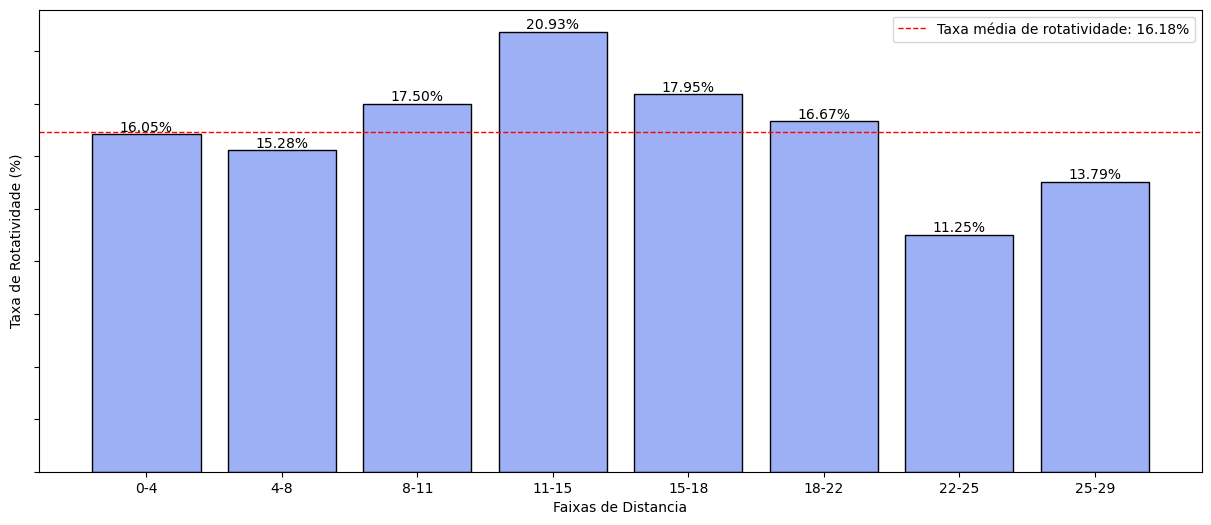

In [16]:
# Categorizando em 10 faixas
bins = pd.cut(
    x=abt['DistanciaDeCasa'],
    bins=8
)

# Calculando a taxa de rotatividade para cada faixa de idade
tx_churn_by_dist = (abt.groupby(bins)['Rotatividade'].apply(lambda x: (x == 'Sim').mean()) * 100).round(2)

# Ordenando as faixas
tx_churn_by_dist = tx_churn_by_dist.sort_index(ascending= True)

# Plotando o gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(range(len(tx_churn_by_dist)), tx_churn_by_dist, color=(102/255, 132/255, 240/255, 0.64), edgecolor='black')


for i, taxa in enumerate(tx_churn_by_dist):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10)

plt.axhline(tx_churn_by_dist.mean(), color='red', linestyle='dashed', linewidth=1, label='Taxa média de rotatividade: {:.2f}%'.format(tx_churn_by_dist.mean()))

plt.xticks(range(tx_churn_by_dist.count()), ['{}-{}'.format(int(inf),int(sup)) for inf,sup in zip(pd.IntervalIndex(tx_churn_by_dist.index).left, pd.IntervalIndex(tx_churn_by_dist.index).right)])

# Adicionando rótulos aos eixos
plt.xlabel('Faixas de Distancia')
plt.ylabel('Taxa de Rotatividade (%)')

plt.gca().axes.yaxis.set_ticklabels([])

plt.legend()

# Exibindo o gráfico
plt.show()

`>` A distancia entre o trabalho e a casa do colaborador não parece ter um impacto sistemático na rotatividade. Porém, ao observar os valores de rotatividade nas faixas entre 8km e 18km, vemos uma alta que pode indicar uma região de dificil deslocamento (ida/volta de casa) para o colaborador.

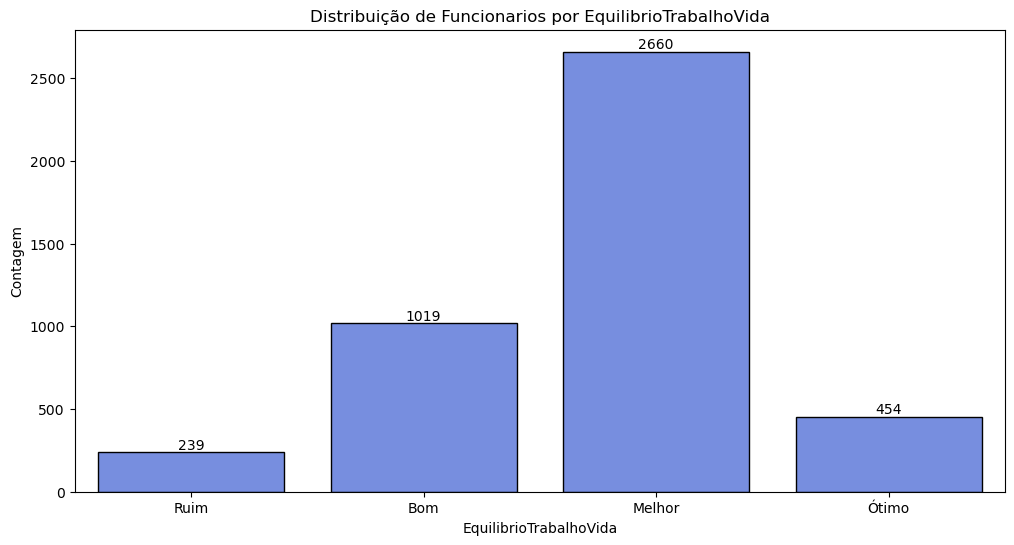

In [17]:
plt.figure(figsize=(12, 6))

# Gráfico de barras
ax = sns.barplot(
    data=abt,
    x=abt['EquilibrioTrabalhoVida'].value_counts().index.tolist(),
    y=abt['EquilibrioTrabalhoVida'].value_counts().values.tolist(),
    color=(102/255, 132/255, 240/255, 0.64), 
    edgecolor='black'
)

plt.title('Distribuição de Funcionarios por EquilibrioTrabalhoVida')
plt.xlabel('EquilibrioTrabalhoVida')
plt.xticks(ticks=range(4), labels=['Ruim', 'Bom', 'Melhor', 'Ótimo'])
plt.ylabel('Contagem')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

* Eq.Trab.Vida -> Tem efeito, recomendação é a empresa investir nesta prática
* SatisfaçãoComAmbiente -> Investir em um ambiente de trabalho mais propício aos funcionários

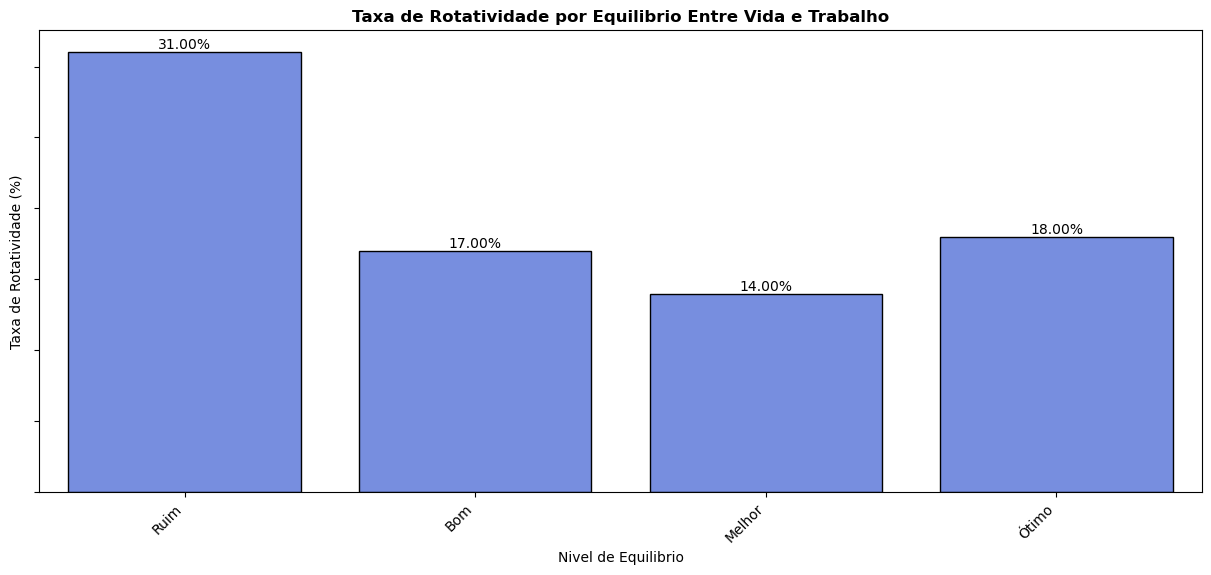

In [18]:
# Calculando a taxa de rotatividade para cargo
tx_churn_by_eq = (abt.groupby(['EquilibrioTrabalhoVida'])['Rotatividade'].apply(lambda x: (x == "Sim").mean()).round(2)*100)

# Plotando o gráfico de barras
plt.figure(figsize=(15, 6))
sns.barplot(
    x = tx_churn_by_eq.index,
    y = tx_churn_by_eq.values,
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

for i, taxa in enumerate(tx_churn_by_eq):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10)

# Adicionando rótulos aos eixos
plt.title('Taxa de Rotatividade por Equilibrio Entre Vida e Trabalho', weight= 'bold')
plt.xlabel('Nivel de Equilibrio')
plt.ylabel('Taxa de Rotatividade (%)')
plt.xticks(ticks=range(4), labels=['Ruim', 'Bom', 'Melhor', 'Ótimo'],rotation= 45, ha= 'right')
plt.gca().axes.yaxis.set_ticklabels([]) # Remove os yticks

plt.show()

`>` Quando olhamos para o equilibrio entre a vida pessoal e o trabalho, fica claro que é um aspecto a ser considerado para melhorar a permanencia dos colaboradores na empresa. Recomenda-se uma pesquisa com os colaboradores para entender melhor o que causa este efeito e como o mesmo pode ser mitigado.

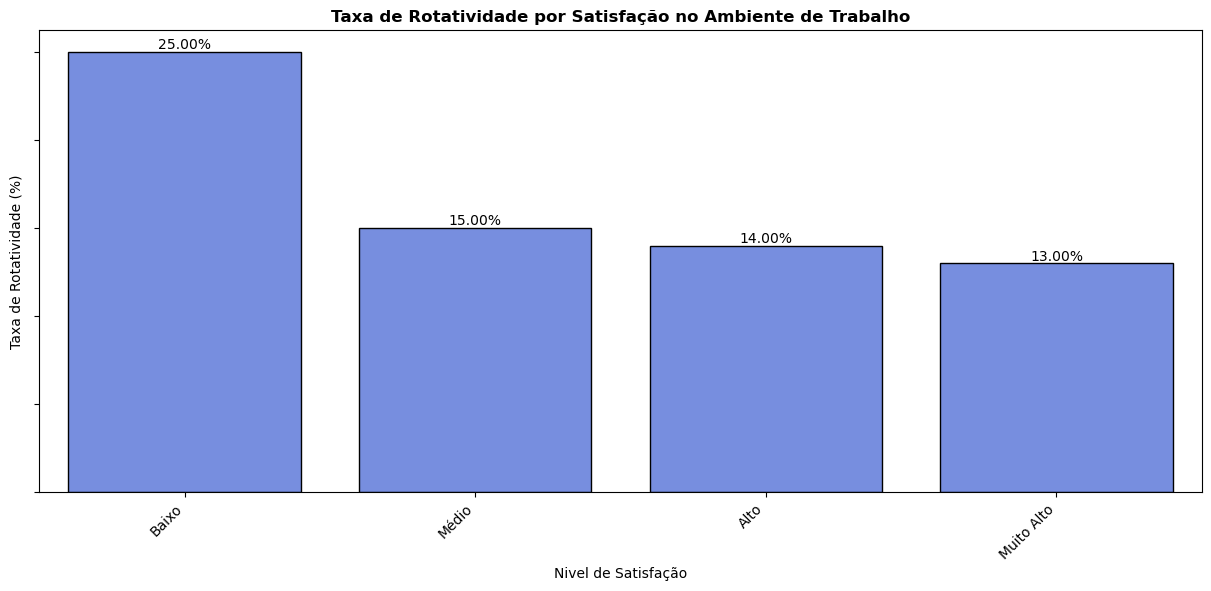

In [19]:
# Calculando a taxa de rotatividade para cargo
tx_churn_by_sats = (abt.groupby(['SatisfacaoComAmbiente'])['Rotatividade'].apply(lambda x: (x == "Sim").mean()).round(2)*100)

# Plotando o gráfico de barras
plt.figure(figsize=(15, 6))
sns.barplot(
    x = tx_churn_by_sats.index,
    y = tx_churn_by_sats.values,
    color=(102/255, 132/255, 240/255, 0.64),
    edgecolor='black'
)

for i, taxa in enumerate(tx_churn_by_sats):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10)

# Adicionando rótulos aos eixos
plt.title('Taxa de Rotatividade por Satisfação no Ambiente de Trabalho', weight= 'bold')
plt.xlabel('Nivel de Satisfação')
plt.ylabel('Taxa de Rotatividade (%)')
plt.xticks(ticks=range(4), labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'],rotation= 45, ha= 'right')
plt.gca().axes.yaxis.set_ticklabels([]) # Remove os yticks

plt.show()

`>` Semelhante ao cenário anterior, a Satisfação com o Ambiente de trabalho mostra-se importante para manter a taxa de rotatividade mais baixa, apresentando uma diferença de 10% na rotatividade entre a classe "Baixo" e "Médio".

# Data Preparation (Clustering)

In [20]:
# X = abt.drop(columns = ['IDDoEmpregado']).copy()
# num_vars = X.select_dtypes(exclude='object')
# cat_vars = X.select_dtypes(include='object')

# # Tratamento das Categóricas
# cat_pipeline = Pipeline([
#     ('imputer' , SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(drop= 'first', ))
# ])

# # Tratamento das Numéricas
# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', RobustScaler())
# ])

# # Definindo o Preprocessador
# preprocessor = ColumnTransformer([
#     ('cat_transformer', cat_pipeline, cat_vars.columns),
#     ('num_transformer', num_pipeline, num_vars.columns)
# ])

# pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# X_transformed = pipeline.fit_transform(X)

# cat_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat_transformer'].named_steps['encoder'].get_feature_names_out(input_features = cat_vars.columns)

# # Criando a nova abt
# abt02 = pd.DataFrame(X_transformed, columns= list(cat_cols) + list(num_vars.columns))

In [21]:
X = abt.drop(columns='IDDoEmpregado')

cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Define numerical pipeline with RobustScaler
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplica o pipeline à base de dados
X_processed = pipeline.fit_transform(X)

# Obtém os nomes das colunas após o one-hot encoding
encoded_cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=cat_attributes.columns)

# Combina os nomes das colunas categóricas codificadas e as colunas numéricas
all_columns = list(encoded_cat_columns) + list(num_attributes.columns)

# Cria um DataFrame com as colunas pré-processadas e seus nomes
abt02 = pd.DataFrame(X_processed, columns=all_columns)

# Feature Selection (PCA)

In [22]:
pca = PCA(n_components= 0.80)
pca.fit(abt02)
abt03 = pca.transform(abt02)
abt03.shape

(4410, 16)

In [23]:
#pd.DataFrame(pca.components_, columns= pca.feature_names_in_, index= ["PC"+str(i) for i in range(1,12)]).abs().mean().sort_values(ascending=False)

* Valor de cada variável em cada componente (cada linha corresponde a um componente)

In [24]:
#pd.DataFrame(pca.explained_variance_ratio_, columns= ['VarianceRatio'])

# Modelagem (Clustering)

Irei aplicar os seguintes algoritmos para *clusterizar* os dados:

1. Expectativa-Maximização (*Gaussian-Mixture*)
2. *Spectral Clustering*

## Definindo K clusters iniciais

* Como o algoritmo de `Expectativa Maximização` depende de uma boa inicialização de número de clusters, vamos comparar o método da ``Silhueta`` e do ``Cotovelo`` utilizando o K-Means para definir um bom número inicial de clusters.

### Método do Cotovelo

* É um método empírico, onde testa-se um conjunto de valores candidatos para `k`, calculando-se a distância média de cada ponto de um cluster em relação ao seu centroide. Escolhemos o valor de `k` onde há uma queda brusca no valor médio da distância.

In [25]:
from yellowbrick.cluster import KElbowVisualizer

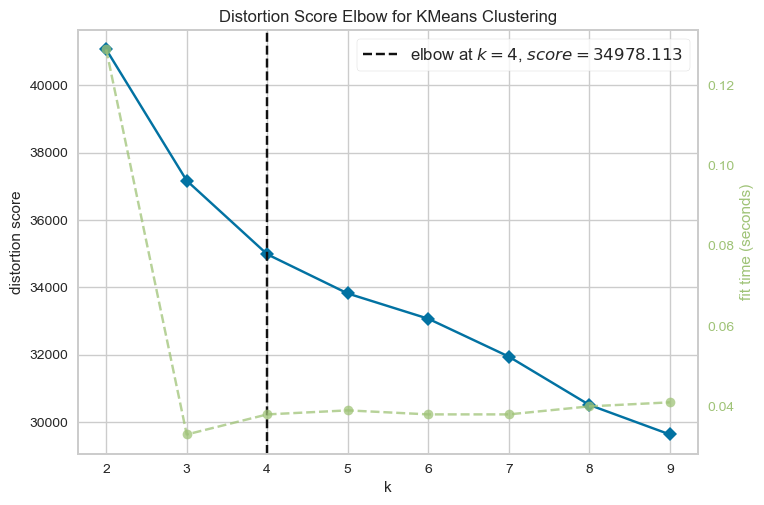

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Elbow Method for K means
# Import ElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True);
visualizer.fit(abt03)
visualizer.show()

### Método da Silhueta

* A silhueta é uma medida de similaridade que quantifica o quanto uma observação é similar ao seu próprio cluster (coesão), comparado com os demais clusters existentes (separação).

* Seu valor é compreendido entre -1 e 1. Quanto maior o valor, mais similar é a observação ao próprio cluster.

* Se a grande maioria das observações possuírem valores altos, significa que temos uma boa configuração de clusters.

Iteração número: 0 - Coeficiente de Silhueta: 0.18708870028450084
Iteração número: 1 - Coeficiente de Silhueta: 0.14477559011732616
Iteração número: 2 - Coeficiente de Silhueta: 0.10712839404534316
Iteração número: 3 - Coeficiente de Silhueta: 0.10290845406039884
Iteração número: 4 - Coeficiente de Silhueta: 0.10074750808752365
Iteração número: 5 - Coeficiente de Silhueta: 0.09872226456112491
Iteração número: 6 - Coeficiente de Silhueta: 0.0989842916599118
Iteração número: 7 - Coeficiente de Silhueta: 0.10263871930194254


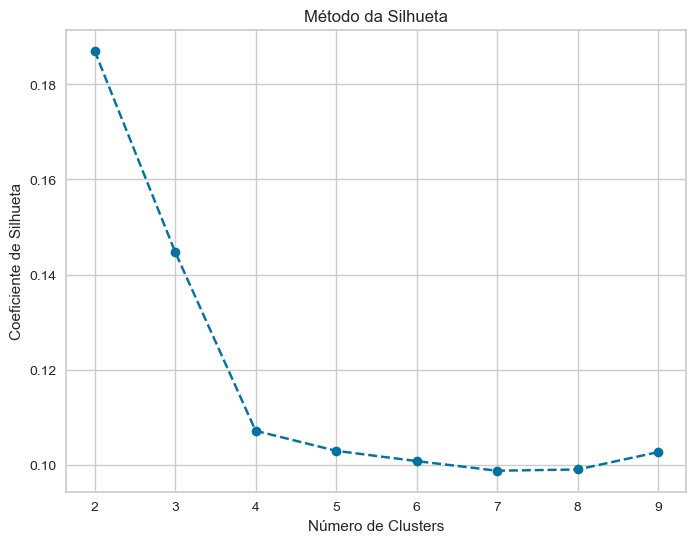

In [27]:
from sklearn.metrics import silhouette_score
# Calcular a pontuação da silhueta para diferentes números de clusters
silhouette_scores = []
i = 0
k_min = 2
k_max = 10

for n_clusters in range(k_min, k_max):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(abt03)
    # gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    # gmm.fit(abt03)
    # cluster_labels = gmm.predict(abt03)

    # spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=15, random_state=42)
    # cluster_labels = spectral_clustering.fit_predict(abt03)
    silhouette_avg = silhouette_score(abt03, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f'Iteração número: {i} - Coeficiente de Silhueta: {silhouette_avg}')
    i += 1

# Plotar o gráfico do método da silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(k_min, k_max), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta')
plt.xticks(range(k_min, k_max))
plt.grid(True)
plt.show()

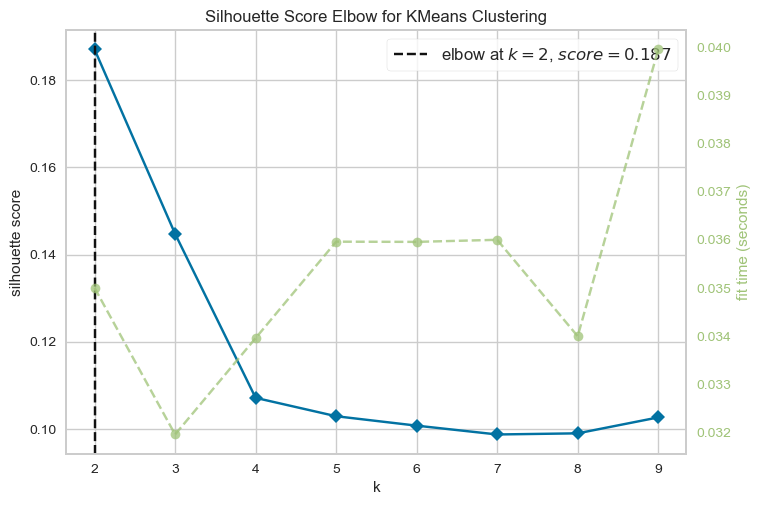

In [28]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True);
visualizer.fit(abt03)
visualizer.show();

## Expectativa-Maximização (Gaussian Mixture)

In [29]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

* Modelo Inicial (Utilizando K = 4, conforme encontrado nos métodos de inicialização)

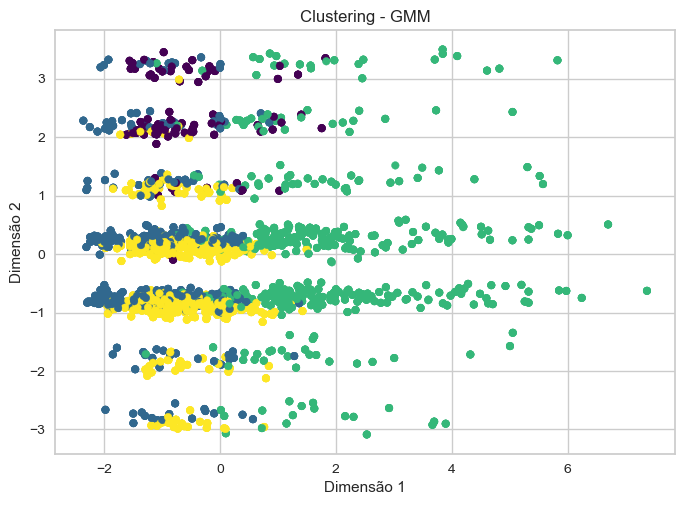

In [30]:
gmm = GaussianMixture(n_components= 4, random_state= 0)

labels_gmm = gmm.fit_predict(abt03)

plt.scatter(abt03[:, 0], abt03[:, 1], c=labels_gmm, cmap='viridis', s=30)
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.title('Clustering - GMM')
plt.show()

* Testando um conjunto de k numero de clusters (Avaliação com BIC)

In [31]:
k_range = list(range(2,11))

covariance = ['spherical', 'tied', 'diag', 'full']

best_bic = float('inf')

best_config = None

scores = []


for cov in covariance:
    for k in k_range:
        gmm = GaussianMixture(
            n_components= k,
            covariance_type= cov,
            random_state= 1
        )

        gmm.fit(abt03)

        curr_score = gmm.bic(abt03)

        scores.append((cov, k, curr_score))

        if curr_score < best_bic:
            best_bic = curr_score
            best_config = (cov, k)

print(f'Melhor Configuração: {best_config}\nMelhor BIC: {best_bic}')  

Melhor Configuração: ('full', 8)
Melhor BIC: 148912.97830001966


## Spectral Clustering

Melhores hiperparâmetros: n_clusters = 9, BIC = -359556.680842943


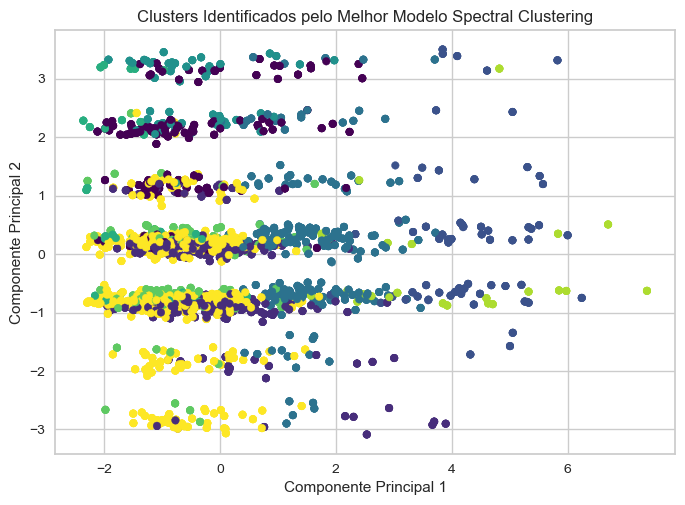

In [32]:
# Função para calcular BIC para Spectral Clustering
def compute_bic(labels, X):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    if n_clusters == 0:
        return np.inf
    
    N = X.shape[0]
    D = X.shape[1]
    
    cluster_means = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
    variances = np.array([X[labels == i].var(axis=0) for i in range(n_clusters)])
    
    log_likelihood = -np.sum([0.5 * np.sum((X[labels == i] - cluster_means[i])**2 / variances[i]) for i in range(n_clusters)])
    log_likelihood -= N * D * np.log(2 * np.pi) / 2
    log_likelihood -= 0.5 * np.sum(np.log(variances)) * (N - n_noise)
    
    n_parameters = n_clusters * (D + 1)
    
    bic = -2 * log_likelihood + n_parameters * np.log(N)
    return bic

# Definir faixas de hiperparâmetros para Spectral Clustering
n_clusters_range = range(2, 10)

# Variáveis para armazenar os melhores hiperparâmetros e o menor BIC
best_n_clusters = None
best_bic = np.inf
best_model = None
best_labels = None

# Iterar sobre todas as combinações de hiperparâmetros
for n_clusters in n_clusters_range:
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
    labels = spectral.fit_predict(abt03)
    
    bic = compute_bic(labels, abt03)
    if bic < best_bic:
        best_bic = bic
        best_n_clusters = n_clusters
        best_model = spectral
        best_labels = labels

# Imprimir os melhores hiperparâmetros
print(f'Melhores hiperparâmetros: n_clusters = {best_n_clusters}, BIC = {best_bic}')

# Plotar os clusters identificados pelo melhor modelo Spectral Clustering
plt.scatter(abt03[:, 0], abt03[:, 1], c=best_labels, cmap='viridis', s=30)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters Identificados pelo Melhor Modelo Spectral Clustering')
plt.show()


## Treinamento do Modelo

* Após o teste dos modelos na seção passada, vamos seguir com o algoritmo de Gaussian Mixture. Dessa forma, irei treinar o modelo novamente, com os melhores hiperparâmetros encontrados, e então alocar cada observação ao seu respectivo cluster.

In [33]:
gmm = GaussianMixture(
    n_components= 7,
    covariance_type= 'full',
    random_state= 1
)

gmm.fit(abt03)

labels = gmm.predict(abt03)

abt['cluster'] = labels

display(np.unique(labels))

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

# Análise dos Clusters

* Agora com as observações devidamente agrupadas, podemos prosseguir para entender melhor cada agrupamento. Vamos começar vendo como ficou a distribuição da quantidade de por cluster.

In [34]:
churn_ratio = abt['TARGET'].mean().round(4)*100
tx_churn_by_cluster = abt.groupby(['cluster']).agg({'TARGET' : 'mean'}).reset_index()
tx_churn_by_cluster['TARGET'] = tx_churn_by_cluster['TARGET']*100

<Figure size 1200x800 with 0 Axes>

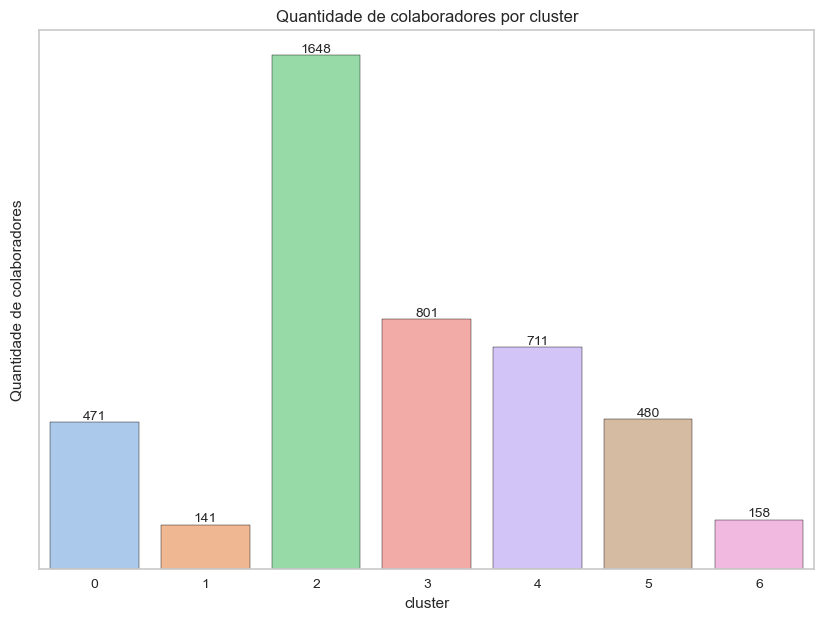

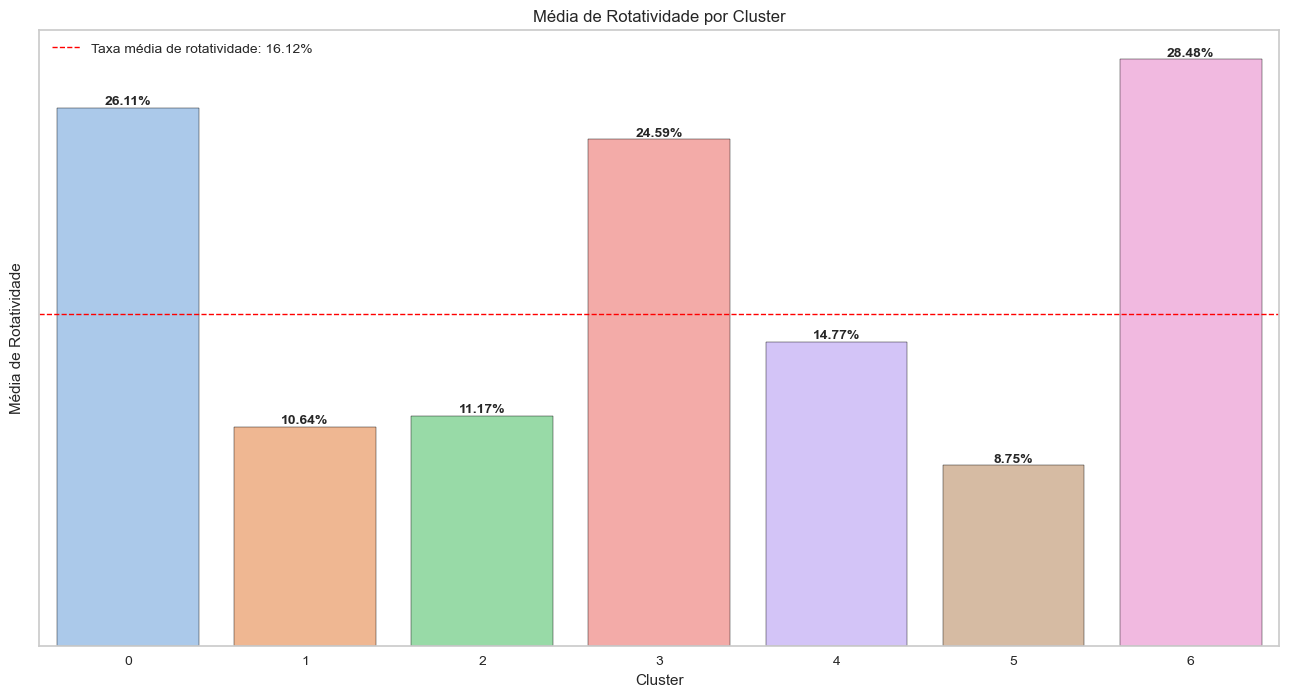

In [35]:
plt.figure(figsize= (12,8))

plt.figure(figsize=(10,7))
fig = sns.countplot(data=abt, x="cluster",palette=sns.color_palette('pastel'), edgecolor='black')

for i in range(len(fig.containers)):
  fig.bar_label(fig.containers[i], fontsize=10)

fig.set_title("Quantidade de colaboradores por cluster")

plt.gca().axes.yaxis.set_ticklabels([])

plt.ylabel('Quantidade de colaboradores')

plt.grid(False)

plt.show()


plt.figure(figsize=(16, 8))
sns.barplot(x="cluster", y="TARGET", data=tx_churn_by_cluster, palette=sns.color_palette('pastel'), edgecolor ='black')
plt.axhline(churn_ratio, color='red', linestyle='dashed', linewidth=1, label='Taxa média de rotatividade: {:.2f}%'.format(churn_ratio))

plt.title("Média de Rotatividade por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Média de Rotatividade")


# Adicionando os valores das taxas de rotatividade nas barras
for i, taxa in enumerate(tx_churn_by_cluster.TARGET.values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa), ha='center', va='bottom', fontsize=10, fontweight= 'bold')

plt.gca().axes.yaxis.set_ticklabels([])

plt.grid(False)

plt.legend()

plt.show()

Podemos observar que:

1. Os clusters `0` e `6` apresentam rotatividade significativamente acima da média (26,11% para o Grupo 0 e 28,48% para o Grupo 6). O que os torna particularmente interessantes, é que enquanto são os dois maiores no quesito rotatividade, estão entre os 3 menos grupos em quantidade de colaboradores. Isso pode indicar que esses clusters capturaram subgrupos dentro do quadro de funcionários que possuem uma alta tendencia a sair da empresa, levantando a necessidade de explorar esses grupos mais a fundo.

2. O grupo `3` tem uma rotatividade bem acima da média, sendo o terceiro maior em taxa de rotatividade, sendo também o segundo maior em quantidade de funcionários. Este cluster tem um impacto significativo na rotatividade geral da empresa devido ao grande número de funcionários e à alta taxa de rotatividade, também levantando a necessidade de ser analisado mais a fundo.

3. Os demais clusters: Estes clusters apresentam rotatividade abaixo da média. O Cluster 2, apesar de ser o maior, possui uma baixa taxa de rotatividade, o que é positivo. Estes clusters parecem estar mais estáveis, e práticas que funcionam bem aqui podem ser analisadas para serem implementadas em outros clusters com alta rotatividade.

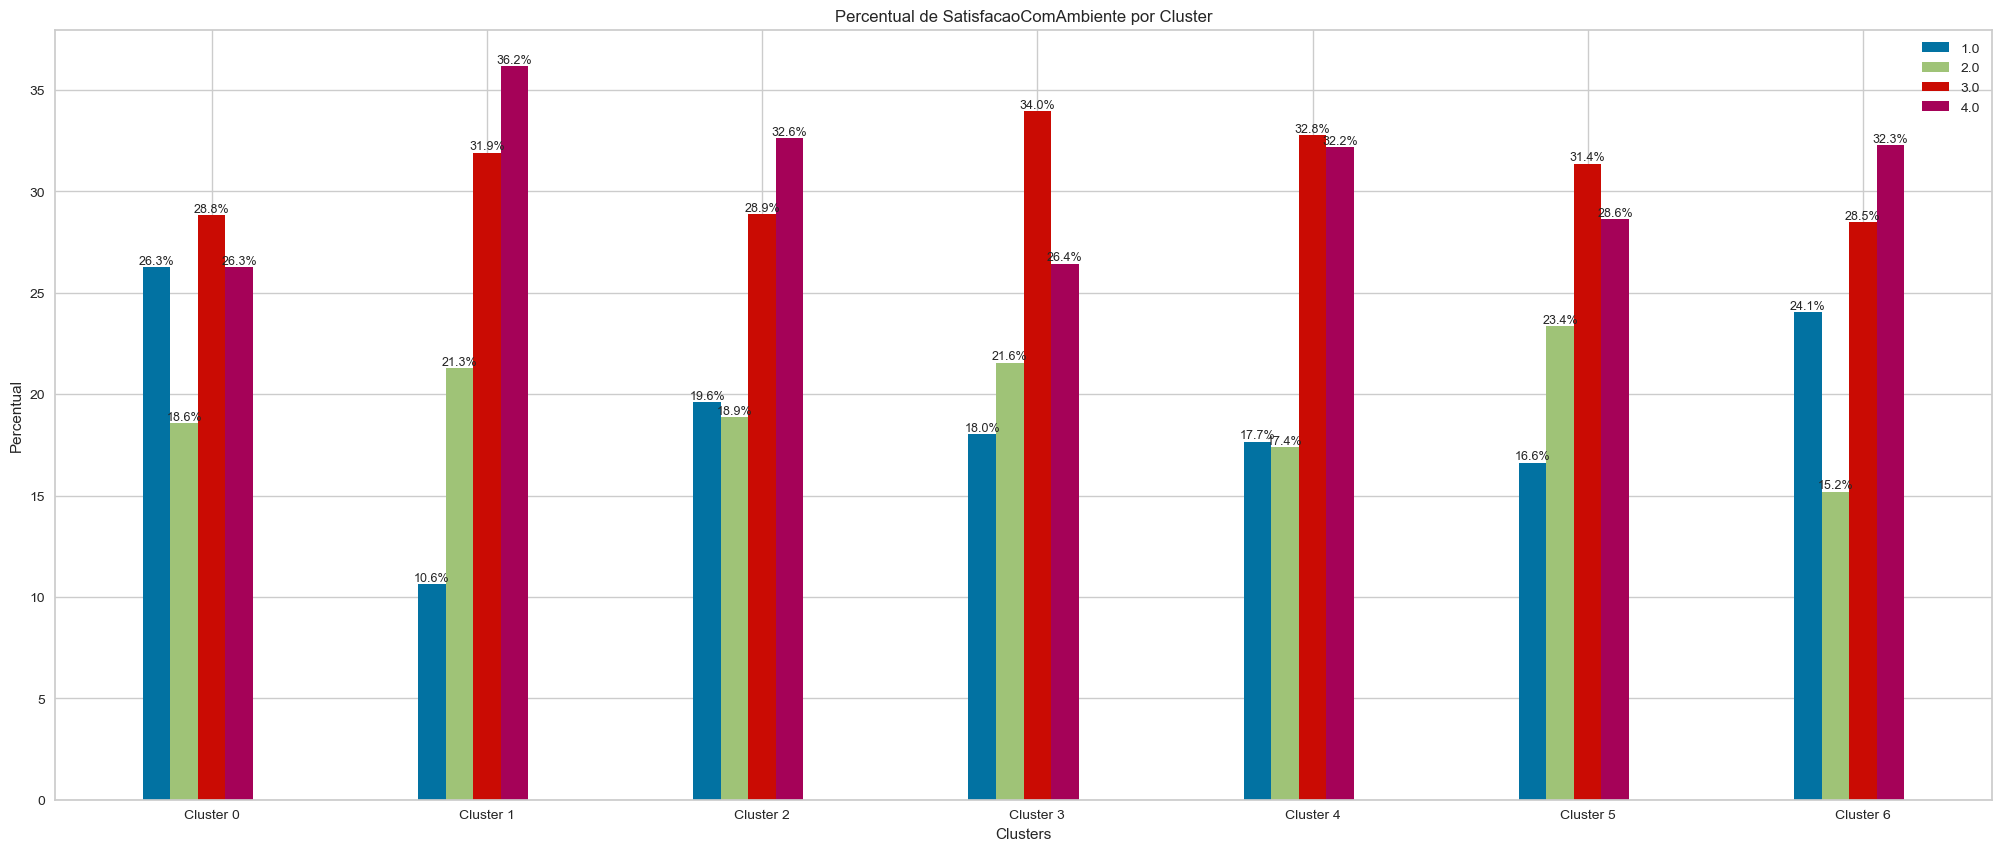

posx and posy should be finite values
posx and posy should be finite values


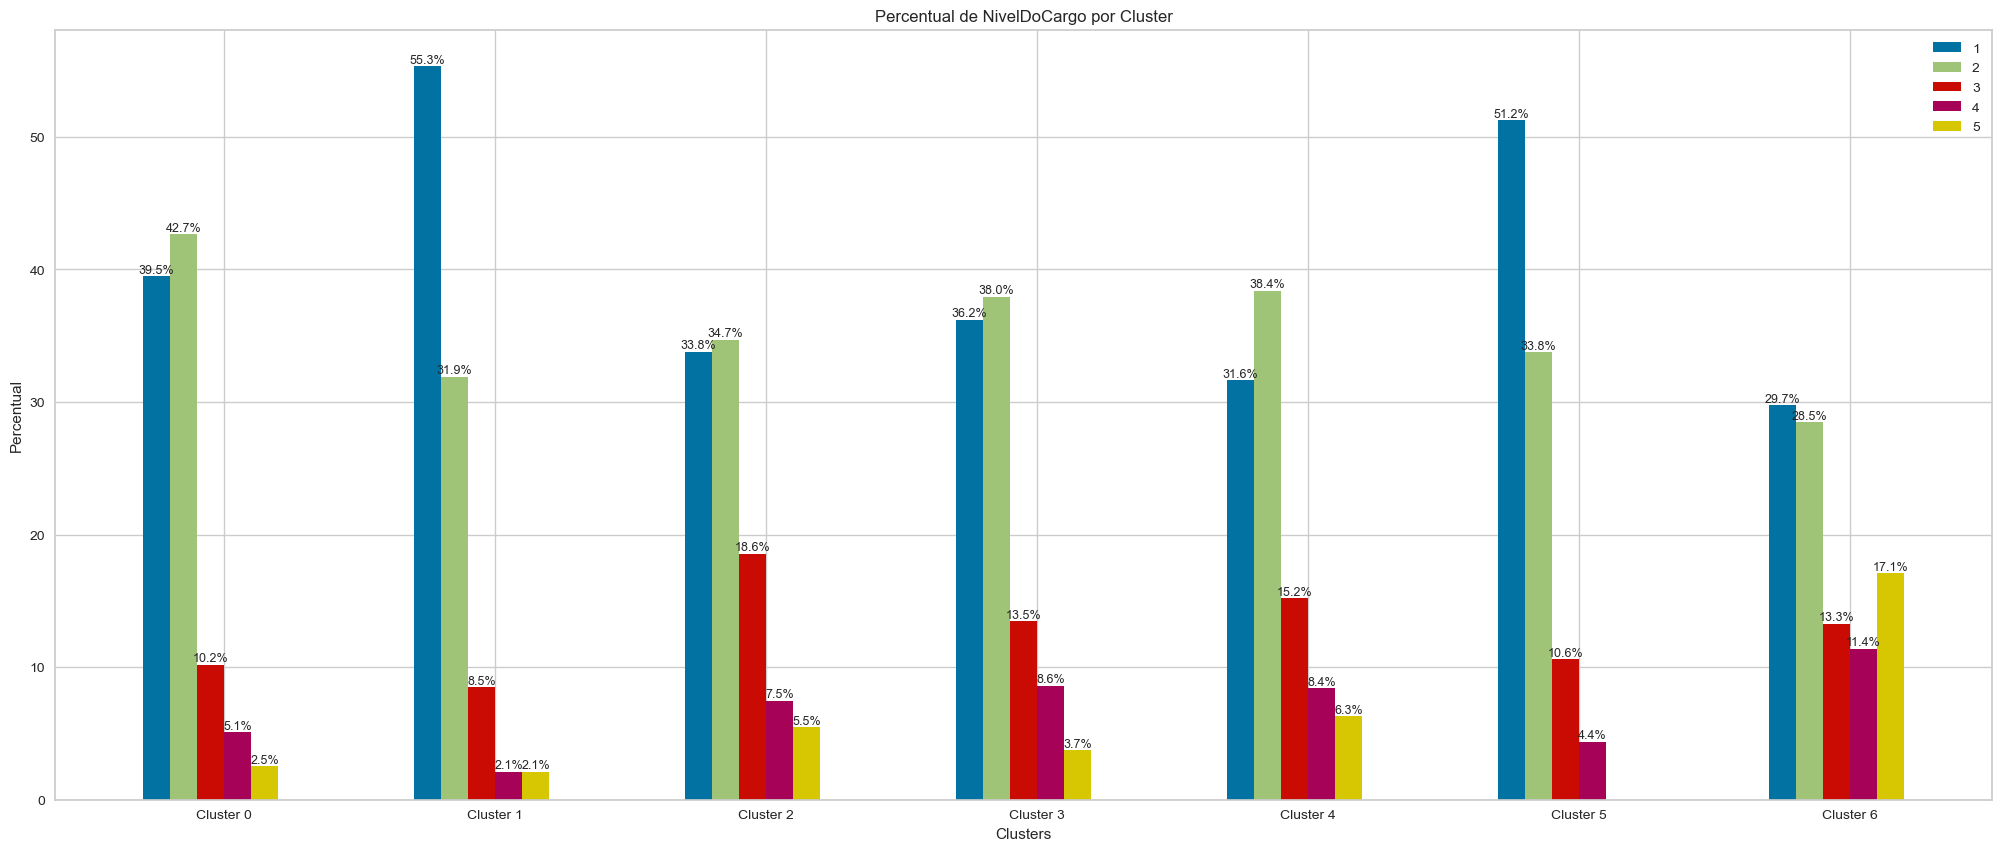

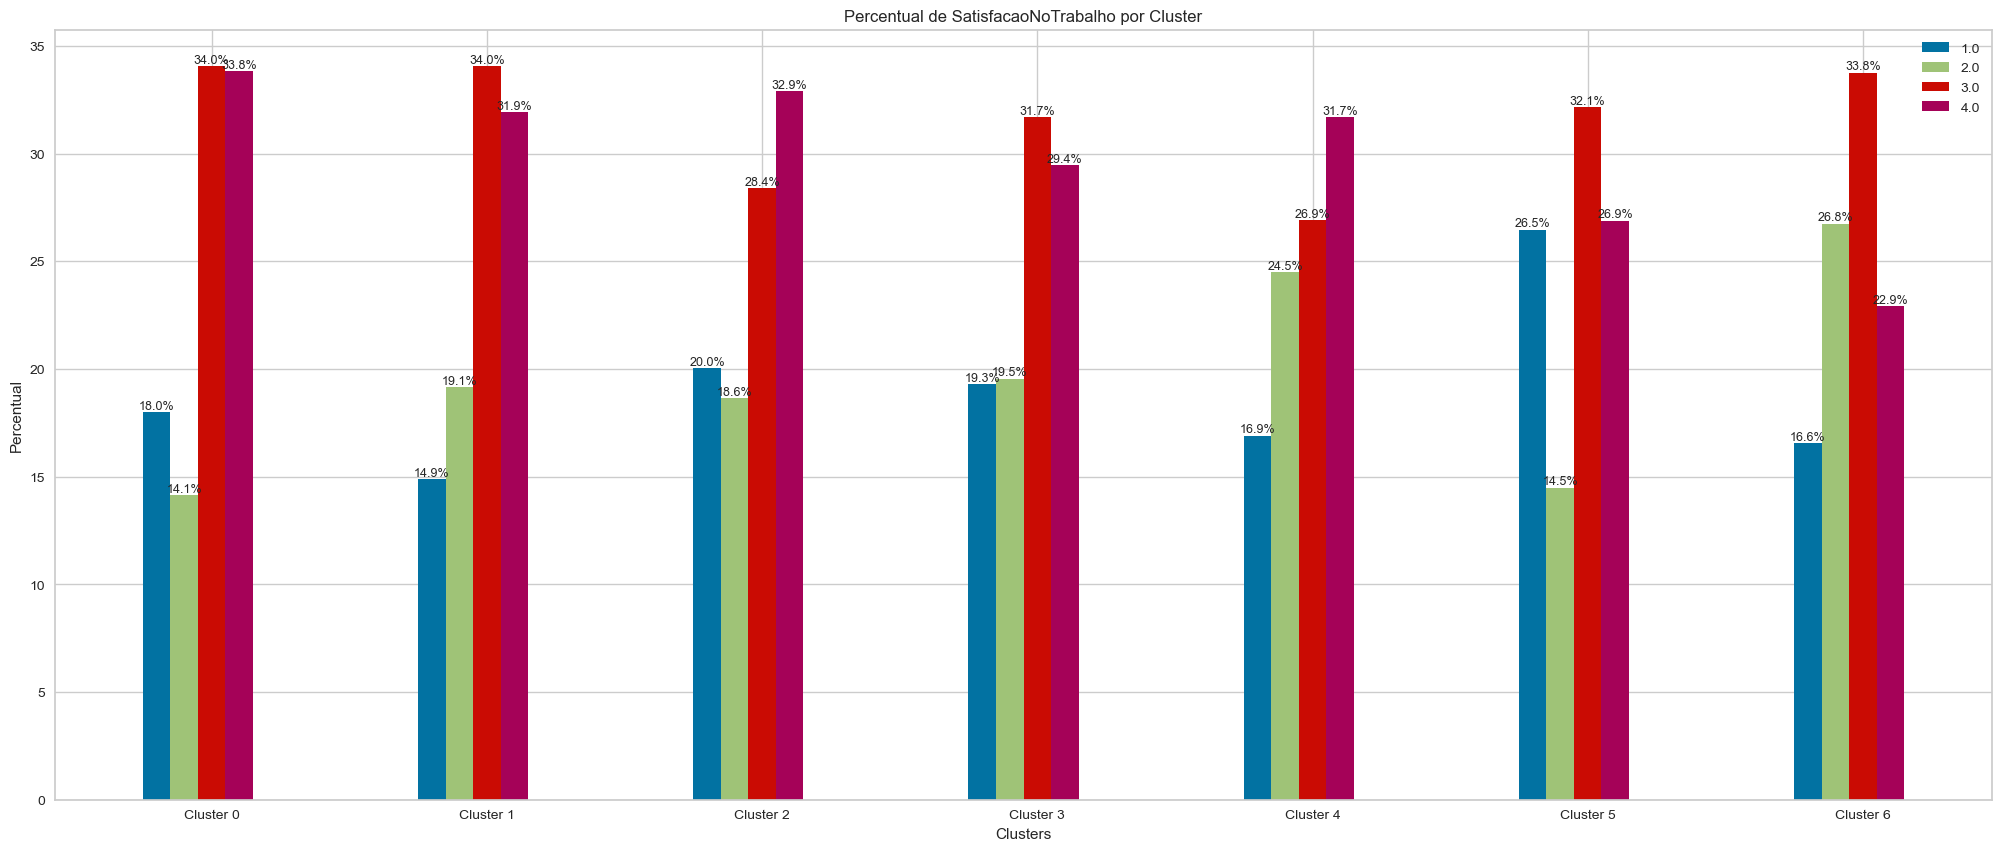

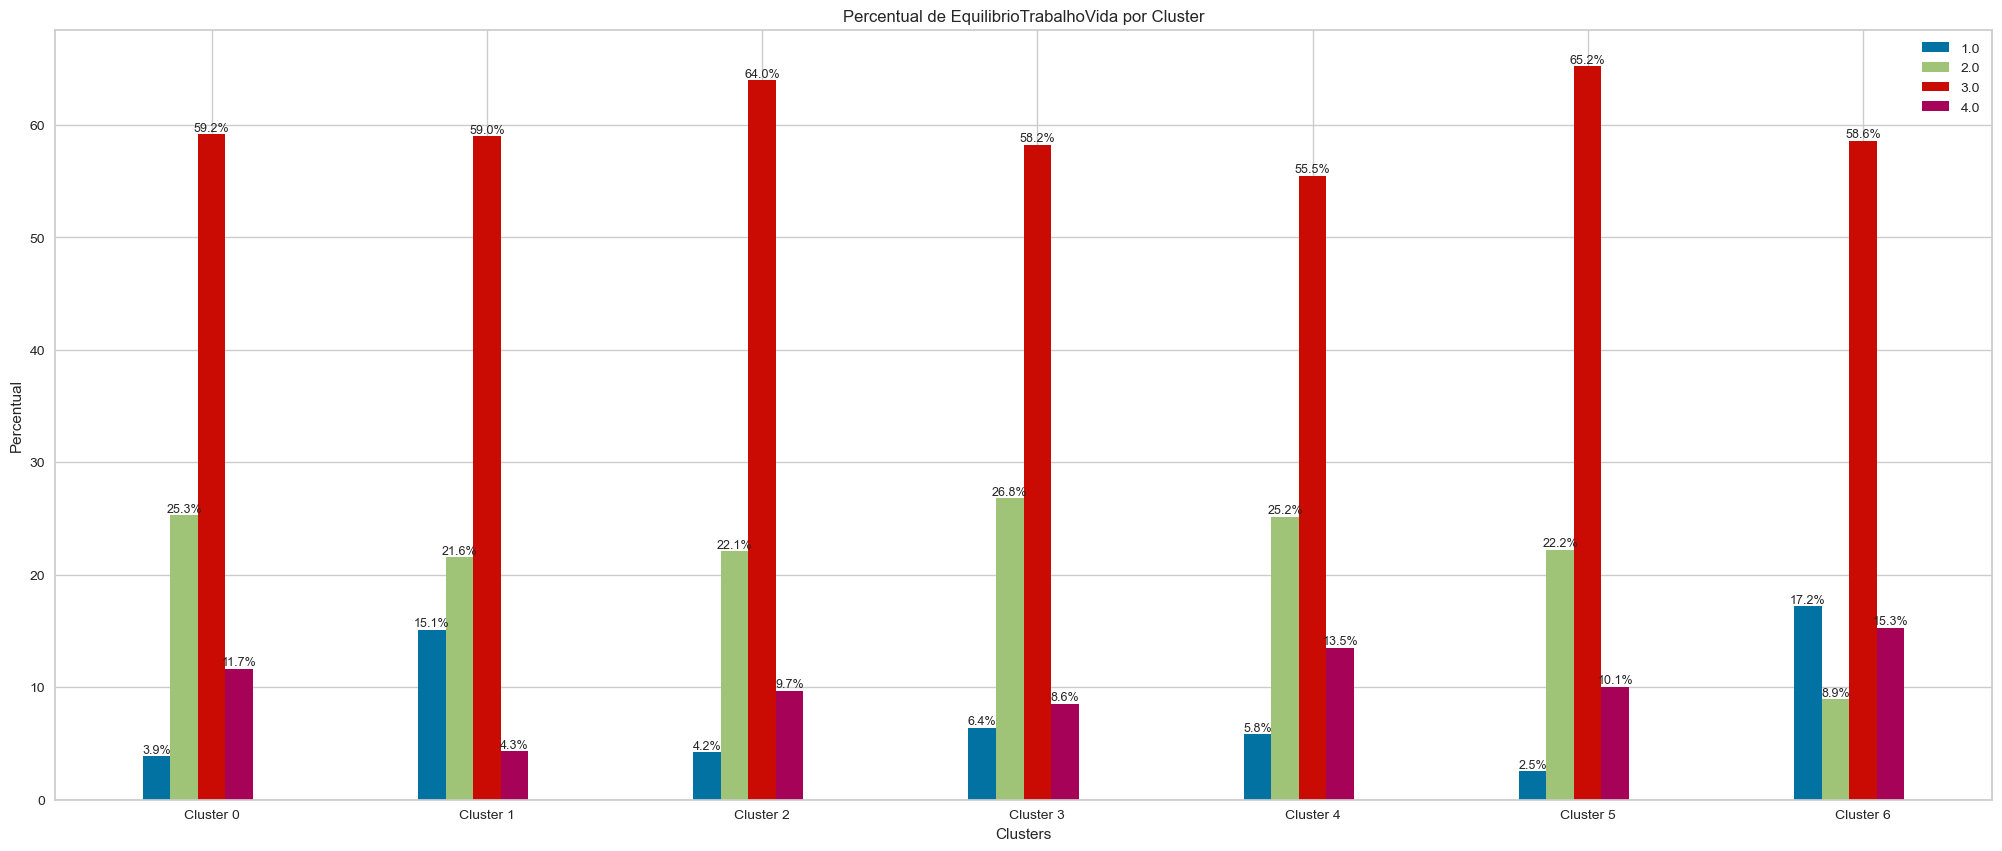

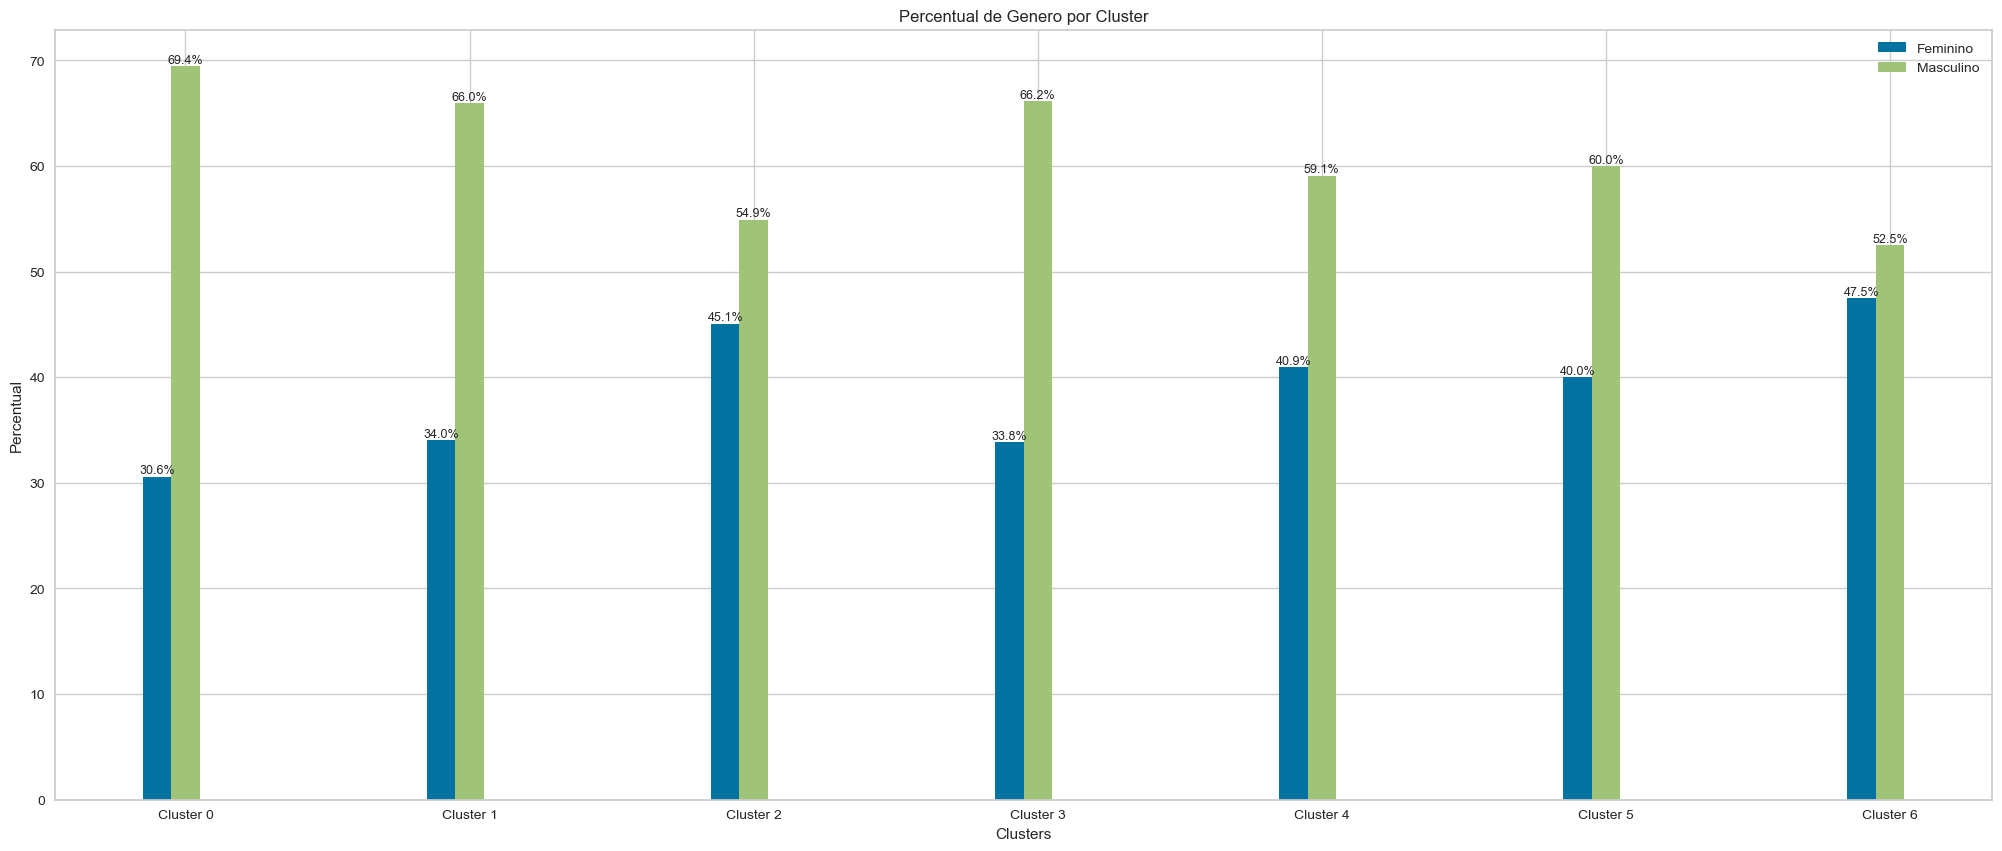

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


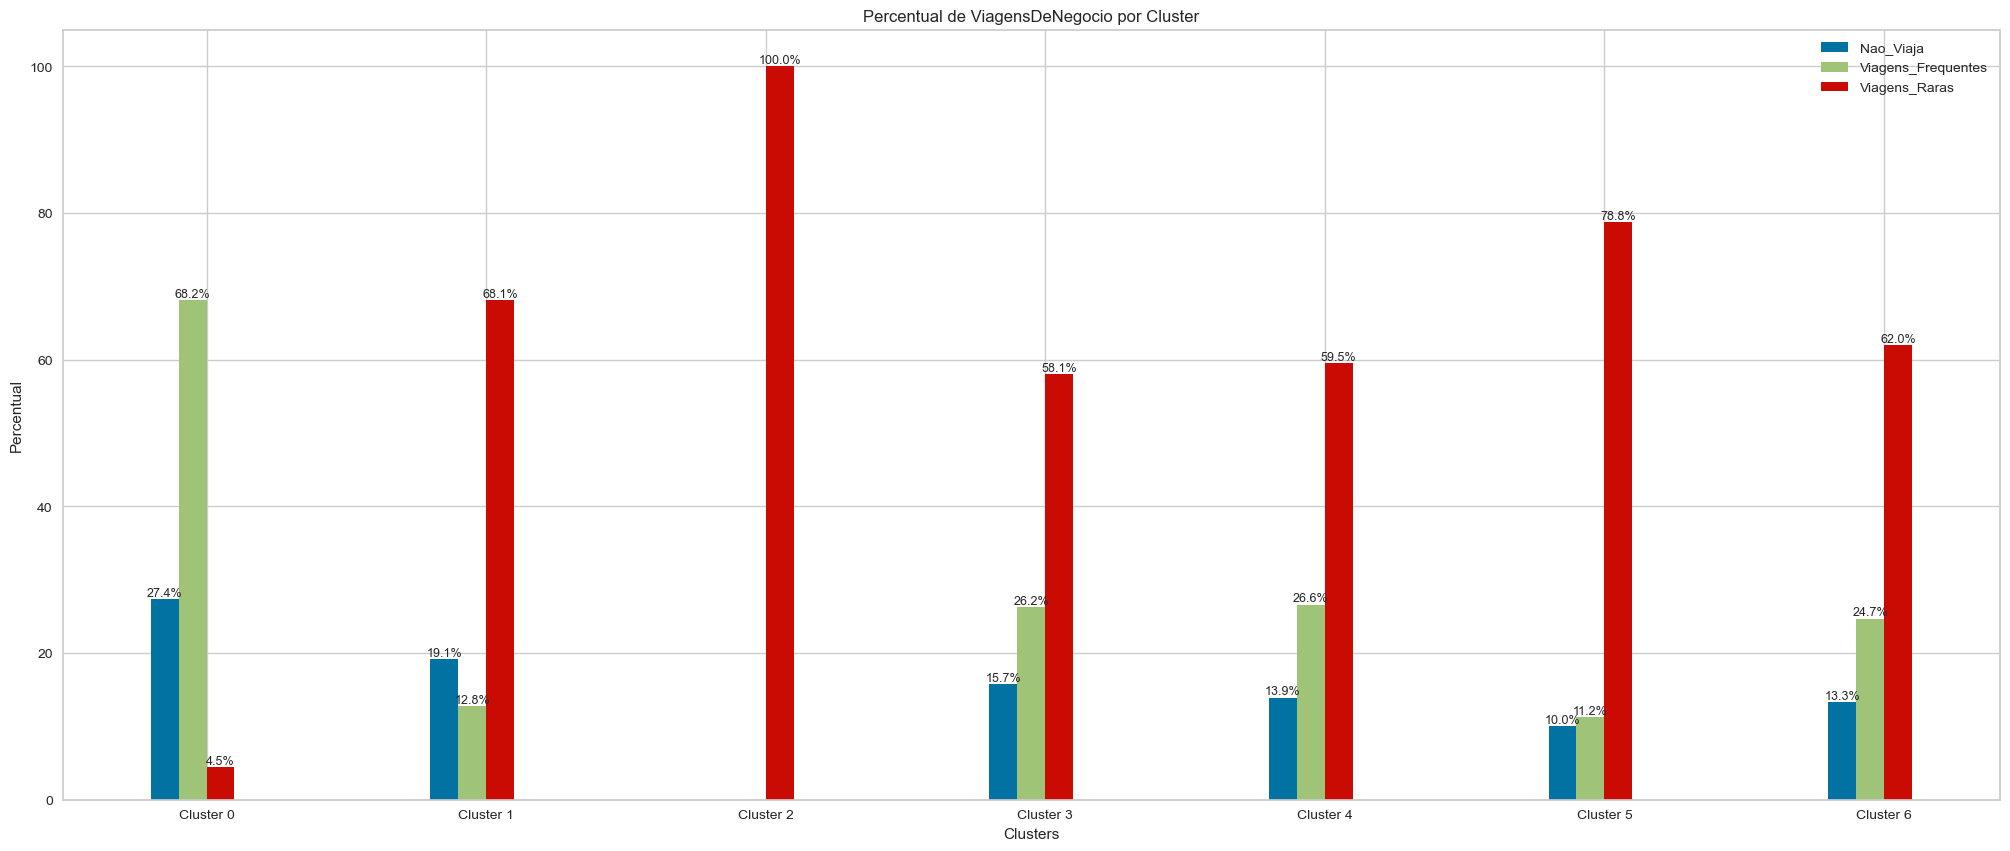

In [36]:
cat_vars = ['SatisfacaoComAmbiente', 'NivelDoCargo', 'SatisfacaoNoTrabalho', 'EquilibrioTrabalhoVida', 'Genero', 'ViagensDeNegocio']

for var in cat_vars:
  percentuais_por_cluster = abt.groupby('cluster')[var].value_counts(normalize=True).mul(100).unstack().reset_index().values

  # Extrair os clusters e os percentuais de satisfação
  clusters = percentuais_por_cluster[:, 0]
  percentuais = percentuais_por_cluster[:, 1:]

  # Largura da barra
  bar_width = 0.1

  # Coordenadas das barras
  x = np.arange(len(clusters))

  # Plotar o gráfico de barras
  plt.figure(figsize=(25, 10))

  unicos = sorted(abt[var].unique())
  for i in range(len(percentuais[0])):
      j = unicos[i]
      plt.bar(x + i * bar_width, percentuais[:, i], bar_width, label=f'{j}')
      for j, val in enumerate(percentuais[:, i]):
          plt.text(x[j] + i * bar_width, val, '{:.1f}%'.format(val), ha='center', va='bottom', fontsize=9)

  # Adicionar rótulos e título
  plt.xlabel('Clusters')
  plt.ylabel('Percentual')
  plt.title(f'Percentual de {var} por Cluster')
  plt.xticks(x + bar_width * len(percentuais[0]) / 2, [f'Cluster {int(cluster)}' for cluster in clusters])
  plt.legend(loc='best')

  # Mostrar o gráfico
  plt.show()

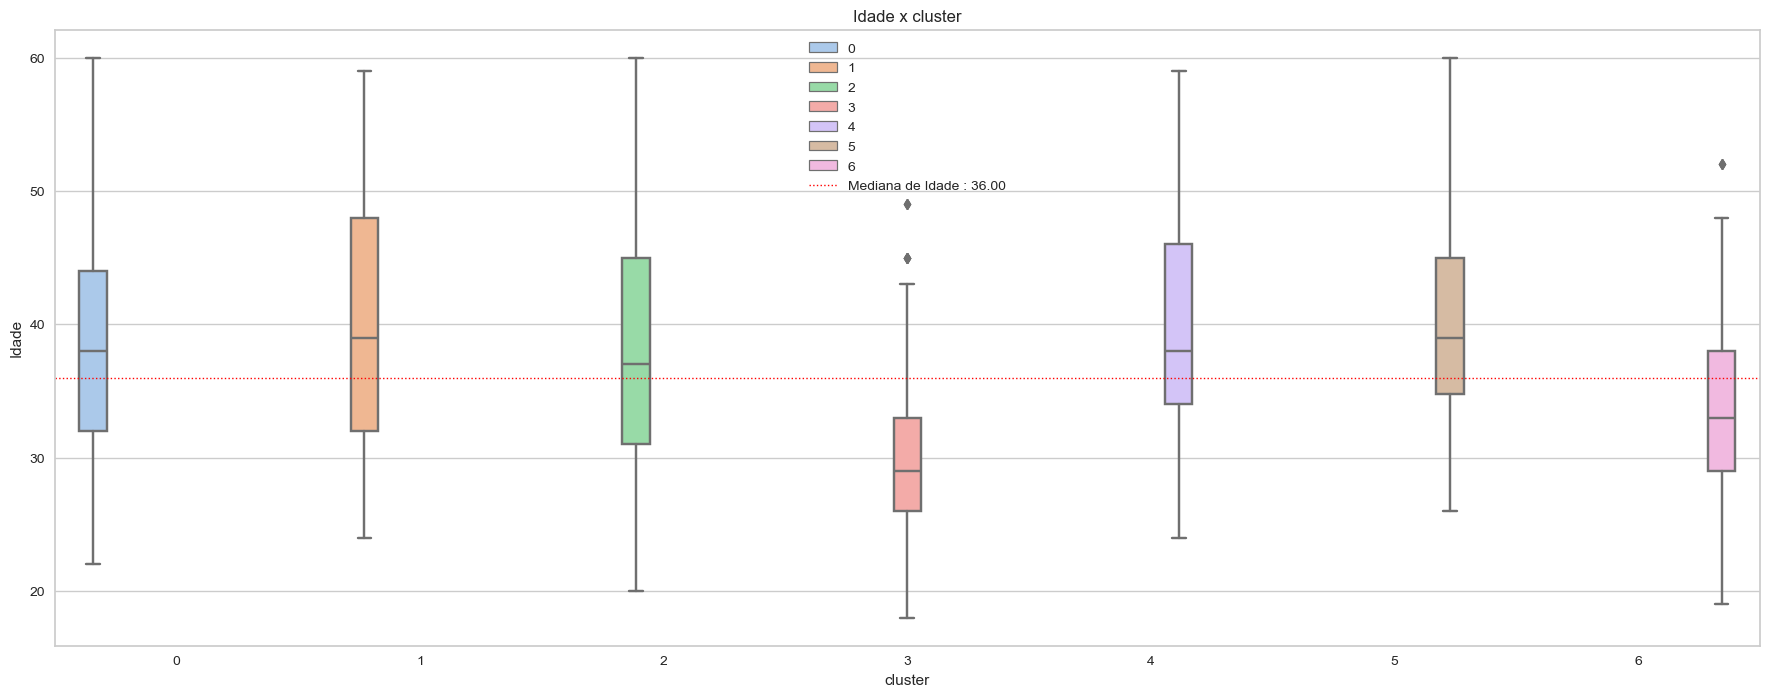

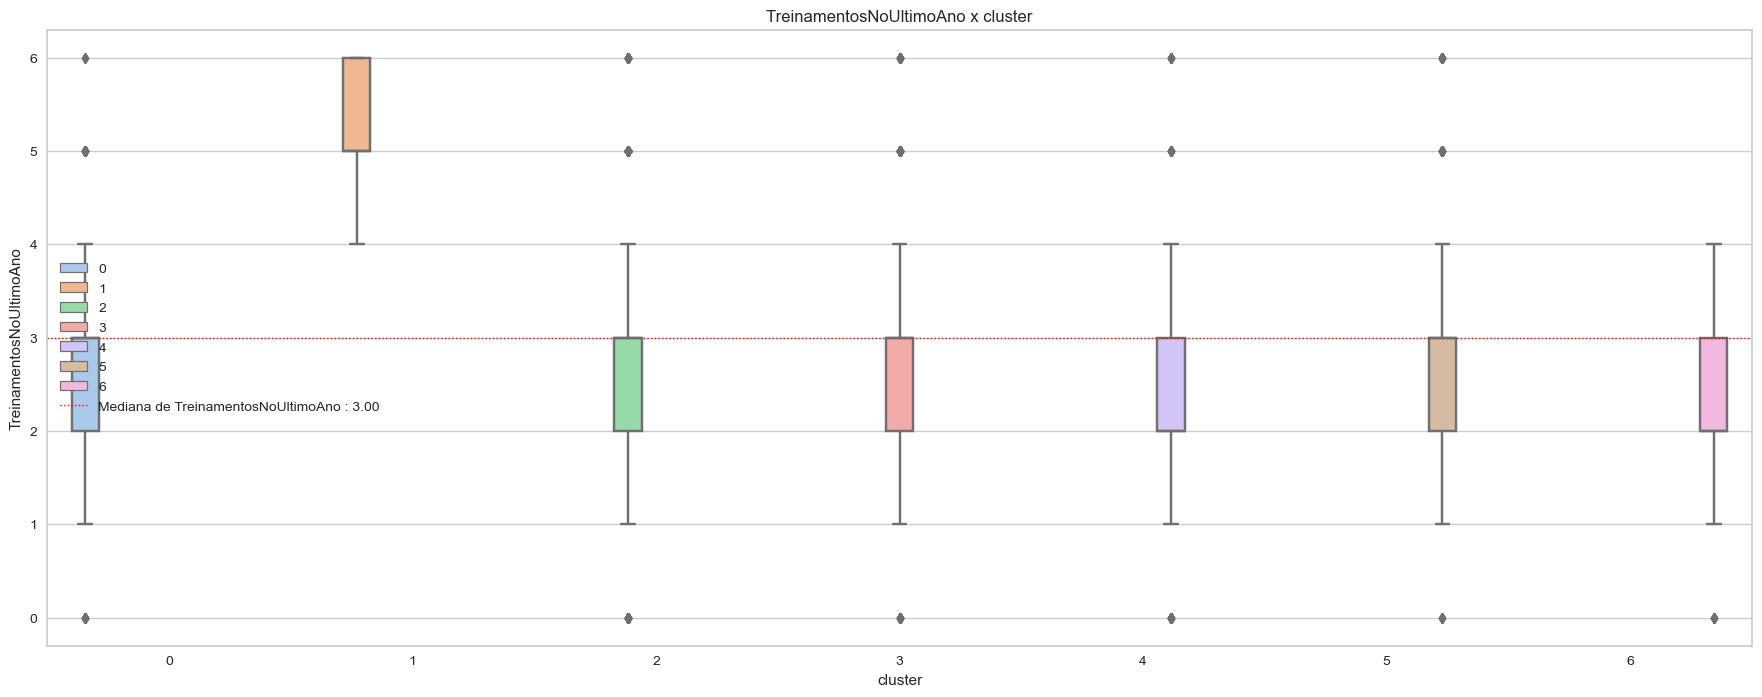

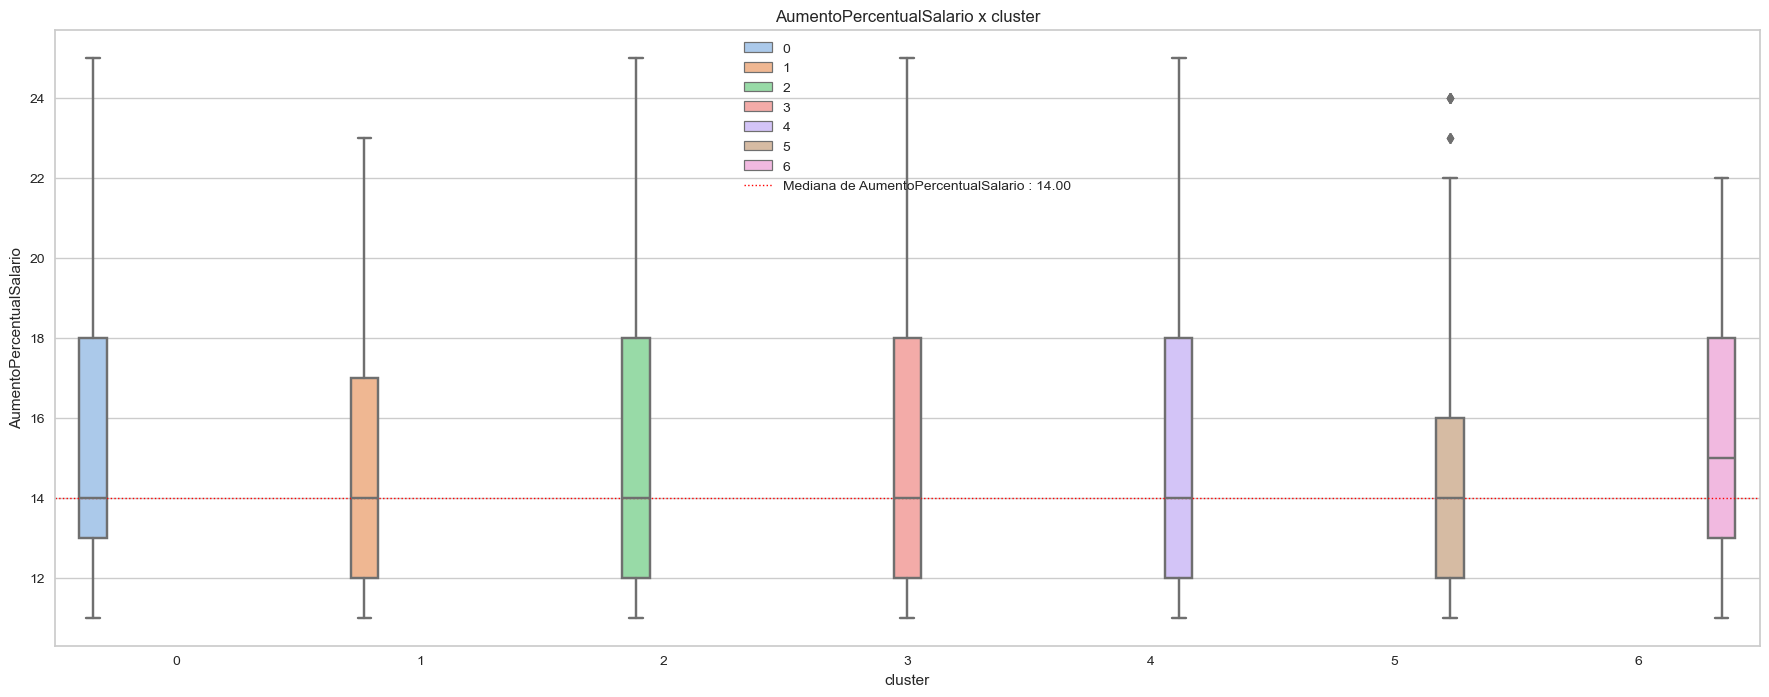

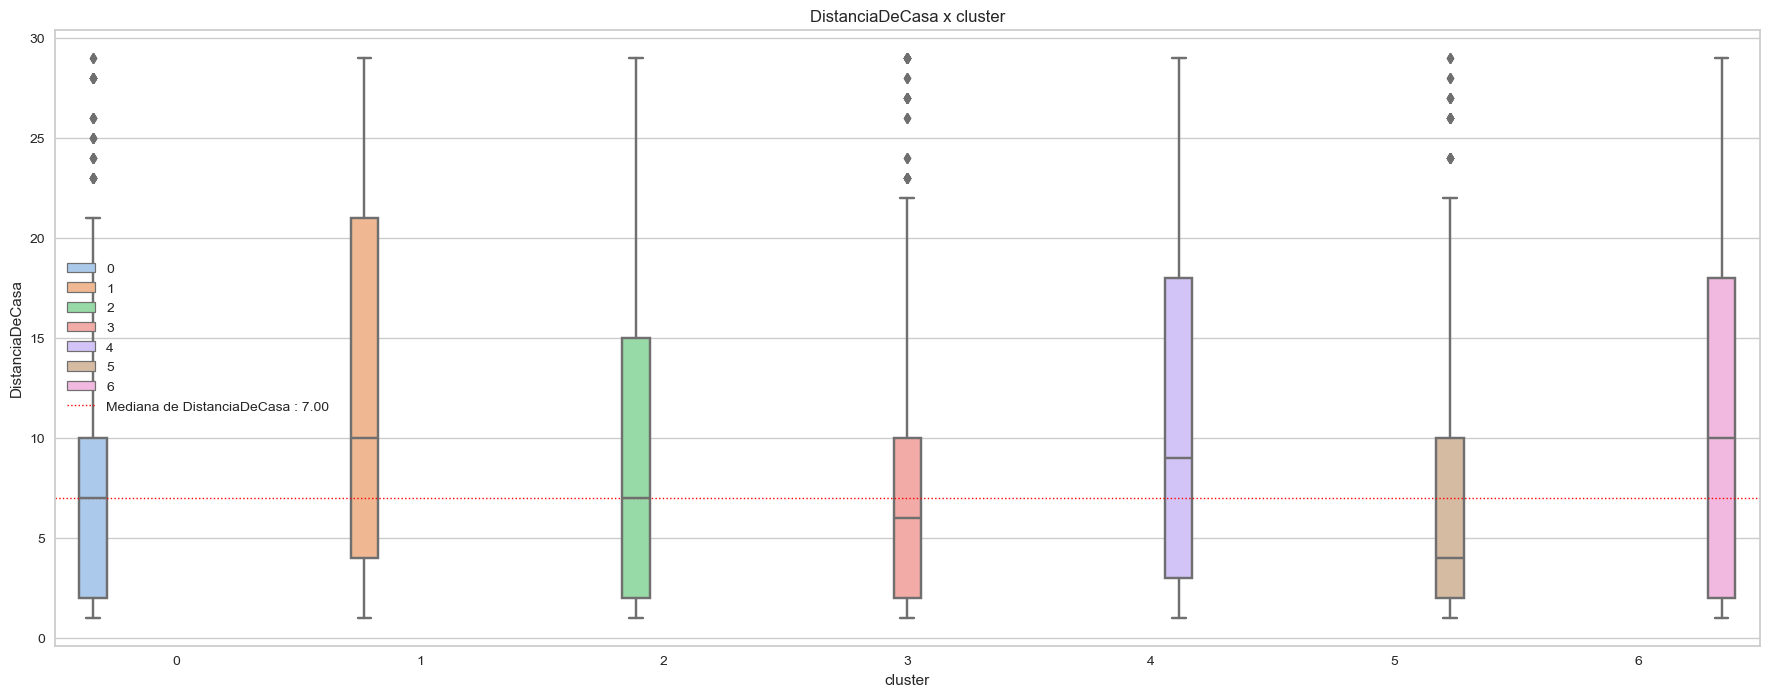

In [37]:
num_vars = ['Idade', 'TreinamentosNoUltimoAno', 'AumentoPercentualSalario','DistanciaDeCasa']

for var in num_vars:
  plt.figure(figsize=(22, 8))
  pl=sns.boxplot(x=abt["cluster"], y=abt[var], palette= sns.color_palette('pastel'), hue=abt["cluster"])

  mediana = abt[var].median()
  # Adicionando uma linha indicando a média da variável de rotatividade
  text = f'Mediana de {var} :'+' {:.2f}'.format(mediana)
  plt.axhline(mediana, color='red', linestyle='dotted', linewidth=1, label=text)

  pl.set_title(f"{var} x cluster")
  plt.legend()
  plt.show()

`Cluster 0`
* Rotatividade: 26,11% (alta)
* Quantidade de Funcionários: 471
* Equilíbrio Trabalho-Vida: 59,2% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 28,8% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 34% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 68,2% não viajam
* Idade: Mediana em torno de 37 anos
* Treinamentos: Alta quantidade de treinamentos
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 7 km


`Cluster 1`
* Rotatividade: 10,64% (baixa)
* Quantidade de Funcionários: 141
* Equilíbrio Trabalho-Vida: 59% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 31,9% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 33,8% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 68,1% raramente viajam
* Idade: Mediana em torno de 41 anos
* Treinamentos: Quantidade de treinamentos na média
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 10 km


`Cluster 2`
* Rotatividade: 11,17% (baixa)
* Quantidade de Funcionários: 1648 (maior cluster)
* Equilíbrio Trabalho-Vida: 58,2% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 32,6% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 32,9% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 100% raramente viajam
* Idade: Mediana em torno de 37 anos
* Treinamentos: Quantidade de treinamentos na média
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 8 km


`Cluster 3`
* Rotatividade: 24,59% (alta)
* Quantidade de Funcionários: 801
* Equilíbrio Trabalho-Vida: 64% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 34% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 34% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 58,1% raramente viajam
* Idade: Mediana em torno de 33 anos
* Treinamentos: Quantidade de treinamentos variada
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 6 km


`Cluster 4`
* Rotatividade: 14,77% (próximo da média)
* Quantidade de Funcionários: 711
* Equilíbrio Trabalho-Vida: 55,5% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 32,2% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 31,7% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 59,5% raramente viajam
* Idade: Mediana em torno de 39 anos
* Treinamentos: Quantidade de treinamentos na média
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 10 km


`Cluster 5`
* Rotatividade: 8,75% (baixa)
* Quantidade de Funcionários: 480
* Equilíbrio Trabalho-Vida: 65,2% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 32,1% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 32,1% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 78,8% raramente viajam
* Idade: Mediana em torno de 38 anos
* Treinamentos: Quantidade de treinamentos na média
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 7 km


`Cluster 6`
* Rotatividade: 28,48% (alta)
* Quantidade de Funcionários: 158
* Equilíbrio Trabalho-Vida: 58,6% dos funcionários reportam baixo equilíbrio (nota 4)
* Satisfação com o Ambiente de Trabalho: 32,8% estão muito satisfeitos (nota 4)
* Satisfação no Trabalho: 33,8% estão muito satisfeitos (nota 4)
* Viagens de Negócio: 62% raramente viajam
* Idade: Mediana em torno de 34 anos
* Treinamentos: Quantidade de treinamentos variada
* Aumento Percentual de Salário: Mediana em torno de 14%
* Distância de Casa: Mediana de 8 km


Resumo:

`Clusters com Alta Rotatividade:` Clusters 0, 3 e 6. Esses clusters têm um equilíbrio trabalho-vida geralmente baixo e, apesar de uma alta satisfação no trabalho e ambiente, continuam com alta rotatividade. A idade média mais jovem e a quantidade variável de treinamentos sugerem que esses funcionários podem estar buscando mais desenvolvimento e oportunidades.


`Clusters com Baixa Rotatividade`: Clusters 1, 2, 4 e 5. Esses clusters têm funcionários mais velhos, com equilíbrio trabalho-vida similar aos clusters com alta rotatividade, mas com alta satisfação no ambiente e no trabalho, o que parece compensar e reduzir a rotatividade.

<center><h3>Insights Acionáveis para Mitigar a Alta Taxa de Rotatividade</h></center>


> Desenvolvimento Profissional e Oportunidades de Crescimento:

* Programas de Mentoria: Implementar programas de mentoria para funcionários mais jovens (especialmente em clusters com alta rotatividade).


* Treinamentos Personalizados: Oferecer treinamentos alinhados às necessidades e aspirações de cada cluster, focando em desenvolvimento de habilidades e crescimento na carreira.


* Planos de Carreira: Criar planos de carreira claros e acessíveis, mostrando caminhos de progresso dentro da empresa.

> Equilíbrio entre Vida Pessoal e Trabalho:

* Políticas de Trabalho Flexível: Introduzir políticas de trabalho flexível, como horários de trabalho flexíveis e possibilidade de trabalho remoto, para melhorar o equilíbrio entre vida pessoal e trabalho.


* Benefícios de Bem-Estar: Oferecer benefícios que promovam o bem-estar, como programas de saúde mental, academias e atividades recreativas.

> Satisfação com o Ambiente de Trabalho:

* Melhorar o Ambiente de Trabalho: Investir em melhorias no ambiente físico de trabalho e na cultura organizacional para aumentar a satisfação dos funcionários.


* Feedback Contínuo: Implementar um sistema de feedback contínuo onde os funcionários possam expressar suas preocupações e sugestões regularmente.


> Ajustes Salariais e Benefícios Competitivos:

* Revisão Salarial: Realizar revisões salariais regulares para garantir que os salários estão alinhados com o mercado e com as expectativas dos funcionários.


* Incentivos e Bonificações: Implementar incentivos e bonificações baseadas em desempenho para motivar e recompensar os funcionários.


> Mobilidade e Desenvolvimento Interno:

* Oportunidades de Mobilidade Interna: Promover oportunidades de mobilidade interna para permitir que os funcionários explorem diferentes áreas dentro da empresa.


* Projetos Desafiadores: Envolver funcionários em projetos desafiadores que lhes permitam desenvolver novas habilidades e se sentirem valorizados.

> Monitoramento e Análise Contínua:

* Análise de Dados: Utilizar análises de dados contínuas para monitorar a rotatividade e identificar padrões ou problemas emergentes.


* Pesquisas de Clima Organizacional: Realizar pesquisas de clima organizacional regularmente para obter insights sobre a satisfação e necessidades dos funcionários.


> Redução da Necessidade de Viagens de Negócio:

* Flexibilidade nas Viagens: Reduzir a necessidade de viagens de negócio frequentes ou oferecer alternativas como videoconferências.

* Compensações Adequadas: Fornecer compensações adequadas para funcionários que precisam viajar frequentemente, incluindo dias de folga adicionais ou benefícios extras.


> Apoio ao Deslocamento:

* Benefícios de Transporte: Oferecer subsídios de transporte ou serviços de transporte para funcionários que moram longe da empresa para reduzir o impacto do deslocamento longo.


> Implementação e Monitoramento

* Criação de um Comitê de Retenção: Formar um comitê responsável por implementar e monitorar as ações sugeridas, garantindo que sejam eficazes e ajustadas conforme necessário.


* Comunicação Transparente: Manter uma comunicação aberta e transparente com os funcionários sobre as medidas que estão sendo tomadas para melhorar suas experiências e reduzir a rotatividade.

# Modelagem (Classificação)

## EDA

In [38]:
X = abt.drop(columns=['IDDoEmpregado', 'Rotatividade', 'TARGET', 'cluster', 'MaiorDe18', 'ContagemDeEmpregados']).copy()

extra_cat_vars = ['SatisfacaoComAmbiente','SatisfacaoNoTrabalho','EquilibrioTrabalhoVida','EnvolvimentoNoTrabalho','AvaliacaoDeDesempenho','Educacao']

cat_vars = X.select_dtypes(include= 'object').columns.tolist()
num_vars = X.select_dtypes(exclude='object').columns.tolist()

cat_vars = cat_vars + extra_cat_vars
num_vars = list(set(num_vars) - set(extra_cat_vars))

del(X)

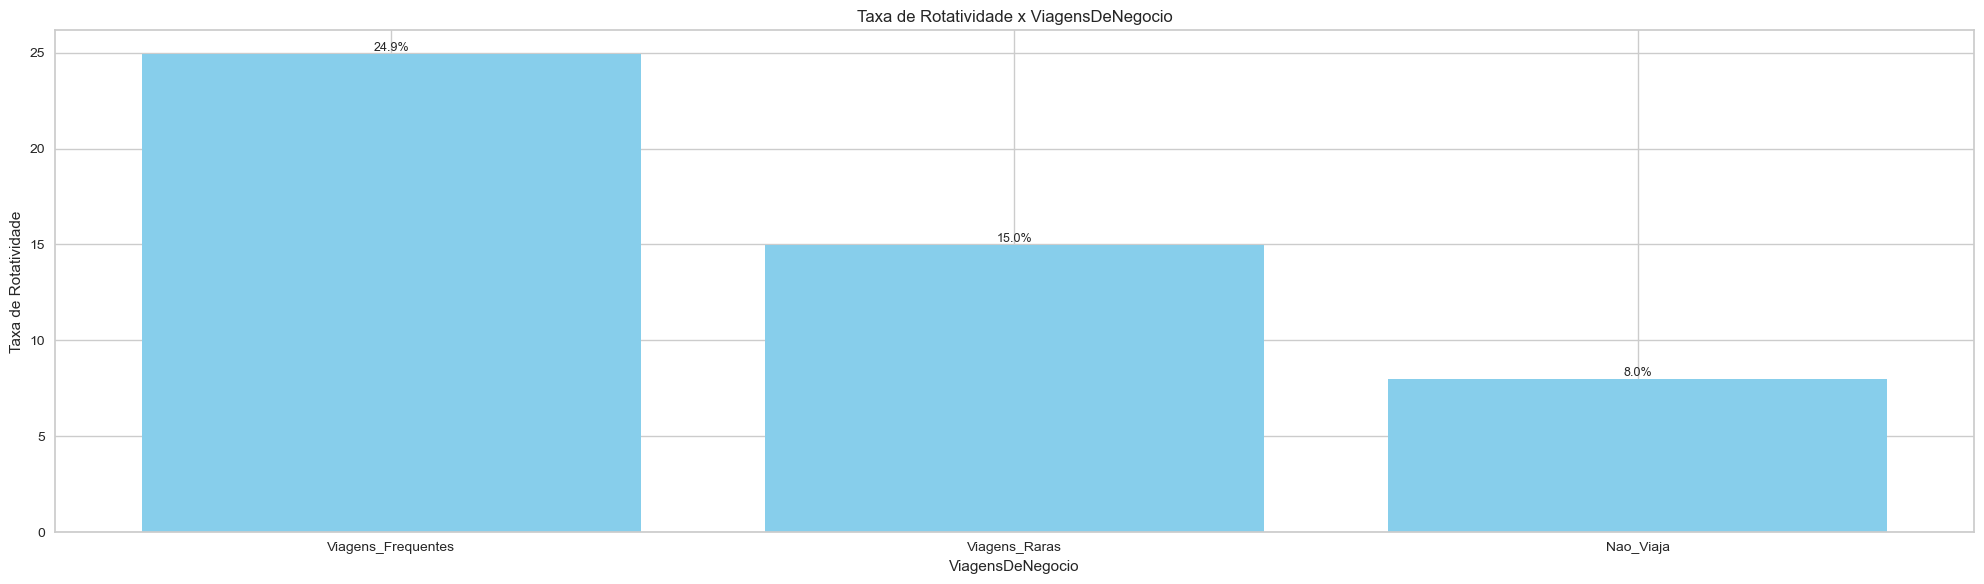

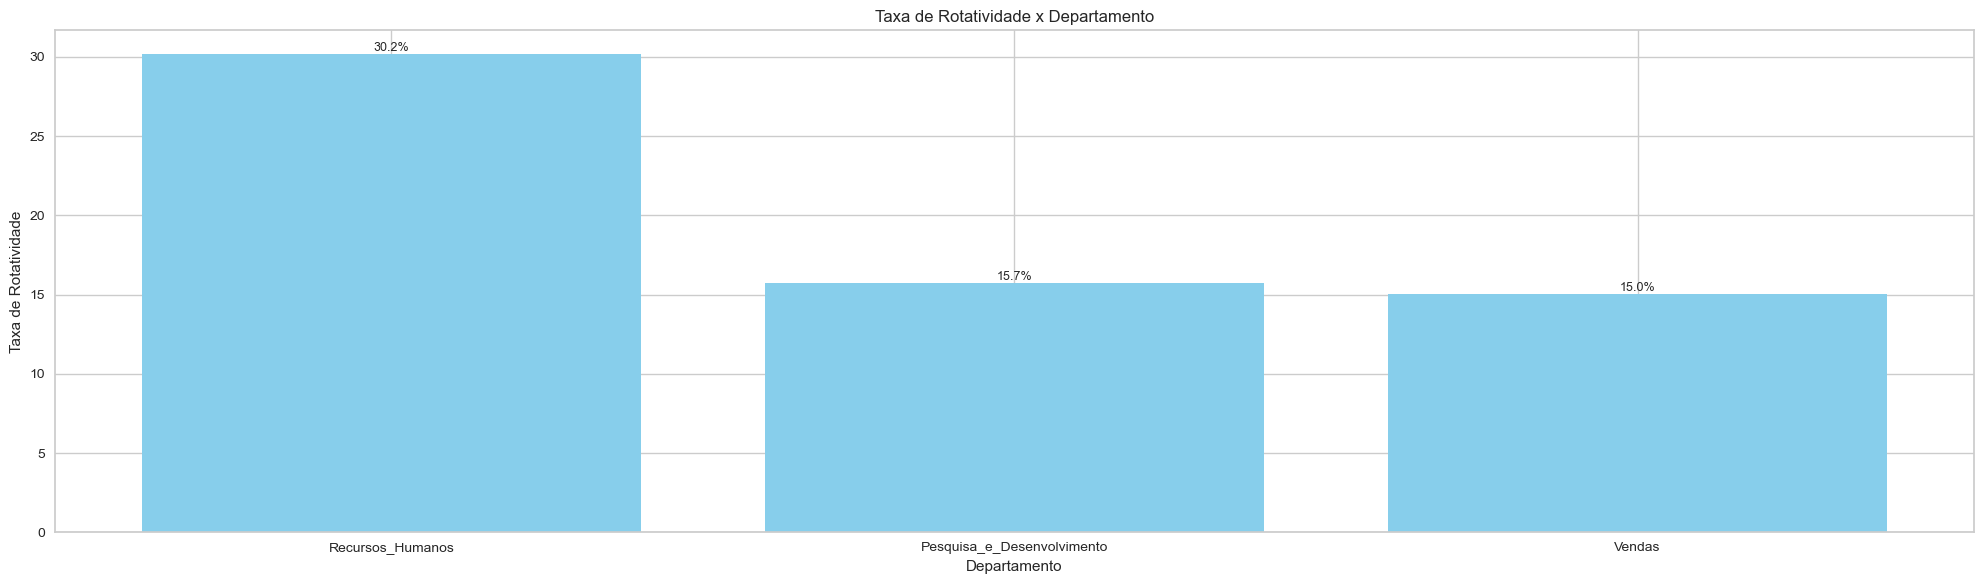

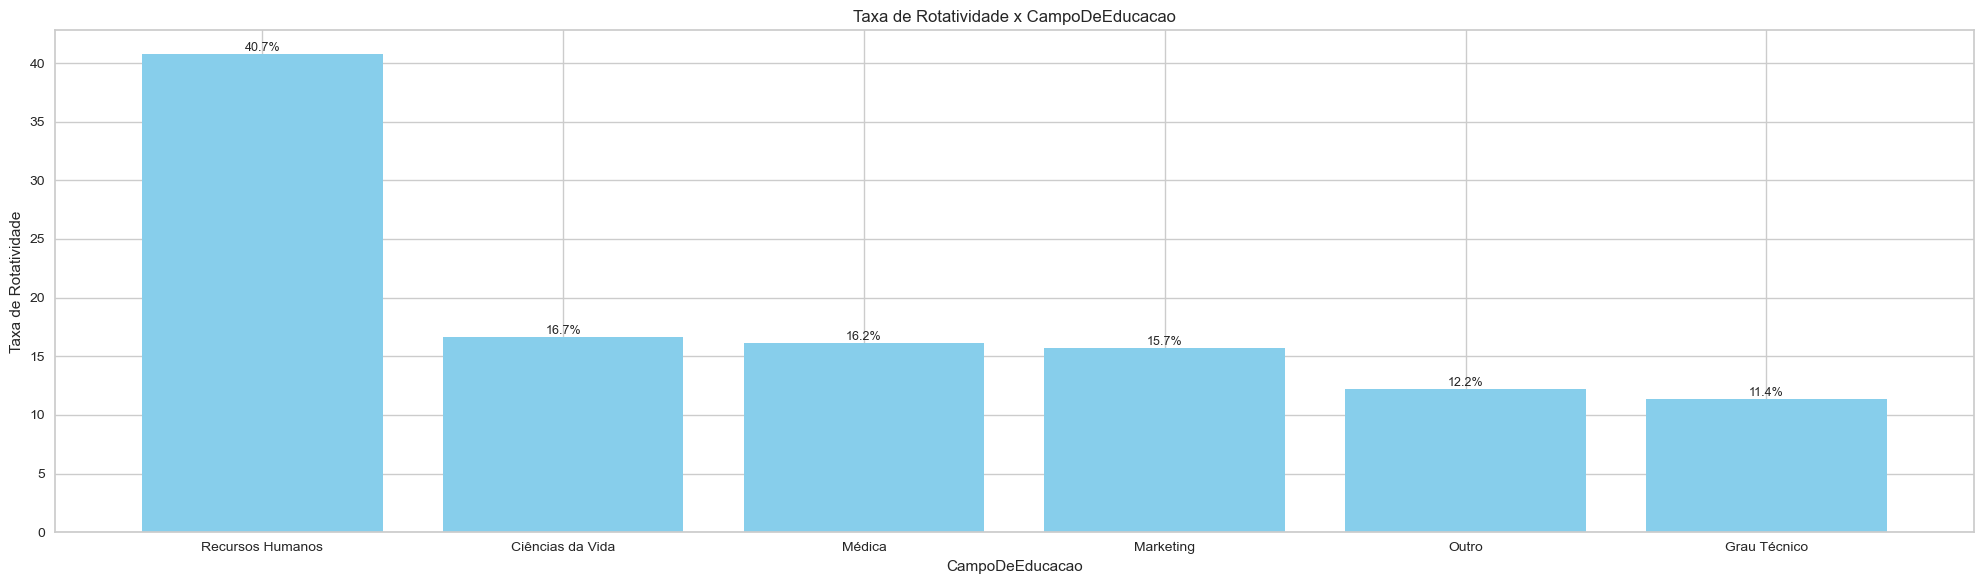

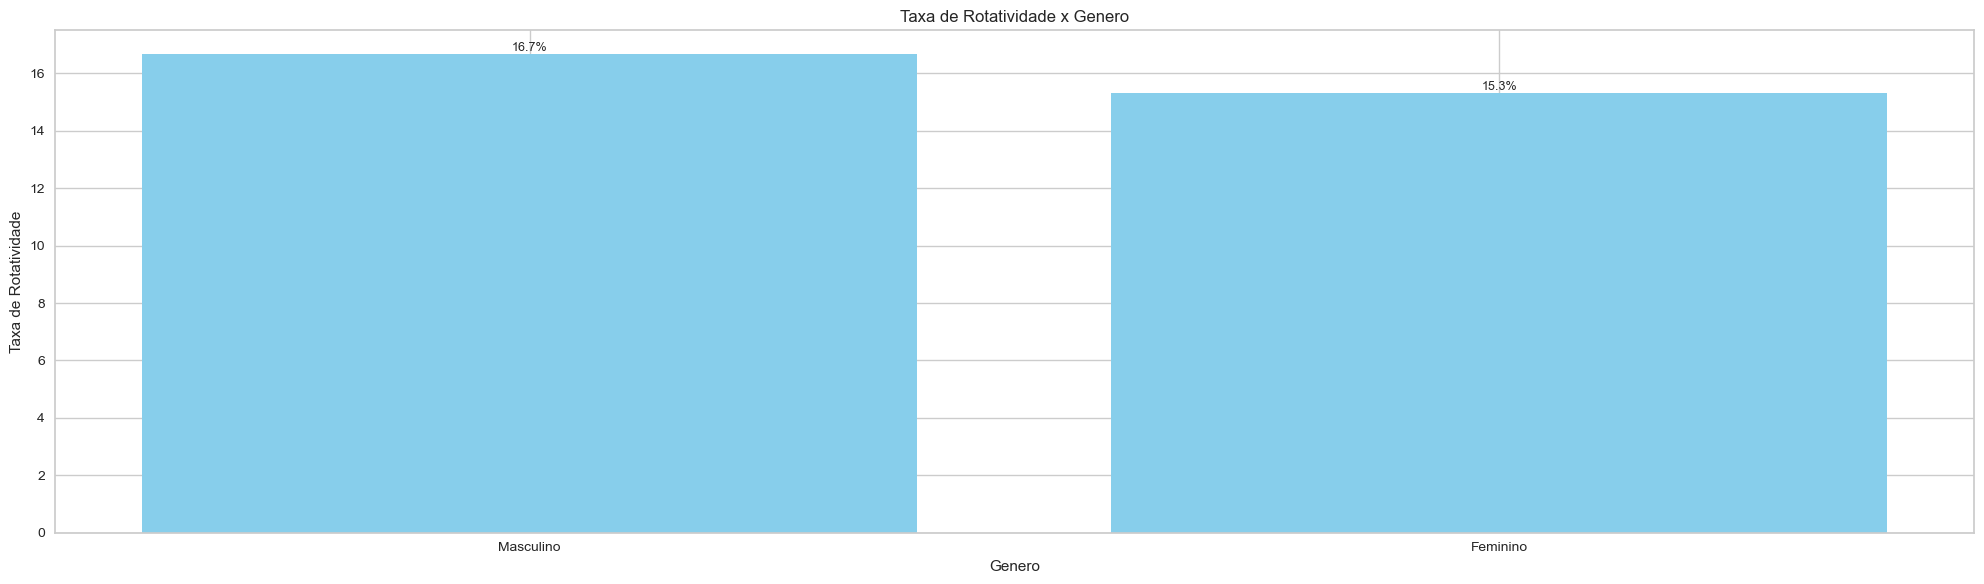

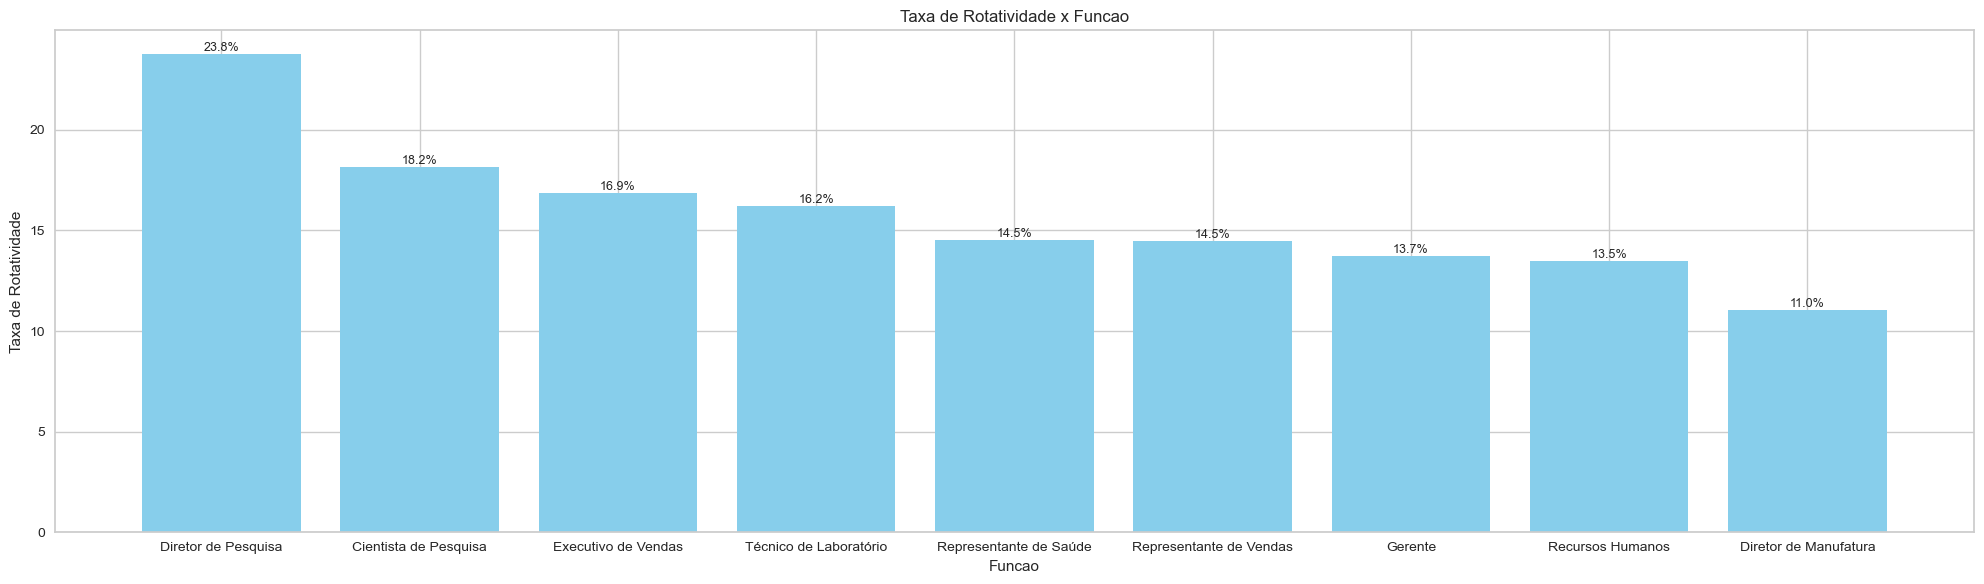

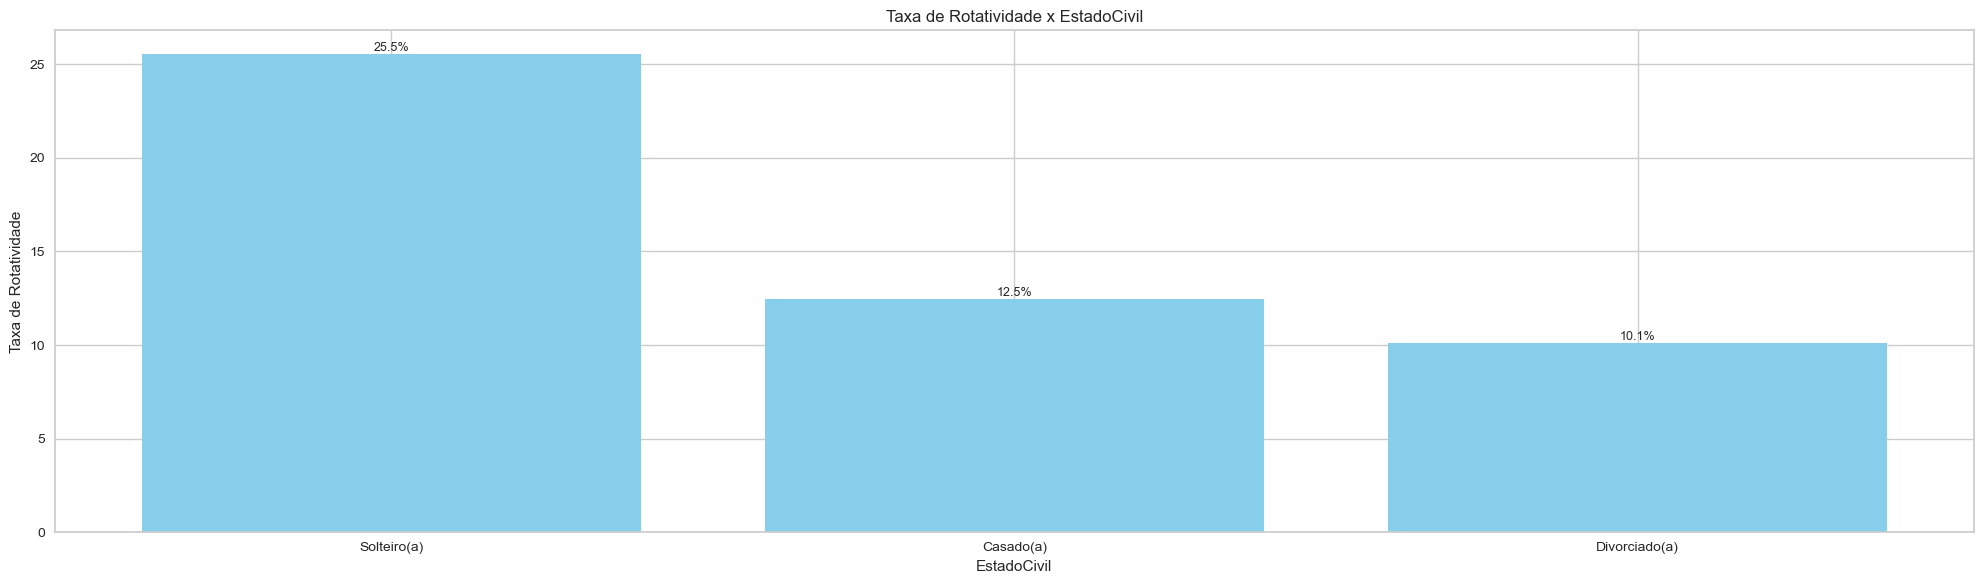

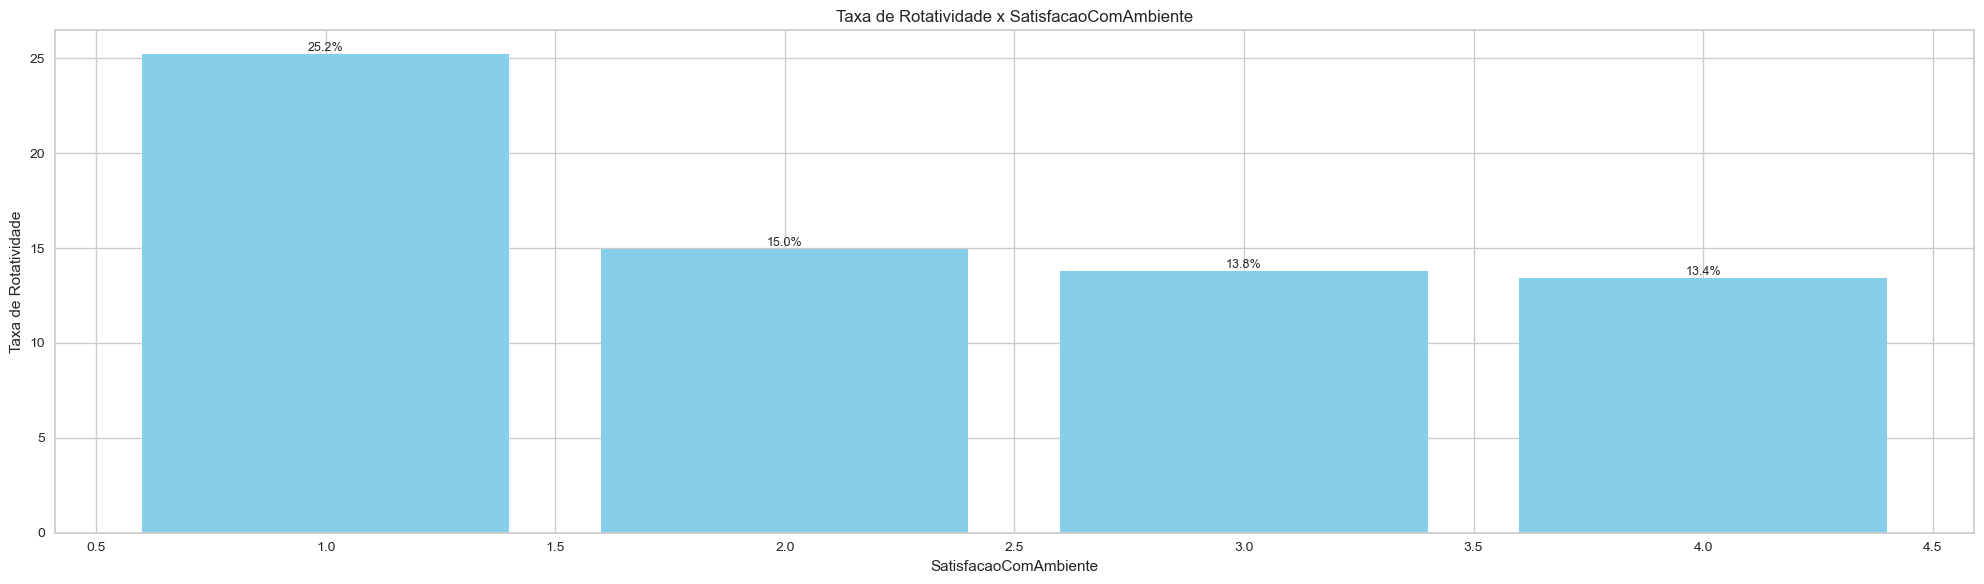

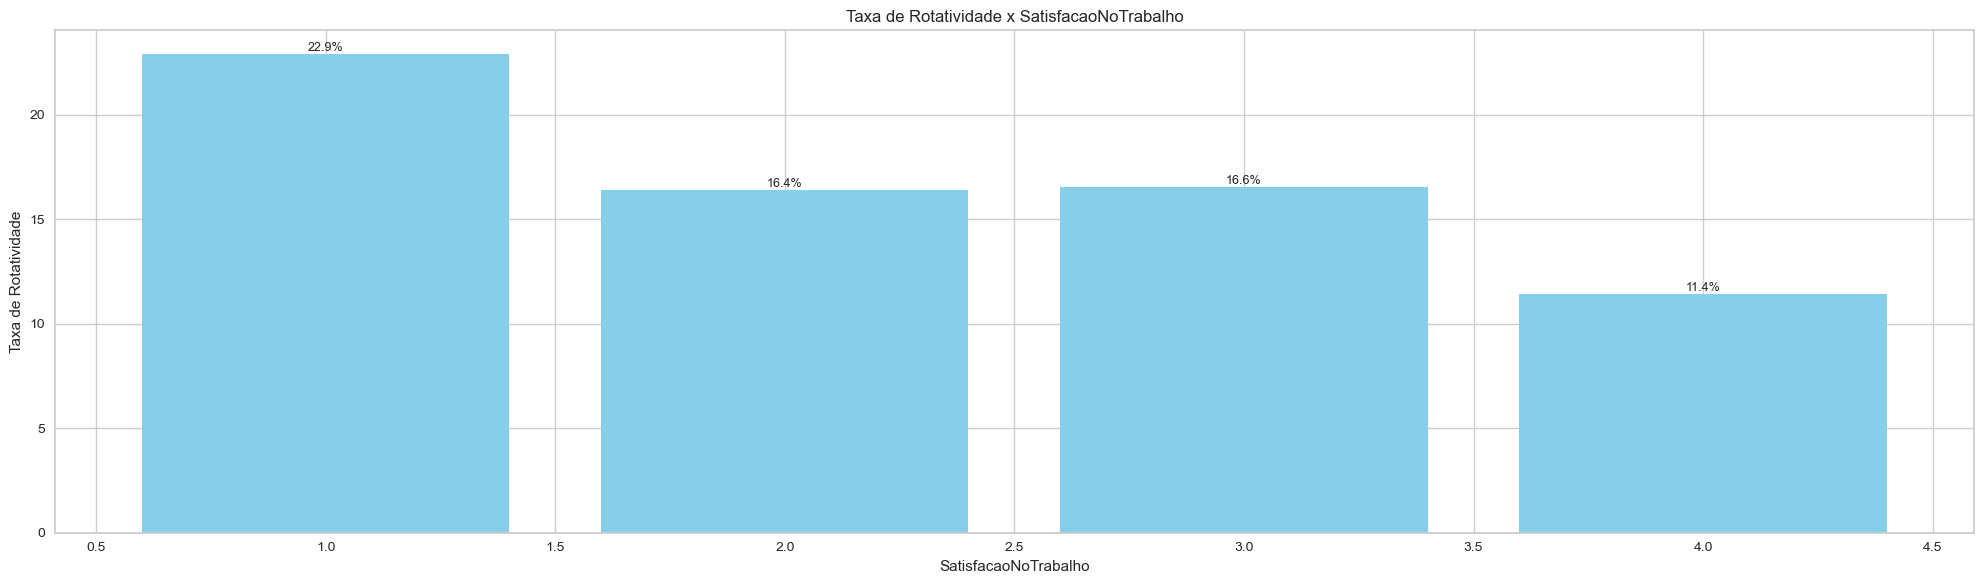

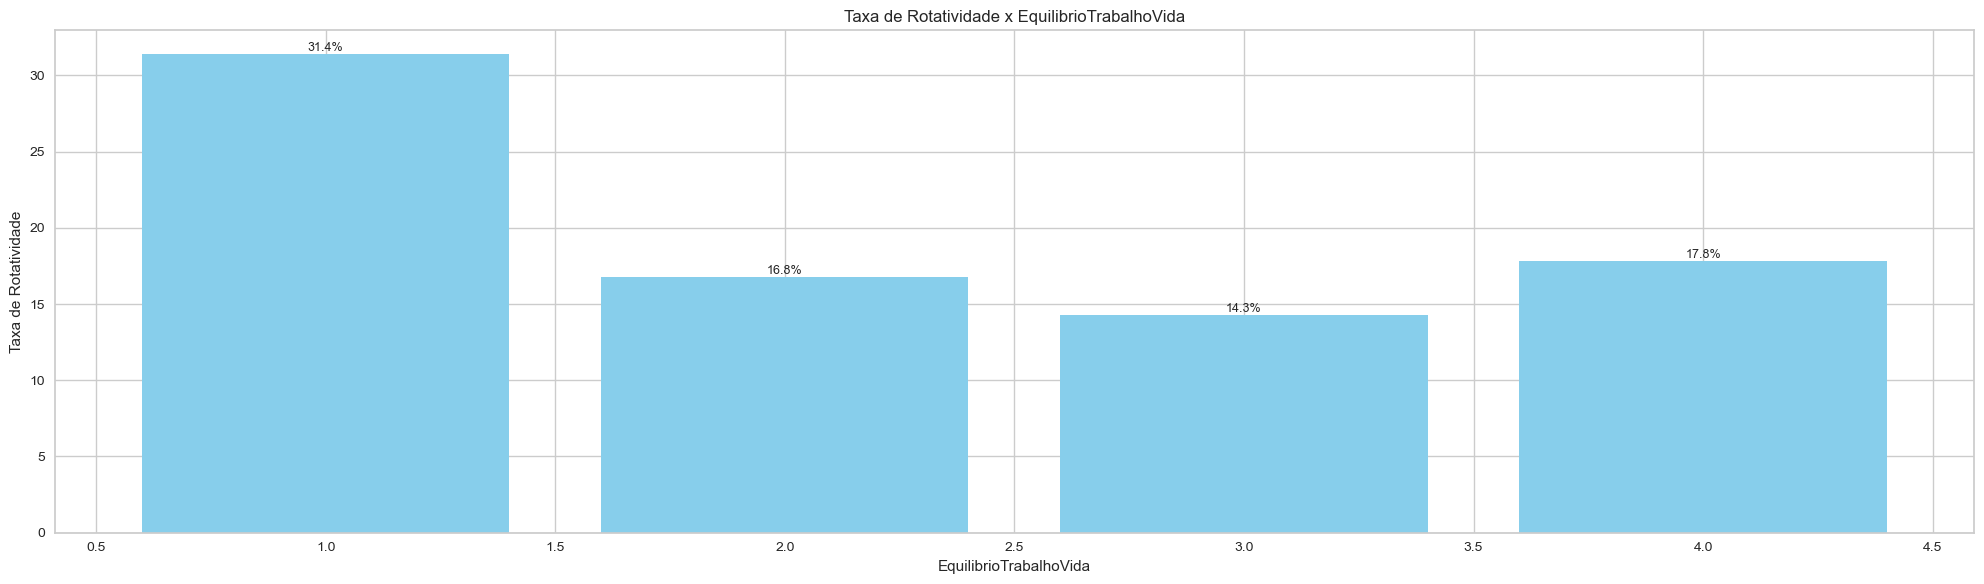

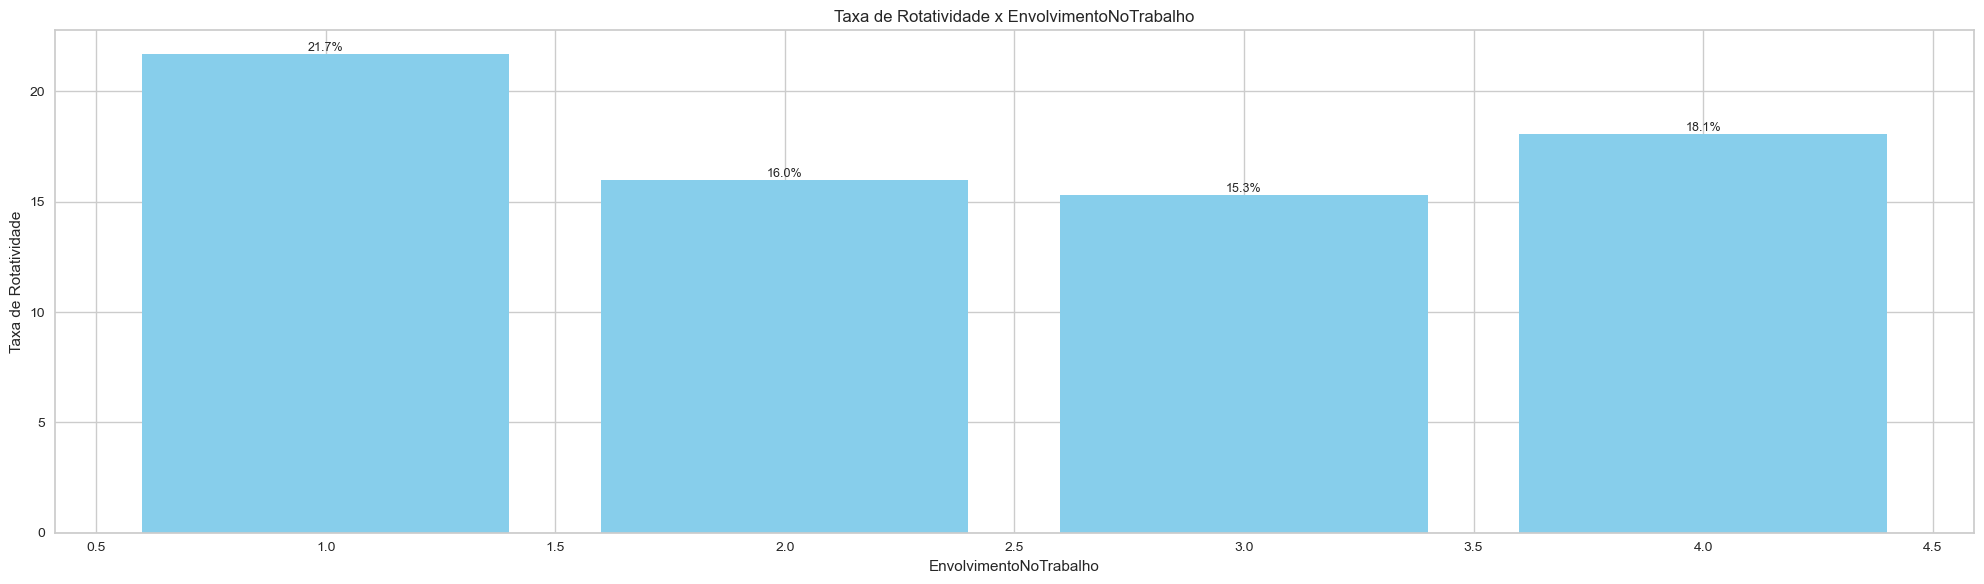

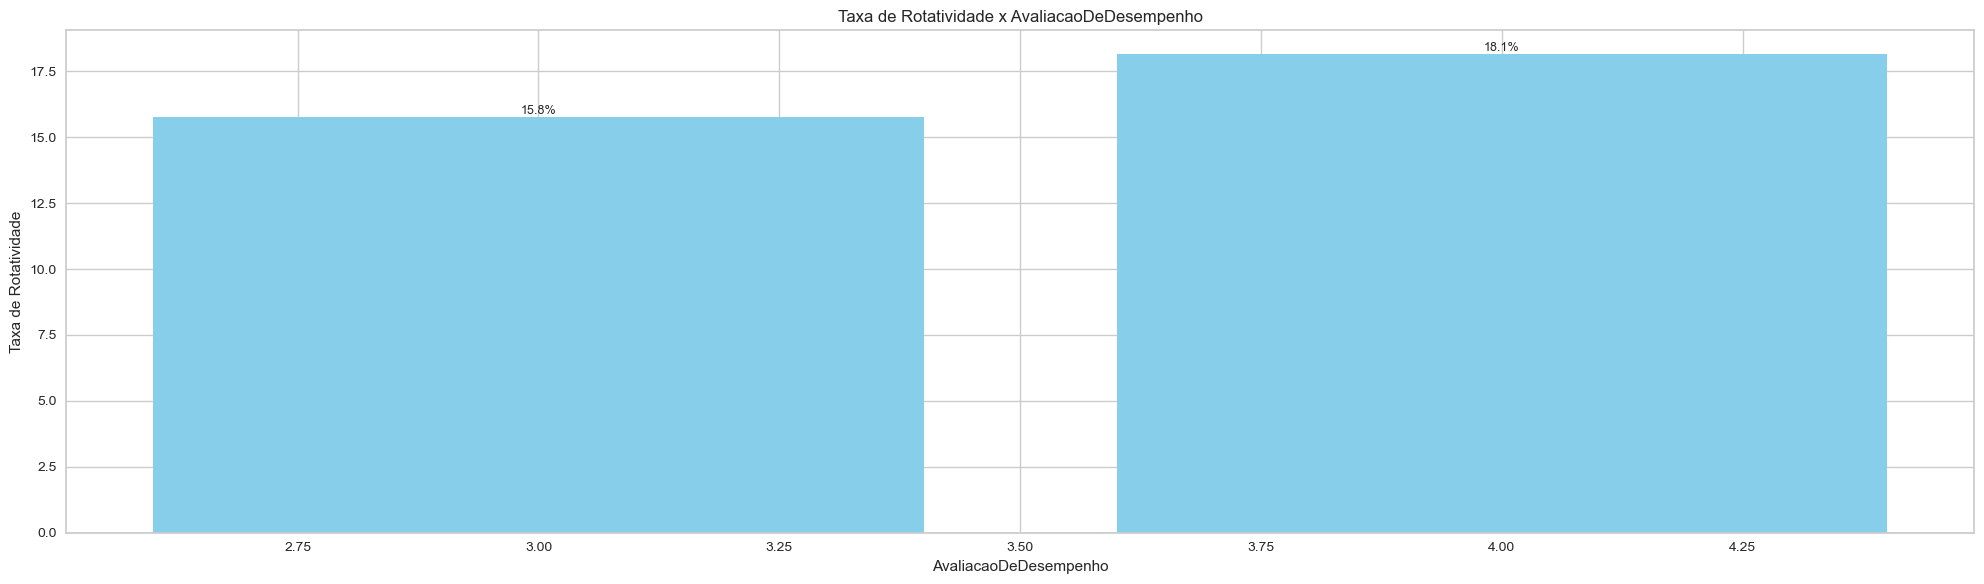

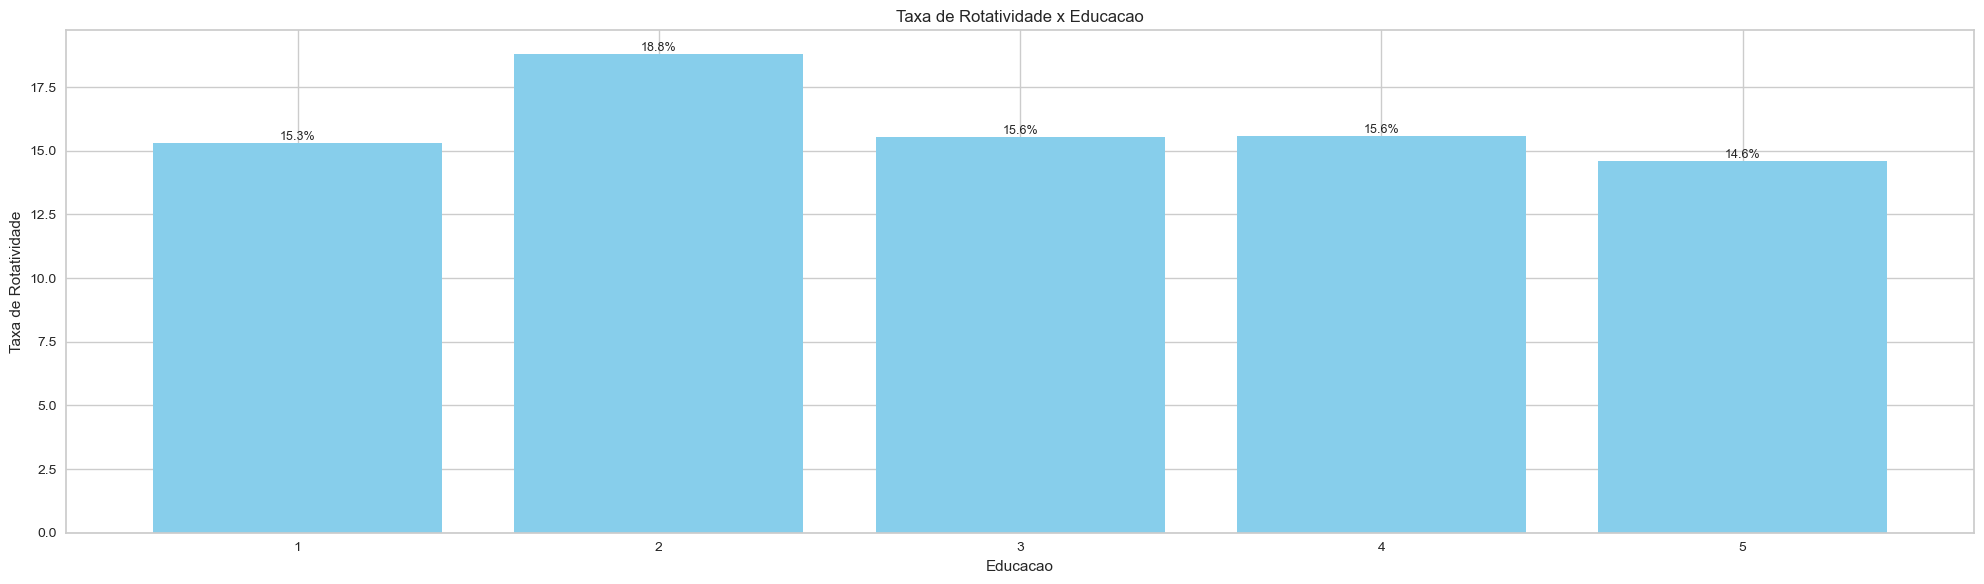

In [39]:
# Variáveis a serem analisadas:
for var in cat_vars:

  percentual_por_categoria = abt.groupby(var)['TARGET'].mean() * 100

  percentual_por_categoria = percentual_por_categoria.sort_values(ascending=False)

  plt.figure(figsize=(20, 6))
  bars = plt.bar(percentual_por_categoria.index, percentual_por_categoria.values, color='skyblue')

  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

  plt.title(f'Taxa de Rotatividade x {var}')
  plt.xlabel(f'{var}')
  plt.ylabel('Taxa de Rotatividade')
  plt.tight_layout()
  plt.show()

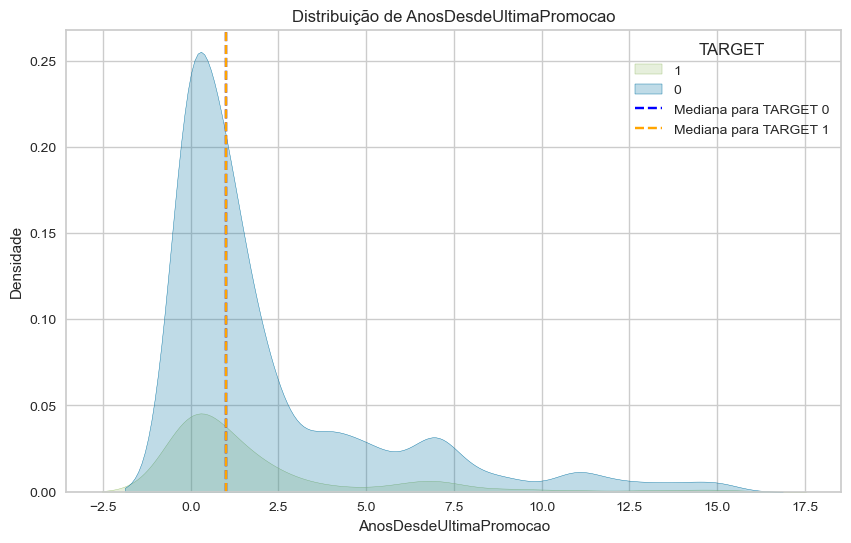

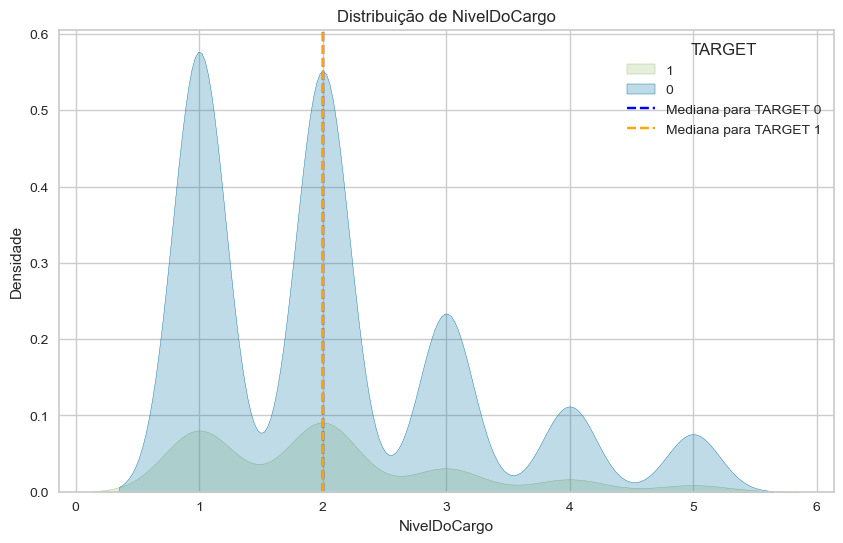

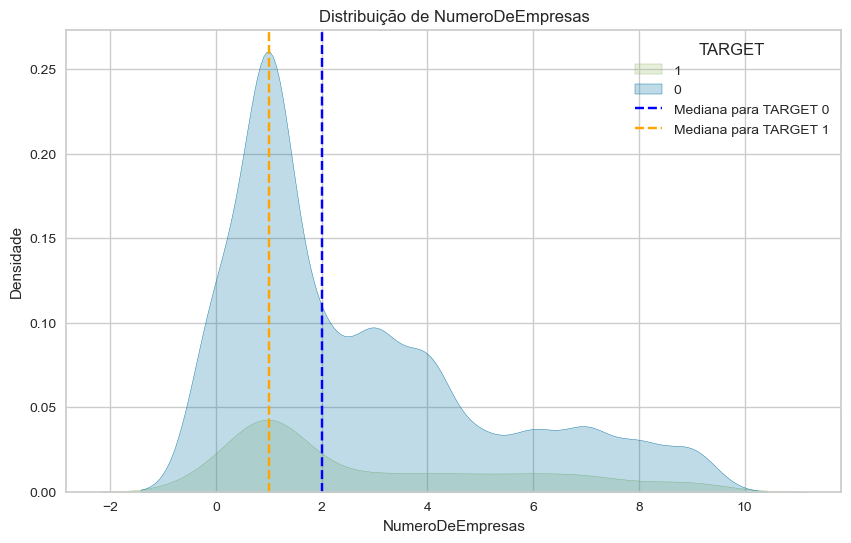

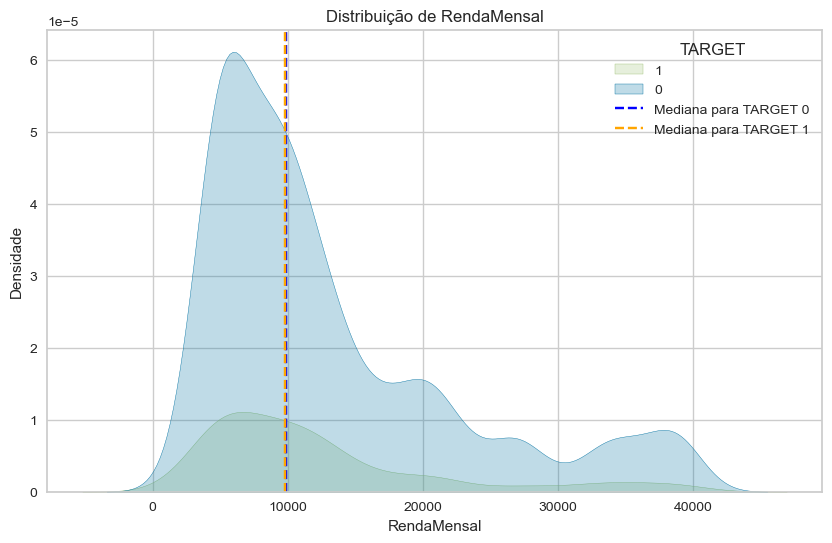

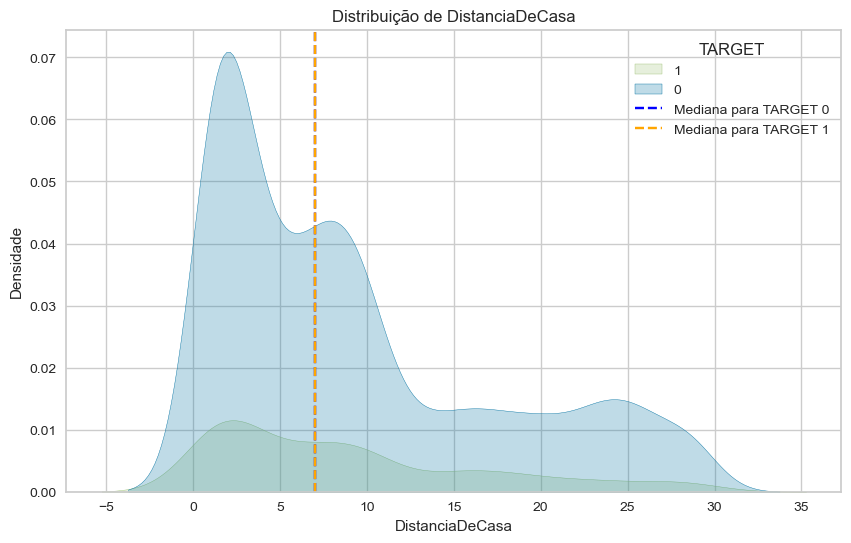

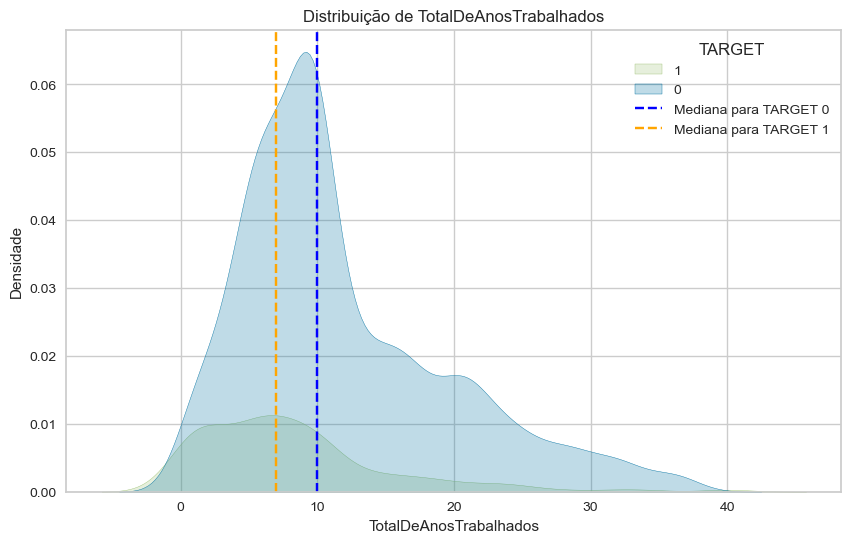

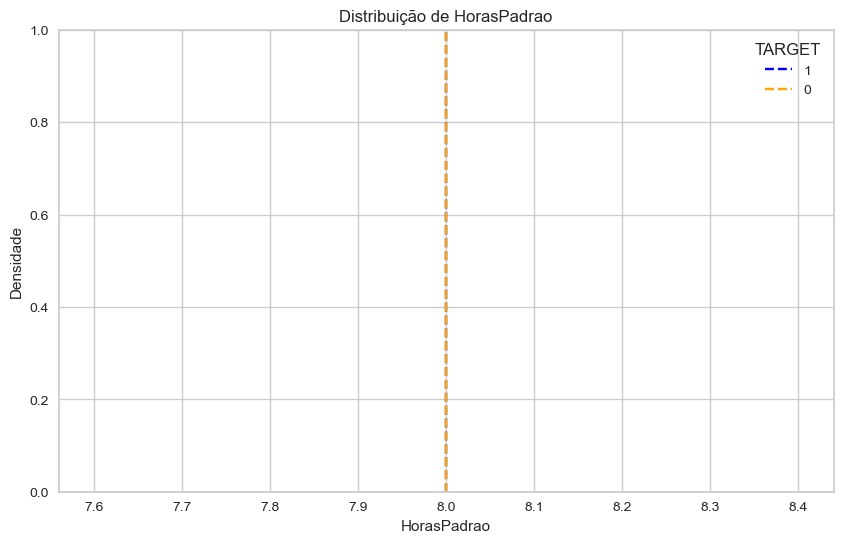

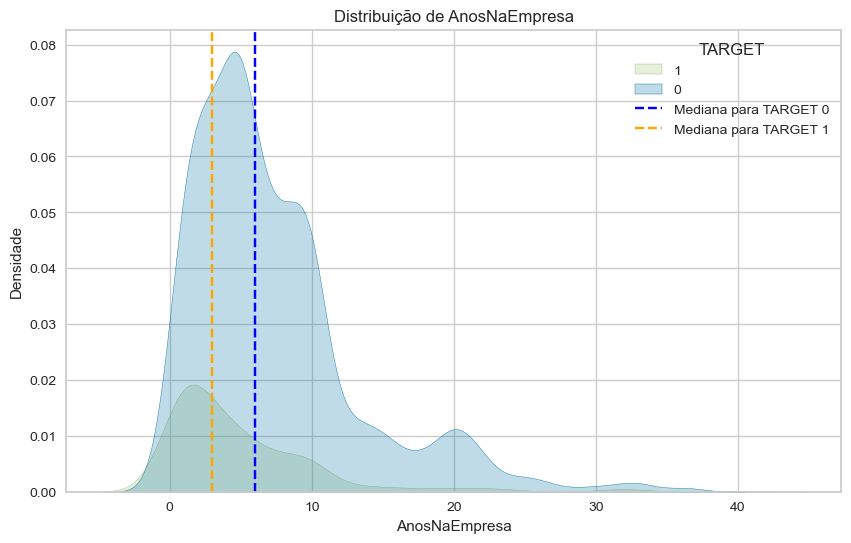

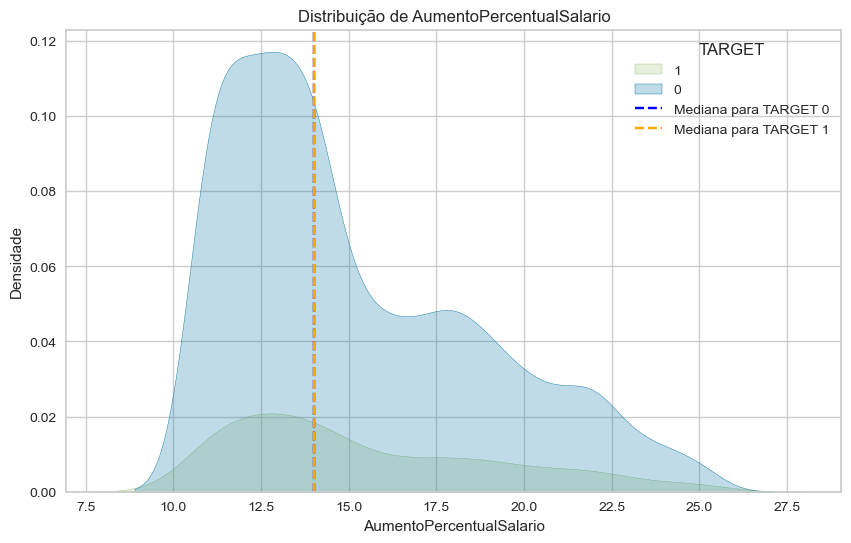

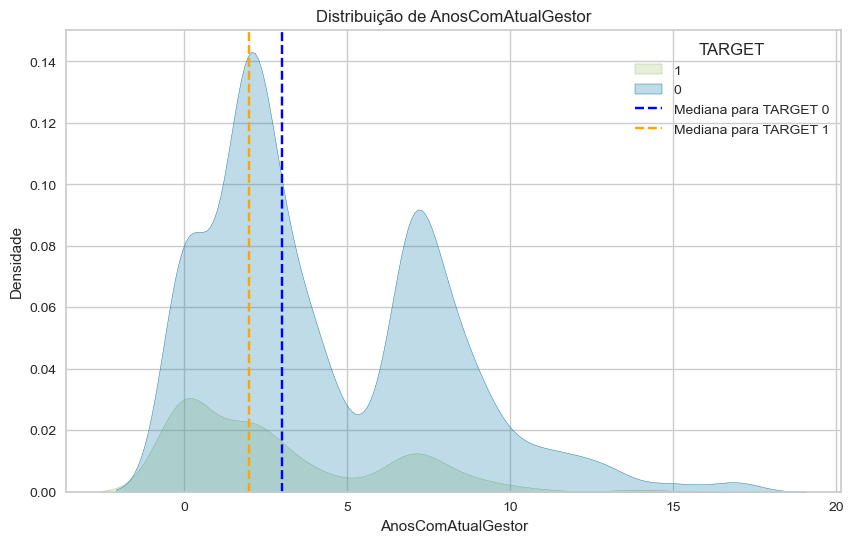

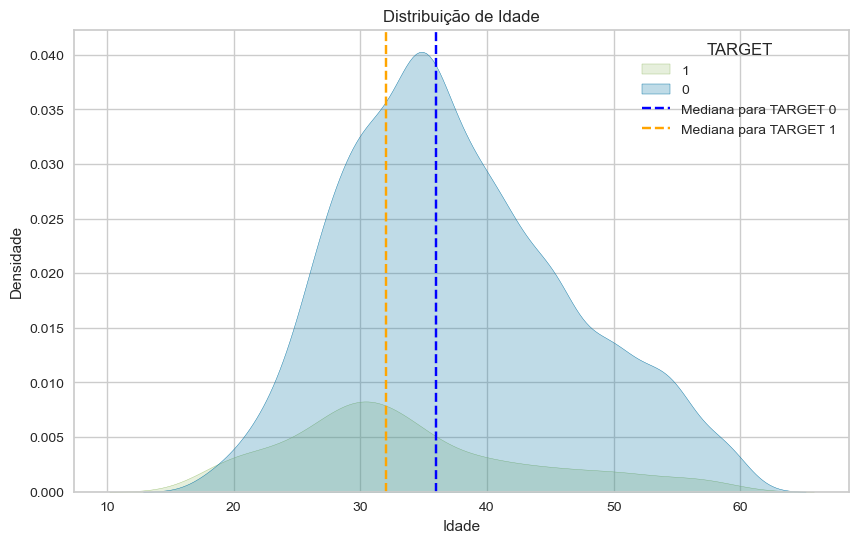

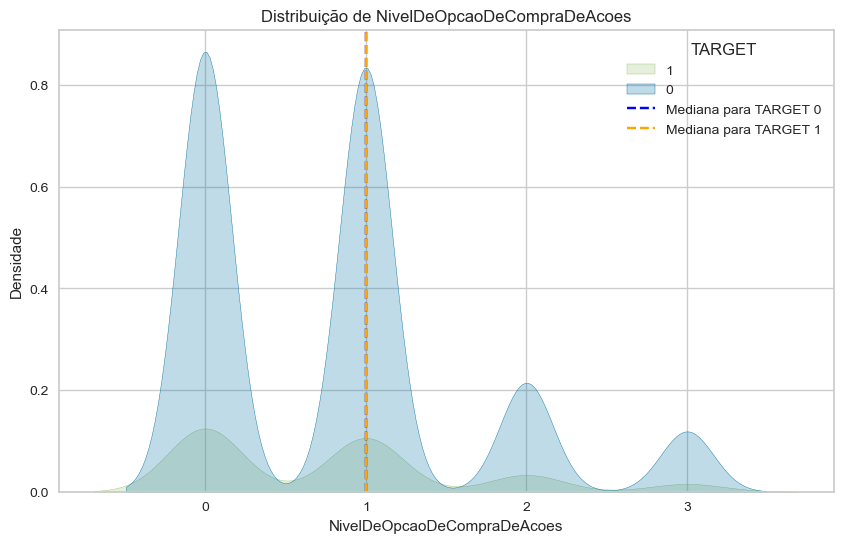

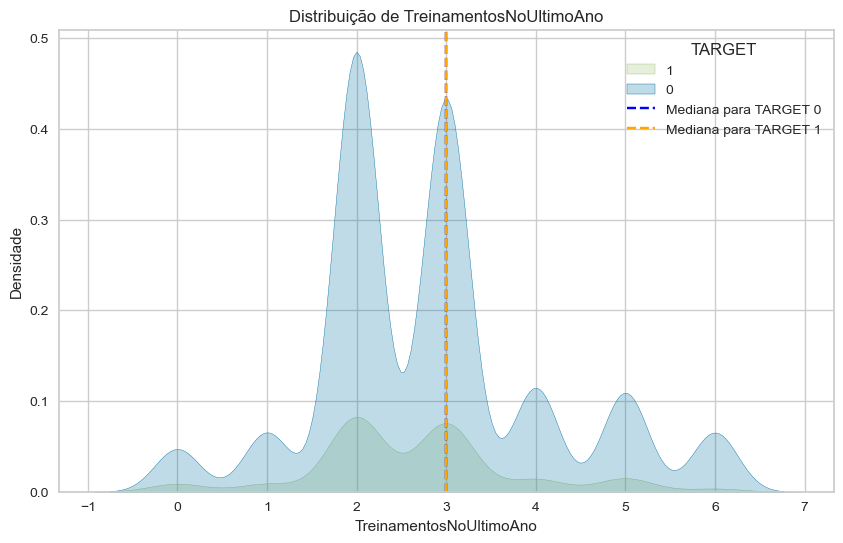

In [40]:
for var in num_vars:

  # Calcular as medianas para cada grupo
  medianas = abt.groupby('TARGET')[var].median()

  colors = ['blue','orange']
  i = 0

  plt.figure(figsize=(10, 6))
  sns.kdeplot(data=abt, x=var, hue='TARGET', fill=True, warn_singular=False)

  # Adicionar linhas verticais representando as medianas
  for target, mediana in medianas.items():
      plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TARGET {target}')
      i += 1

  plt.title(f'Distribuição de {var}')
  plt.ylabel('Densidade')
  plt.xlabel(f'{var}')
  plt.legend(title='TARGET', loc='upper right', labels=['1', '0', 'Mediana para TARGET 0', 'Mediana para TARGET 1'])
  plt.show()

## Split

In [41]:
from sklearn.model_selection import train_test_split

X = abt.drop(columns= ['Rotatividade', 'TARGET', 'IDDoEmpregado']).copy()
y = abt['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 0)

In [42]:
display((X_train.shape, y_train.shape))
display((X_test.shape, y_test.shape))

((3528, 28), (3528,))

((882, 28), (882,))

## Data Preparation

In [43]:
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

* Separando as variáveis (numericas/categóricas) para os conjuntos de Treino e Teste

In [44]:
# Variaveis Numericas: num_vars
# Variaveis Categóricas: cat_vars

# Filtrando as colunas numéricas e categoricas: Set de Treino
num_vars_train = X_train[num_vars].copy()
cat_vars_train = X_train[cat_vars].copy()


# Filtrando as colunas numéricas e categoricas: Set de Teste
num_vars_test = X_test[num_vars].copy()
cat_vars_test = X_test[cat_vars].copy()

* ``Tratando Missings`` (Numericos e Categoricos) para os conjuntos de Treino e Teste

In [45]:
# Definindo o Imputer para as variáveis numéricas e categóricas (Tratamento de Missings)
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

#-------Numerical

# Preenchendo os Missings: Numéricos (Treino e Teste)
abt_train = pd.DataFrame(
    imputer_num.fit_transform(num_vars_train),
    columns= num_vars_train.columns,
    index= num_vars_train.index
)

abt_test = pd.DataFrame(
    imputer_num.transform(num_vars_test),
    columns = num_vars_test.columns,
    index = num_vars_test.index
)

# Atualizando os Sets
num_vars_train = abt_train.copy()
num_vars_test = abt_test.copy()

#-------Categorical

# Preenchendo os Missings: Categóricos (Treino e Teste)
abt_train = pd.DataFrame(
    imputer_cat.fit_transform(cat_vars_train),
    columns = cat_vars_train.columns,
    index = cat_vars_train.index

)

abt_test = pd.DataFrame(
    imputer_cat.transform(cat_vars_test),
    columns = cat_vars_test.columns,
    index = cat_vars_test.index
)

# Atualizando os Sets
cat_vars_train = abt_train.copy()
cat_vars_test = abt_test.copy()

* Aplicando Encoding nas Variáveis Categóricas (Target Encoding - Treino & Teste)

In [46]:
# Instanciando o Encoder
ce = TargetEncoder()

# Aplicando o Encoder - Treino e Teste
cat_vars_train = ce.fit_transform(cat_vars_train, y_train)
cat_vars_test = ce.transform(cat_vars_test, y_test)

* Criando novo DataFrame com o resultado das operações

In [47]:
abt_train = pd.concat([num_vars_train, cat_vars_train], axis=1)
abt_test = pd.concat([num_vars_test, cat_vars_test], axis=1)

## Feature Selection

In [48]:
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold

* Etapa 1 - Removendo Variáveis com Baixa Variância

In [49]:
# Remoção de variáveis com zero variância

selector = VarianceThreshold(threshold=0)
selector.fit_transform(abt_train)

# Colunas selecionadas
selected_features = abt_train.columns[selector.get_support()]

# Manter apenas features selecionadas
abt_train02 = abt_train[selected_features]
abt_test02 = abt_test[selected_features]

* Etapa 2 - Removendo Variáveis com Alta Correlação

In [50]:
# Definindo um valor de corte
threshold = 0.8

# Calculando a matriz de correlação
corr_matrix = abt_train02.corr().abs()

# Eliminando a diagonal inferior
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identificando as variáveis que possuem correlação > que o valor de corte
vars_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]

# Atualizando a ABT
abt_train03 = abt_train02.drop(columns= vars_to_drop)
abt_test03 = abt_test02.drop(columns= vars_to_drop)

* Etapa 3 - Filtro por Feature Importance

In [51]:
# Instanciando o modelo
xgb_model = XGBClassifier(random_state = 0)

# Fittando o modelo
xgb_model.fit(abt_train03, y_train)

# Criando uma tabela com a feature importance
importances_df = pd.DataFrame({
    'Feature' : abt_train03.columns,
    'Importance' : xgb_model.feature_importances_
})

# Selecionando as 20 melhores variáveis
best_vars = importances_df.sort_values(by= 'Importance', ascending= False)[:20].Feature.tolist()

# Atualizando nossa abt
abt_train04 = abt_train03[best_vars].copy()
abt_test04 = abt_test03[best_vars].copy()

In [52]:
# Criando a ABT Final

abt_final_train = pd.concat((abt_train04, y_train), axis=1)
abt_final_test = pd.concat((abt_test04, y_test), axis=1)

## Verificando Linearidade com a Log da Odds

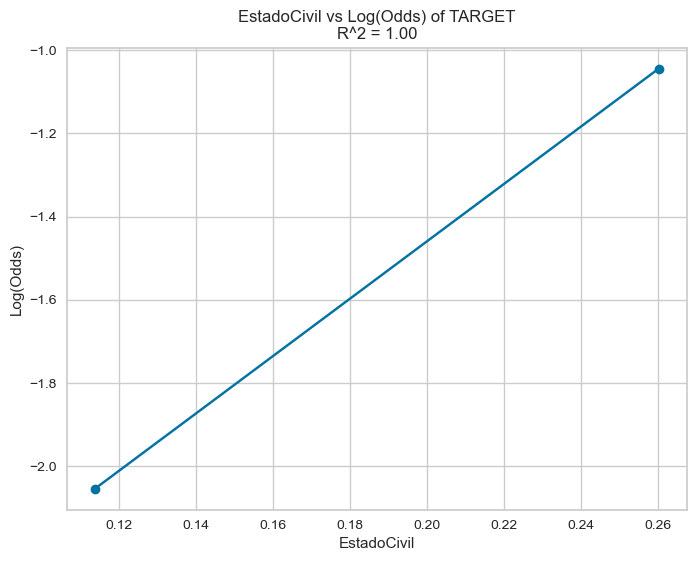

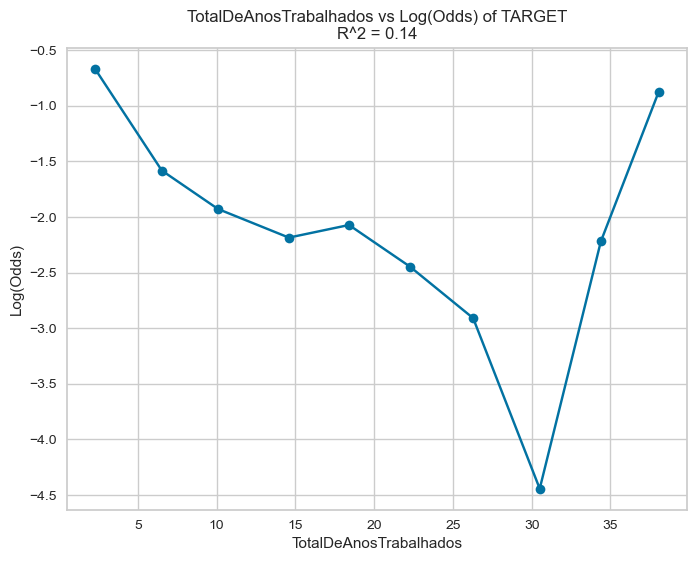

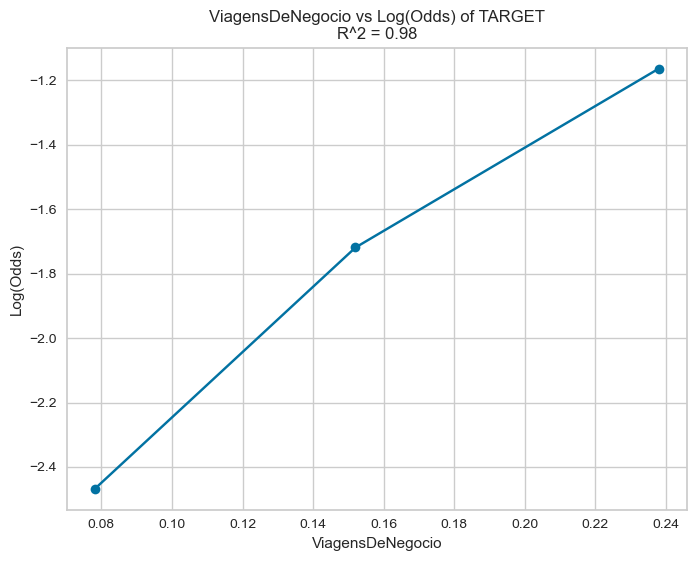

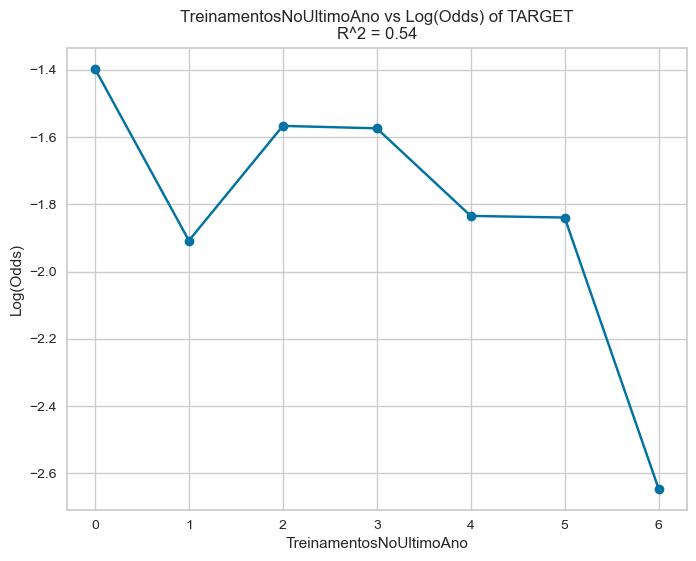

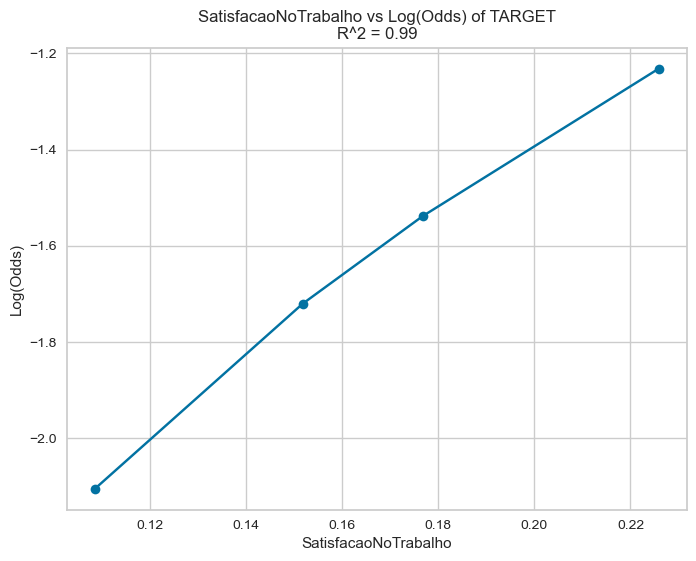

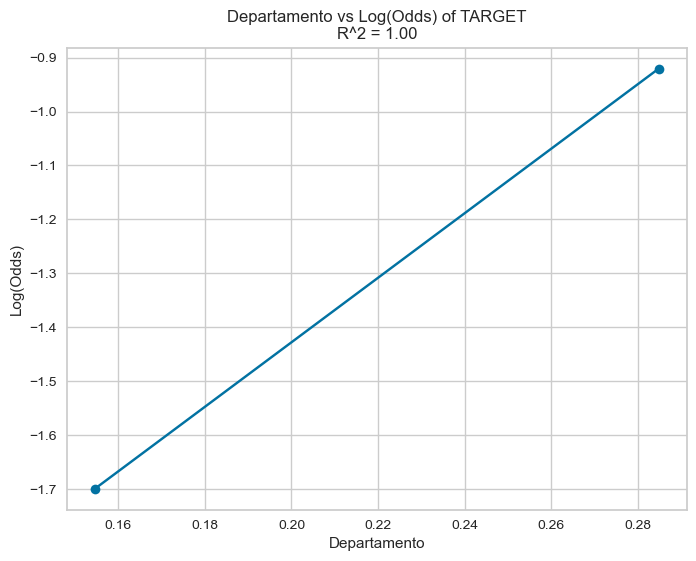

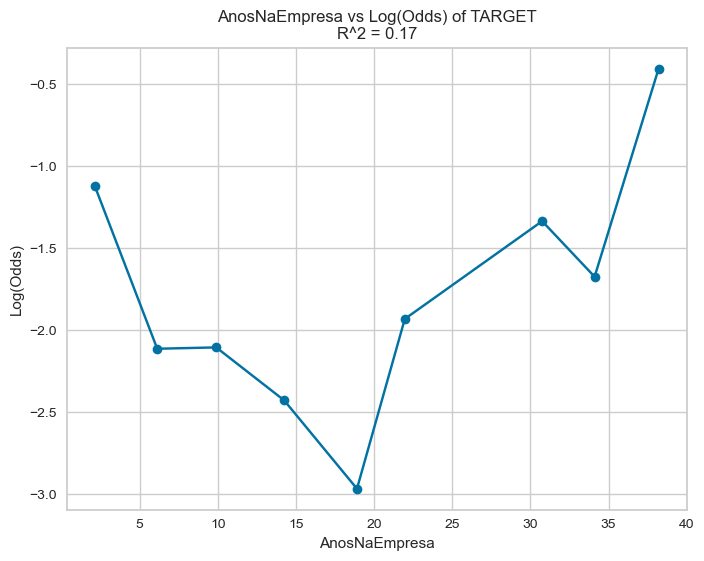

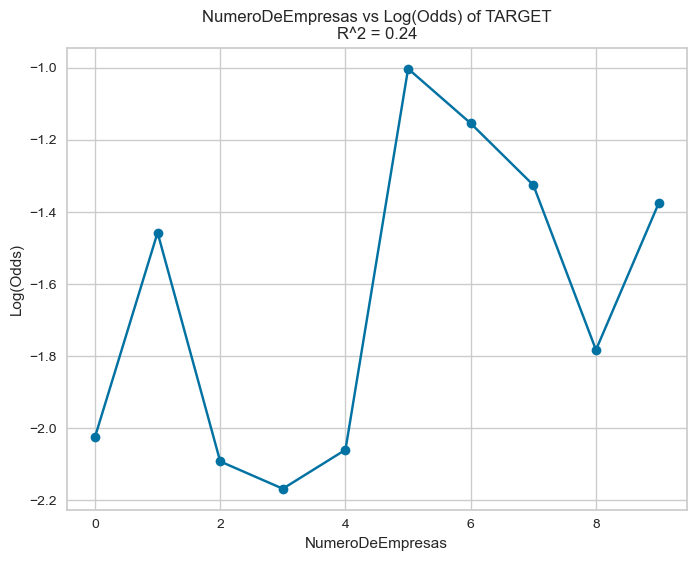

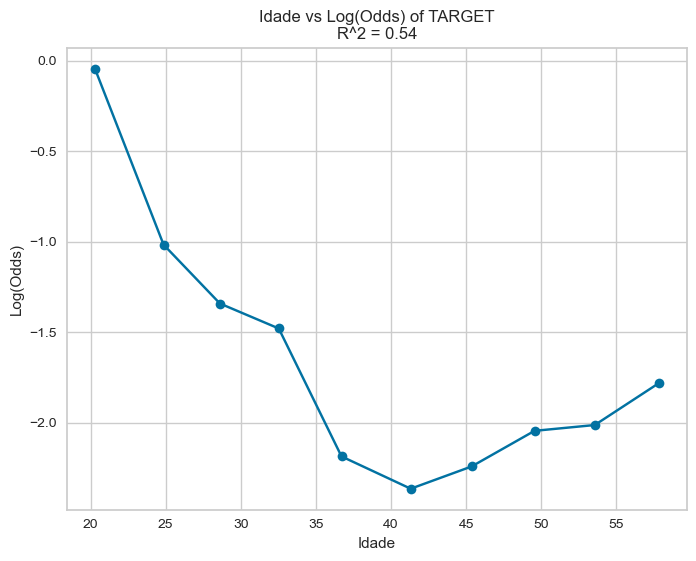

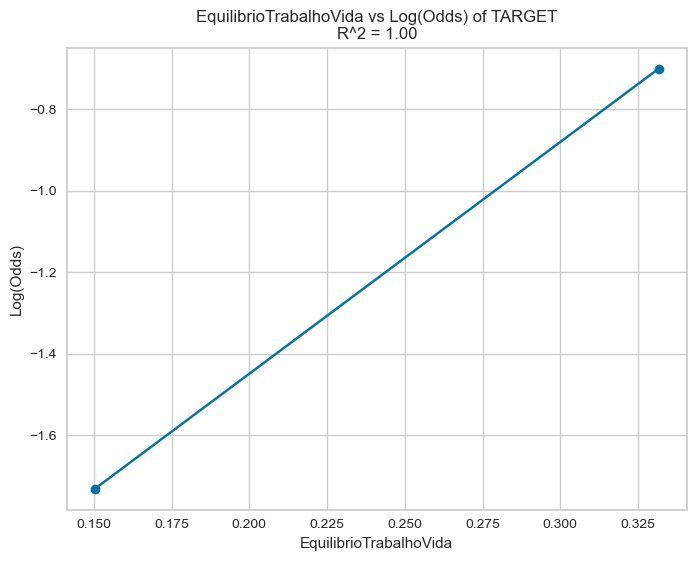

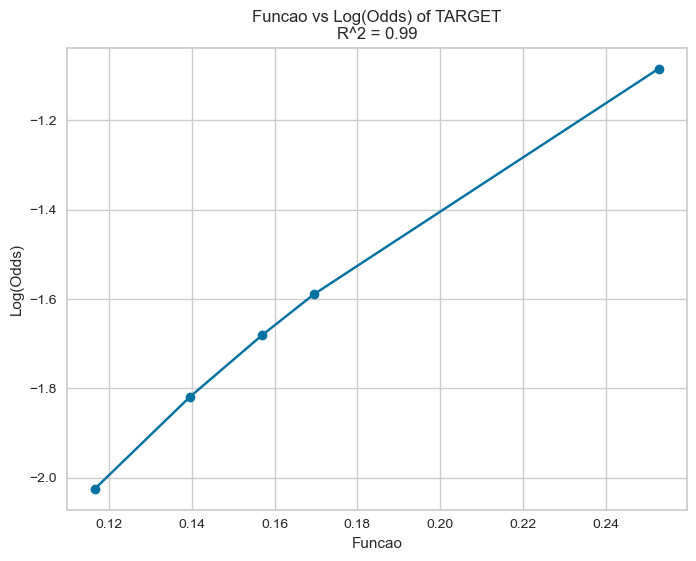

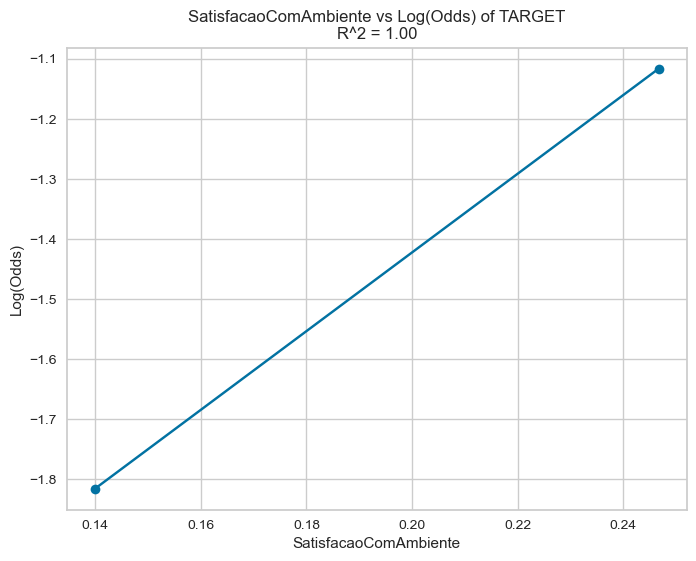

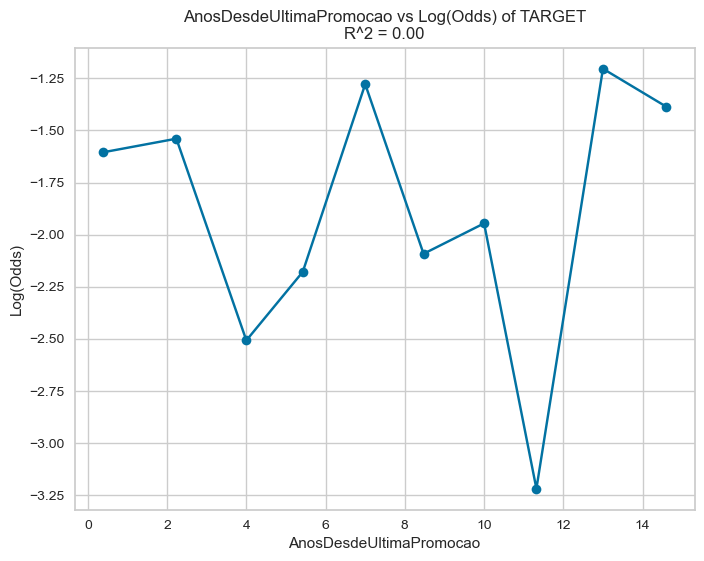

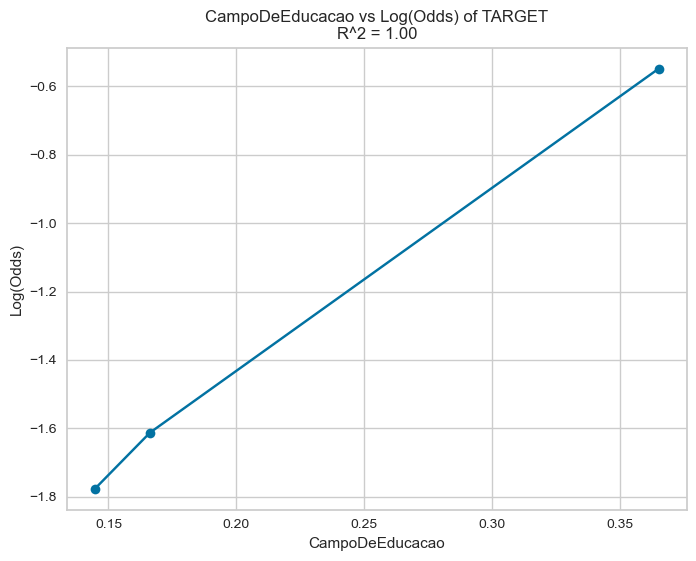

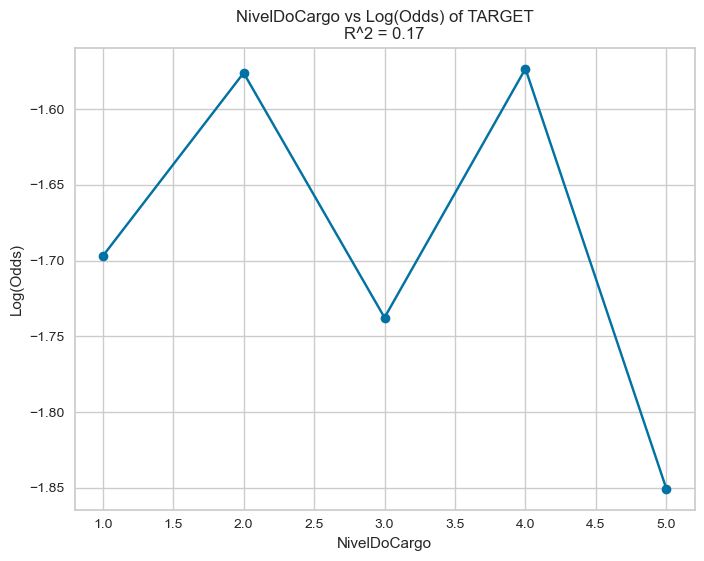

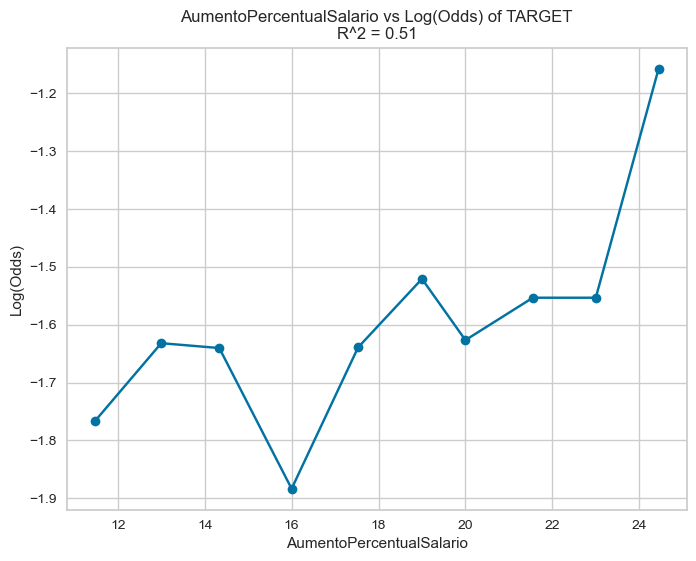

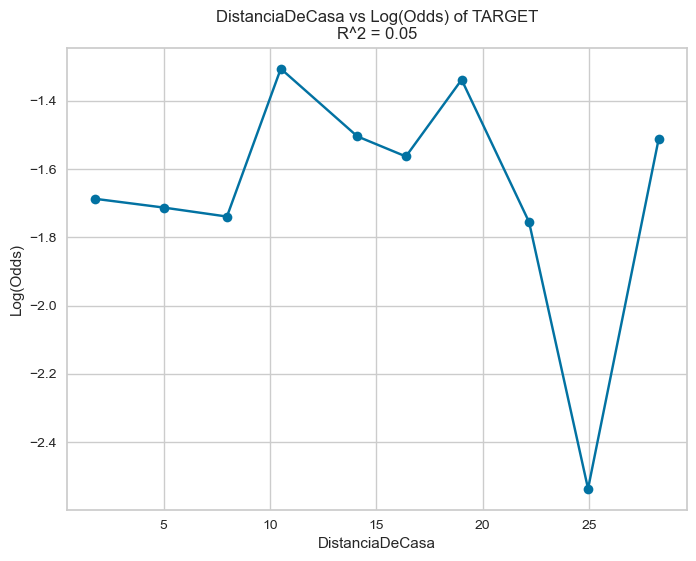

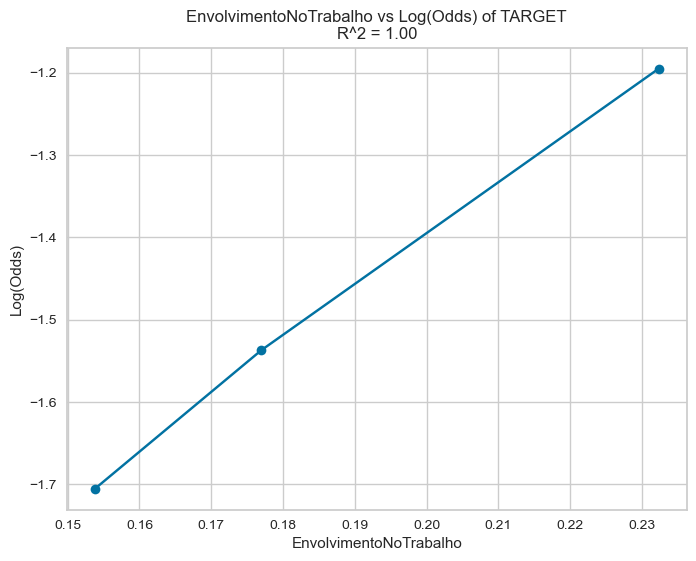

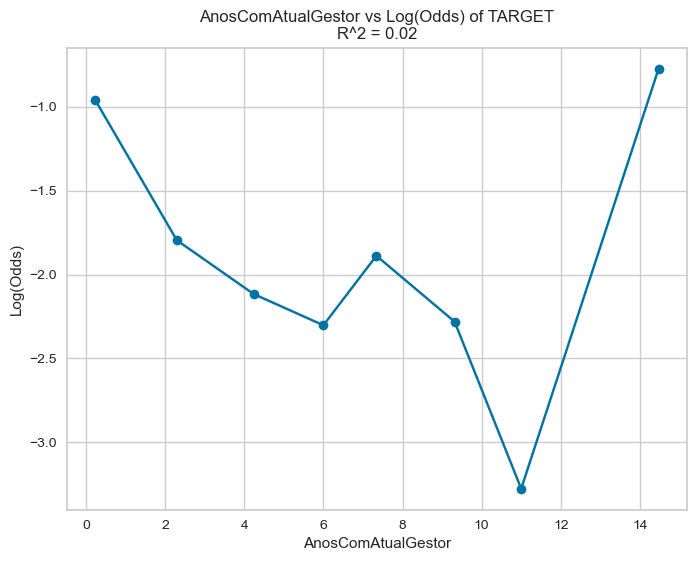

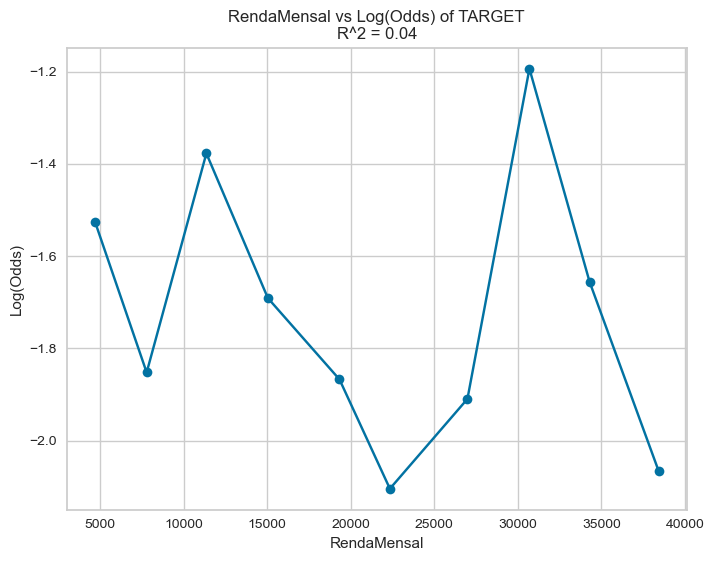

In [53]:
plot_variable_vs_logodds(abt_final_train, abt_final_train.drop(columns= ['TARGET']).columns.tolist(), 'TARGET')

* Criando a Tabela para tomada de decisão acerca das variáveis

In [54]:
lin_df = calculate_r2_for_logodds(
    abt_final_train,
    abt_final_train.drop(columns = ['TARGET']).columns.tolist(),
    'TARGET',
    threshold=0.85
)

lin_df.loc[lin_df['Variable'].isin(cat_vars), 'Feat Eng'] = 'Categorizar'

In [55]:
lin_df

Variable    R^2     Feat Eng
0                EstadoCivil 1.0000  Categorizar
1     TotalDeAnosTrabalhados 0.1436  Categorizar
2           ViagensDeNegocio 0.9834  Categorizar
3    TreinamentosNoUltimoAno 0.5403  Categorizar
4       SatisfacaoNoTrabalho 0.9907  Categorizar
5               Departamento 1.0000  Categorizar
6              AnosNaEmpresa 0.1738  Categorizar
7           NumeroDeEmpresas 0.2392  Categorizar
8                      Idade 0.5426  Categorizar
9     EquilibrioTrabalhoVida 1.0000  Categorizar
10                    Funcao 0.9911  Categorizar
11     SatisfacaoComAmbiente 1.0000  Categorizar
12   AnosDesdeUltimaPromocao 0.0004  Categorizar
13           CampoDeEducacao 0.9988  Categorizar
14              NivelDoCargo 0.1694  Categorizar
15  AumentoPercentualSalario 0.5107  Categorizar
16           DistanciaDeCasa 0.0539  Categorizar
17    EnvolvimentoNoTrabalho 0.9985  Categorizar
18        AnosComAtualGestor 0.0221  Categorizar
19               RendaMensal 0.0441  Categorizar

In [56]:
cont_vars = lin_df[lin_df['Feat Eng'] == 'Usar como contínua']['Variable'].tolist()
categorize_vars = lin_df[lin_df['Feat Eng'] == 'Categorizar']['Variable'].tolist()

## Transformando e Categorizando Variáveis

* As variáveis que tiveram baixa linearidade serão transformadas (utilizando alguma operação matemática) para tentar melhorar sua linearidade

* Após esse processo, irei categorizar as demais variáveis

In [57]:
transform_results = calculate_r2_for_logodds_and_transformations(
    df = abt_final_train,
    variables= categorize_vars,
    target= 'TARGET',
    threshold= 0.85
)

transform_results.loc[transform_results['Variable'].isin(cat_vars), 'Feat Eng'] = 'Categorizar'

In [58]:
transform_results

Variable Best Transformation  R^2 of Transformation  \
0                EstadoCivil              AbsLog                 1.0000   
1     TotalDeAnosTrabalhados              AbsLog                 0.7282   
2           ViagensDeNegocio              AbsLog                 0.9834   
3    TreinamentosNoUltimoAno           Quadratic                 0.7115   
4       SatisfacaoNoTrabalho           Quadratic                 0.9931   
5               Departamento              AbsLog                 1.0000   
6              AnosNaEmpresa              AbsLog                 0.1649   
7           NumeroDeEmpresas              AbsLog                 0.3293   
8                      Idade              AbsLog                 0.6460   
9     EquilibrioTrabalhoVida              AbsLog                 1.0000   
10                    Funcao           Quadratic                 0.9932   
11     SatisfacaoComAmbiente              AbsLog                 1.0000   
12   AnosDesdeUltimaPromocao           Quadratic                 0.0116   
13           CampoDeEducacao           Quadratic                 1.0000   
14              NivelDoCargo           Quadratic                 0.2495   
15  AumentoPercentualSalario           Quadratic                 0.4758   
16           DistanciaDeCasa           Quadratic                 0.2059   
17    EnvolvimentoNoTrabalho              AbsLog                 0.9985   
18        AnosComAtualGestor              AbsLog                 0.5984   
19               RendaMensal              AbsLog                 0.1337   

       Feat Eng              Transformation Equation  
0   Categorizar                  AbsLog(EstadoCivil)  
1   Categorizar       AbsLog(TotalDeAnosTrabalhados)  
2   Categorizar             AbsLog(ViagensDeNegocio)  
3   Categorizar   Quadratic(TreinamentosNoUltimoAno)  
4   Categorizar      Quadratic(SatisfacaoNoTrabalho)  
5   Categorizar                 AbsLog(Departamento)  
6   Categorizar                AbsLog(AnosNaEmpresa)  
7   Categorizar             AbsLog(NumeroDeEmpresas)  
8   Categorizar                        AbsLog(Idade)  
9   Categorizar       AbsLog(EquilibrioTrabalhoVida)  
10  Categorizar                    Quadratic(Funcao)  
11  Categorizar        AbsLog(SatisfacaoComAmbiente)  
12  Categorizar   Quadratic(AnosDesdeUltimaPromocao)  
13  Categorizar           Quadratic(CampoDeEducacao)  
14  Categorizar              Quadratic(NivelDoCargo)  
15  Categorizar  Quadratic(AumentoPercentualSalario)  
16  Categorizar           Quadratic(DistanciaDeCasa)  
17  Categorizar       AbsLog(EnvolvimentoNoTrabalho)  
18  Categorizar           AbsLog(AnosComAtualGestor)  
19  Categorizar                  AbsLog(RendaMensal)

In [59]:
abt_final_train_transform = apply_best_transformations(
    transform_results,
    abt_final_train,
    drop_original= True
)

abt_final_test_transform = apply_best_transformations(
    transform_results,
    abt_final_test,
    drop_original= True
)

In [60]:
lin_df = calculate_r2_for_logodds(
    abt_final_train_transform,
    abt_final_train_transform.drop(columns = ['TARGET']),
    'TARGET',
    threshold= 0.85
)
lin_df.loc[lin_df['Variable'].isin(cat_vars), 'Feat Eng'] = 'Categorizar'

categorize_vars = lin_df.loc[lin_df['Feat Eng'] == 'Categorizar', 'Variable'].tolist()

meta_df = generate_metadata(abt_final_train_transform[categorize_vars])

In [61]:
meta_df.loc[meta_df['cardinalidade'] <= 20, 'nome_variavel'].tolist()

['EstadoCivil',
 'AnosComAtualGestor',
 'EnvolvimentoNoTrabalho',
 'AumentoPercentualSalario',
 'NivelDoCargo',
 'CampoDeEducacao',
 'AnosDesdeUltimaPromocao',
 'SatisfacaoComAmbiente',
 'Funcao',
 'EquilibrioTrabalhoVida',
 'NumeroDeEmpresas',
 'Departamento',
 'SatisfacaoNoTrabalho',
 'TreinamentosNoUltimoAno',
 'ViagensDeNegocio']

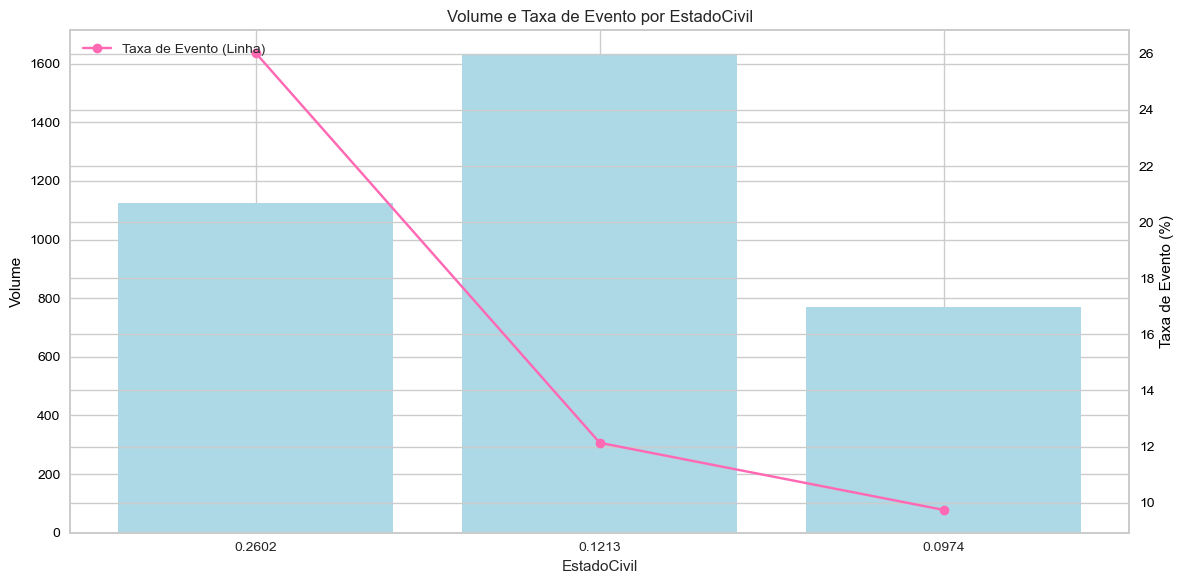

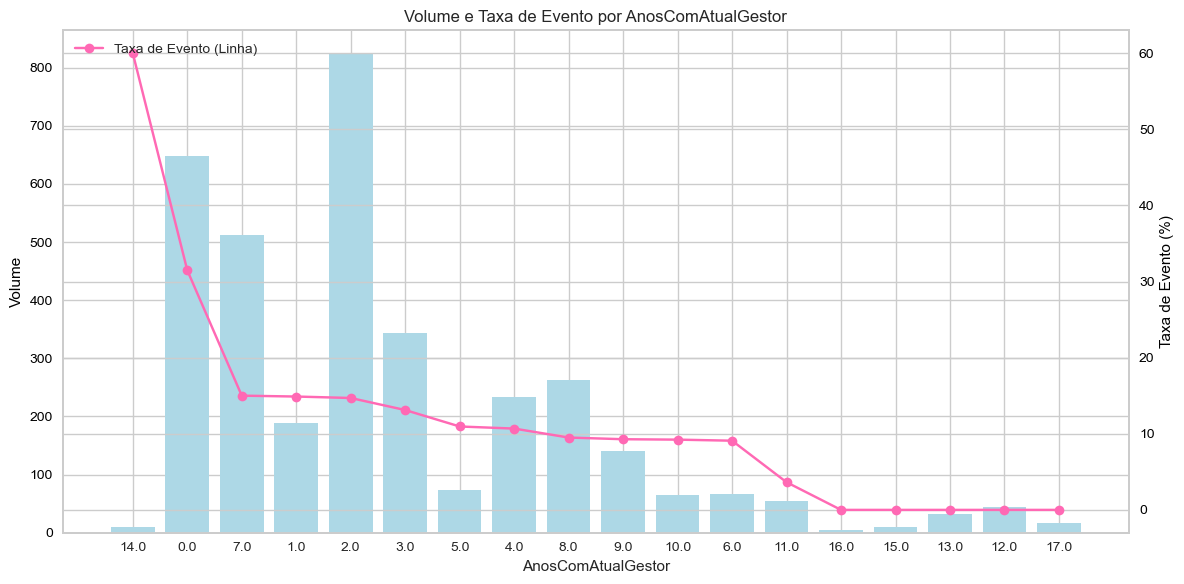

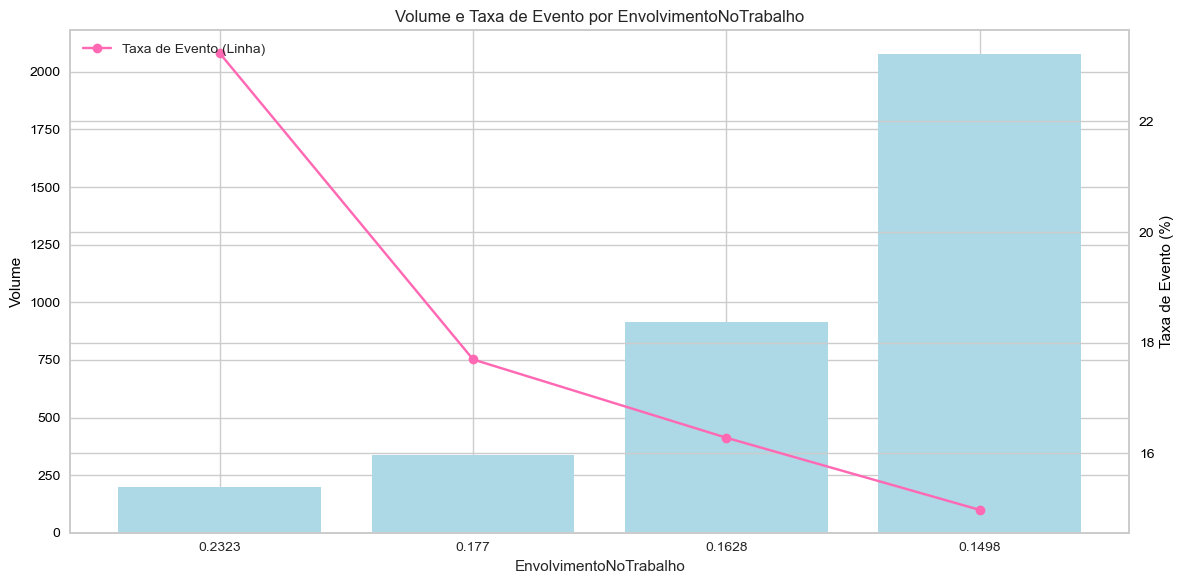

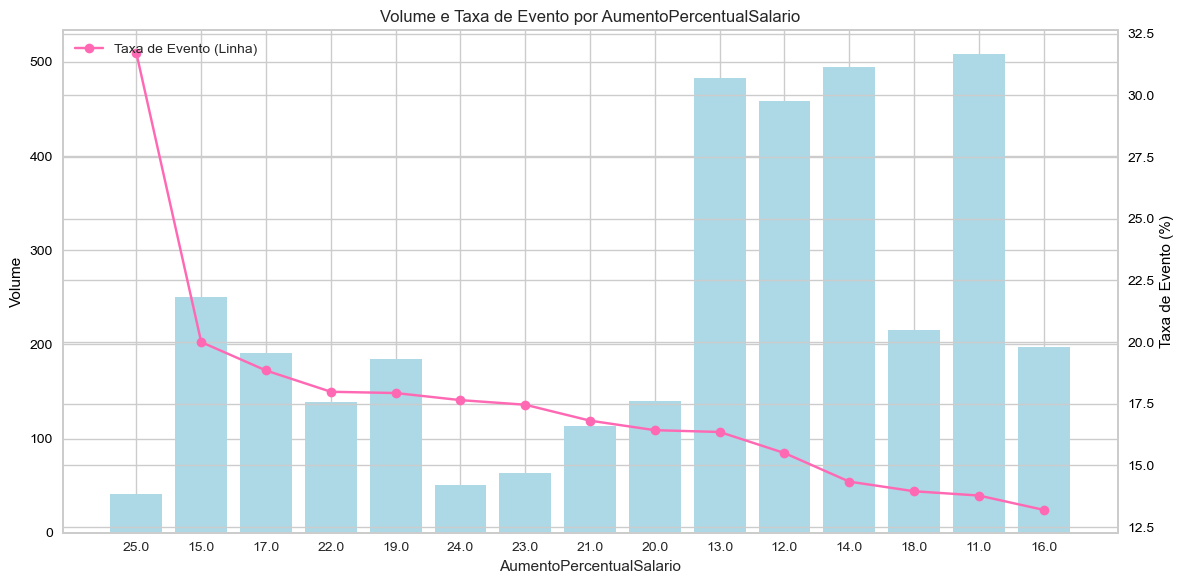

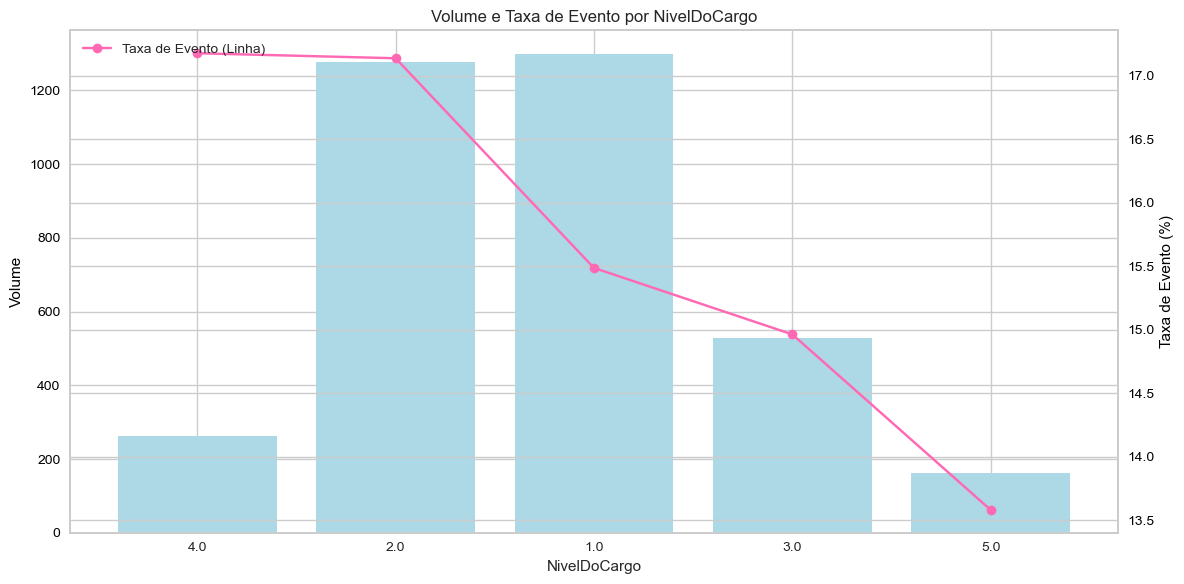

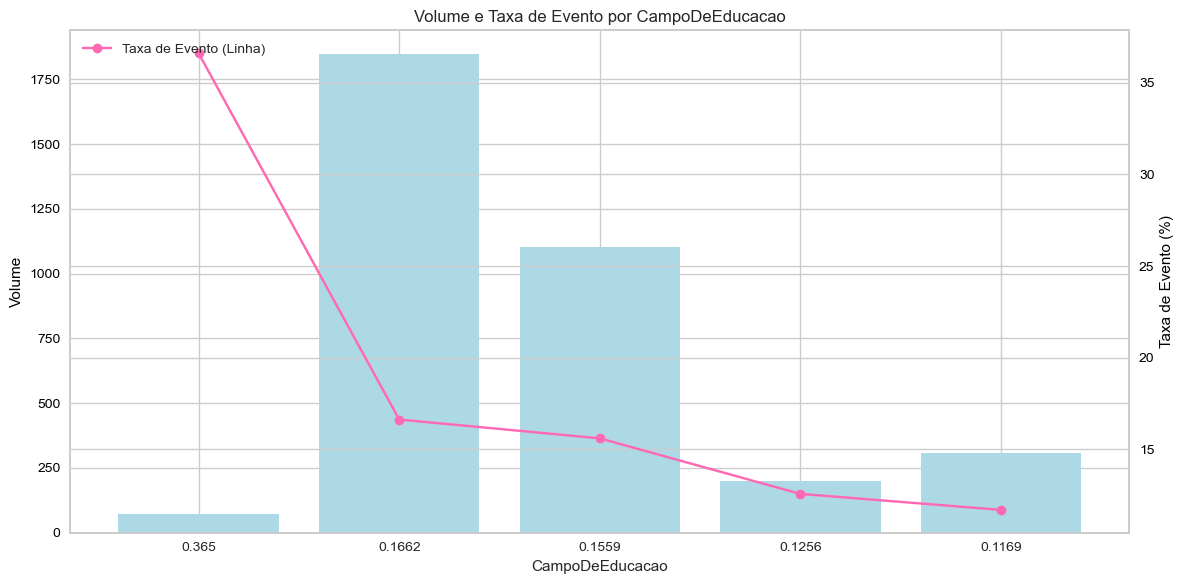

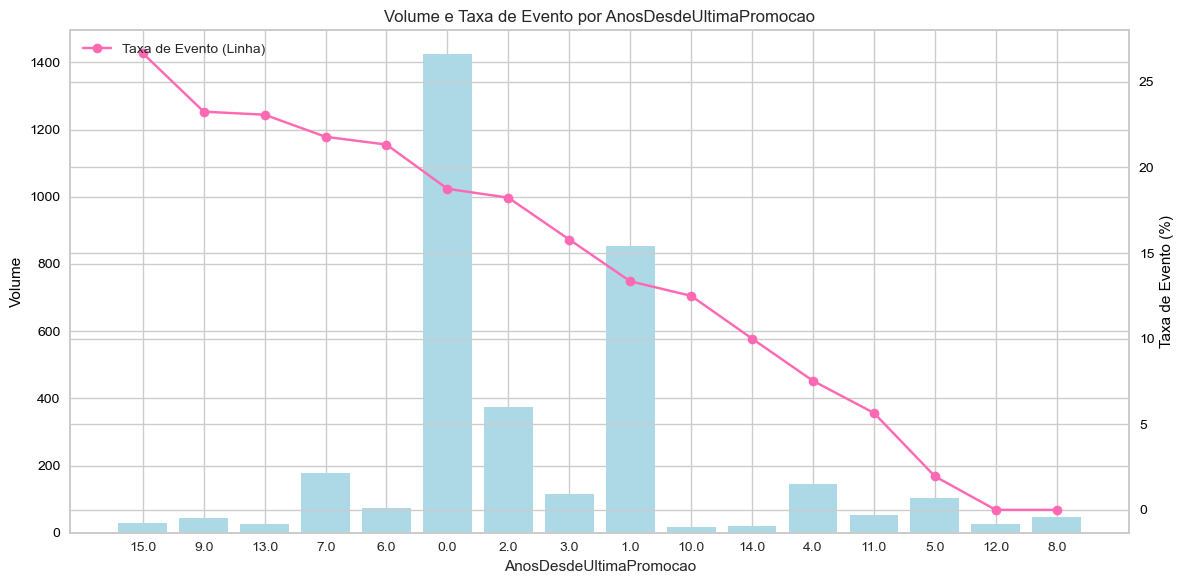

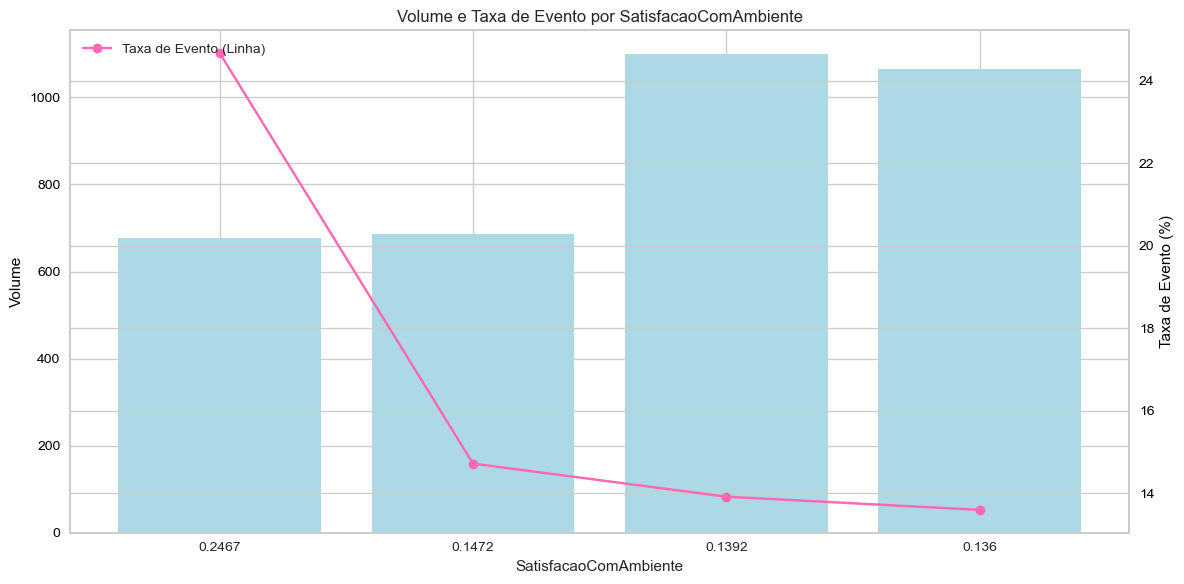

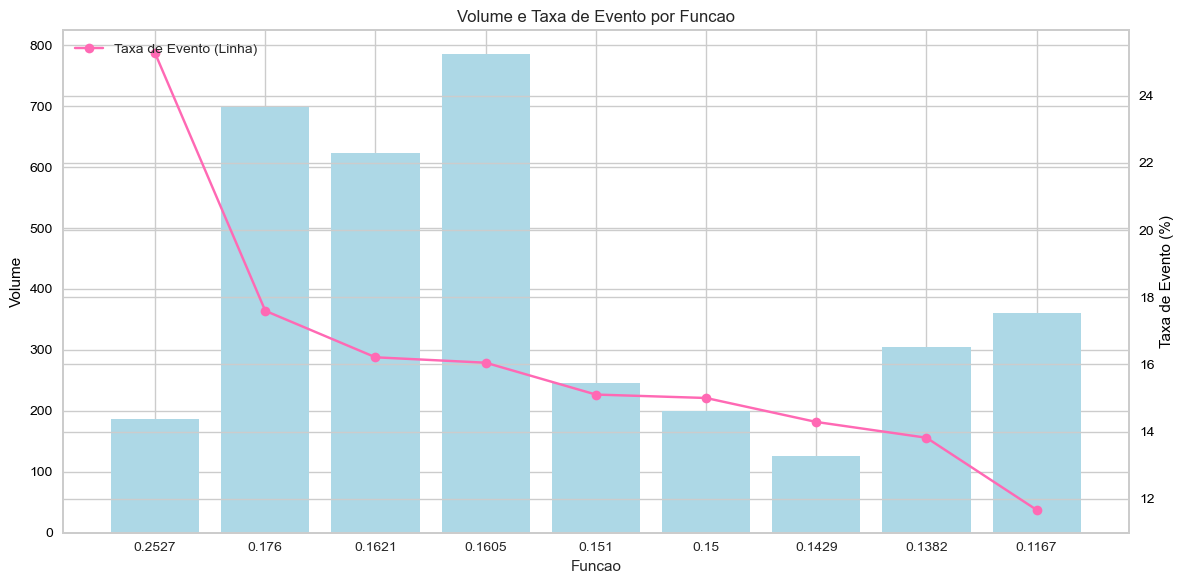

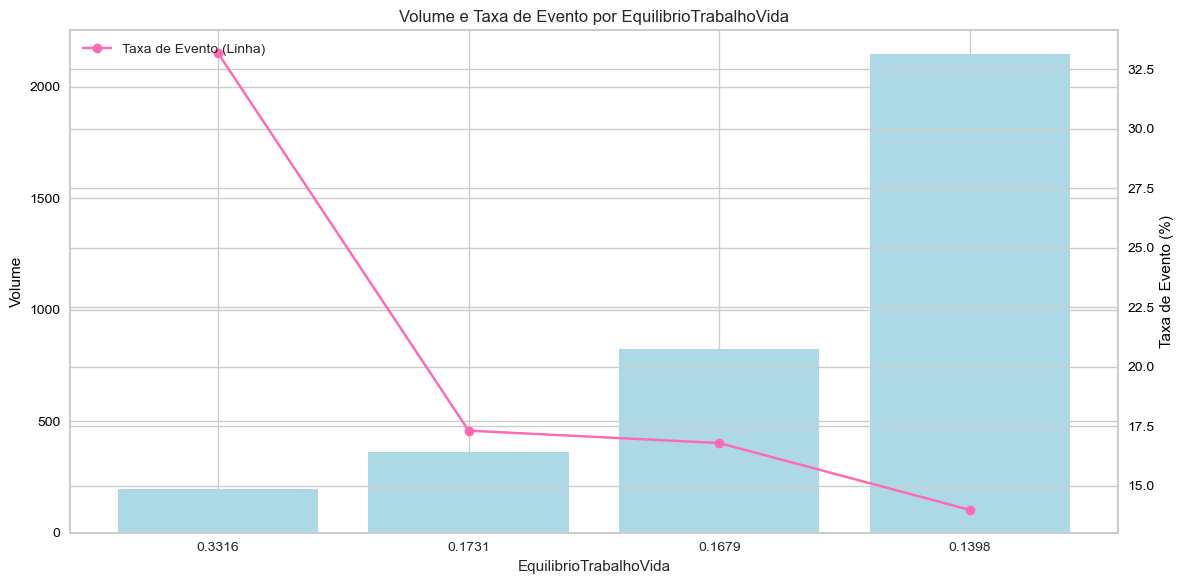

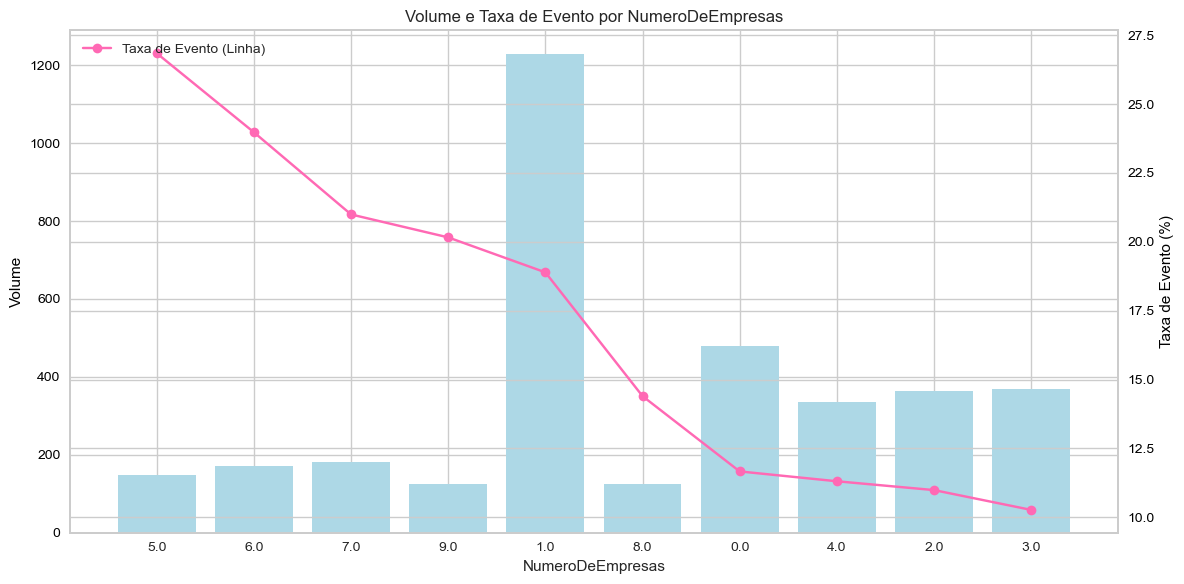

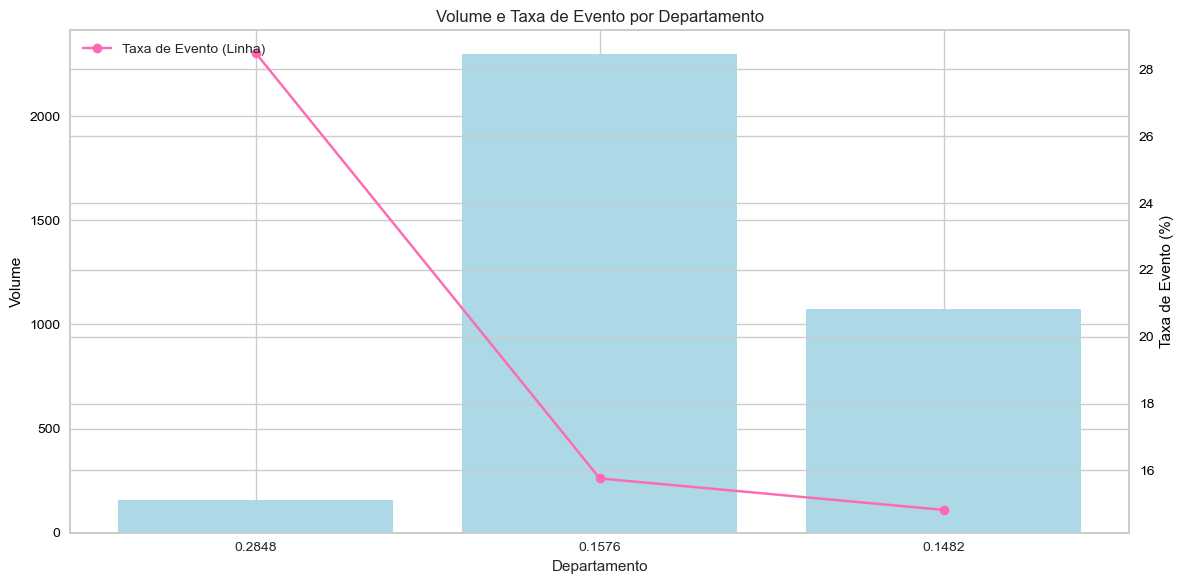

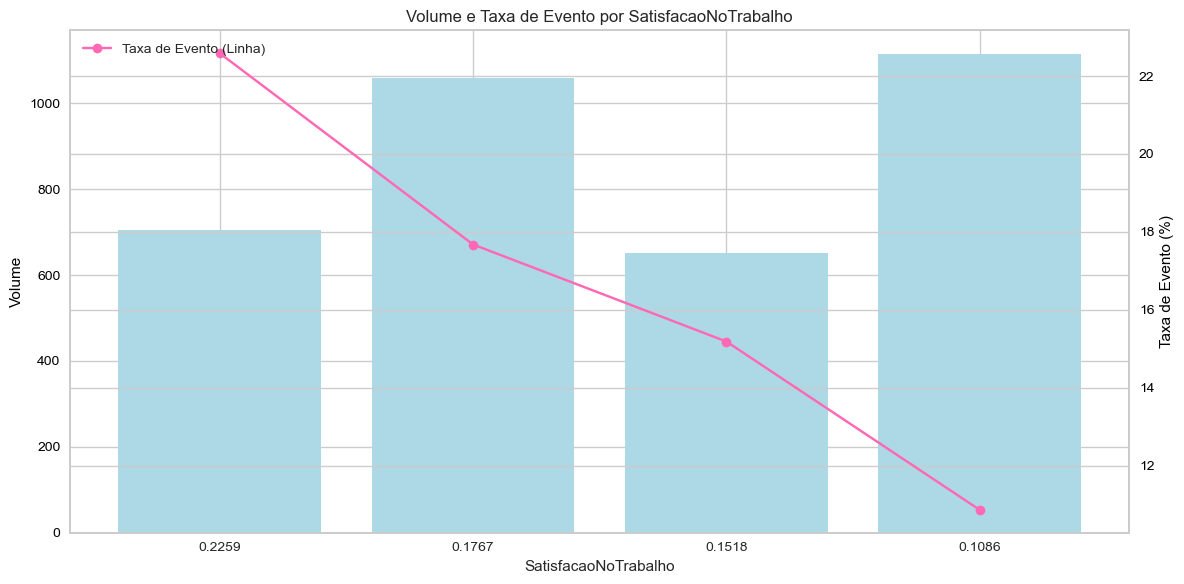

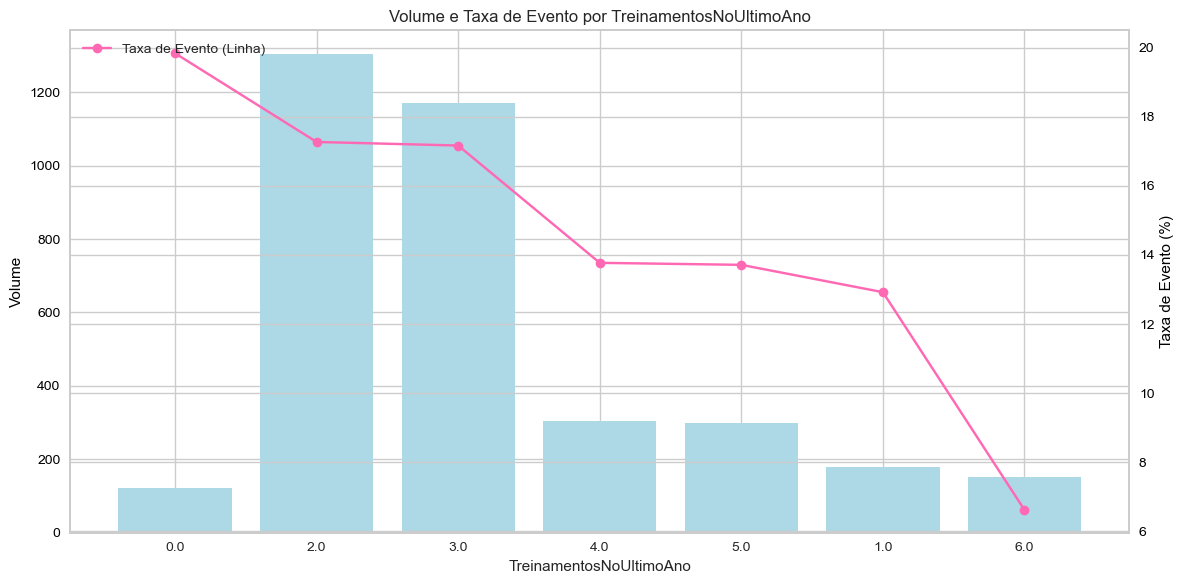

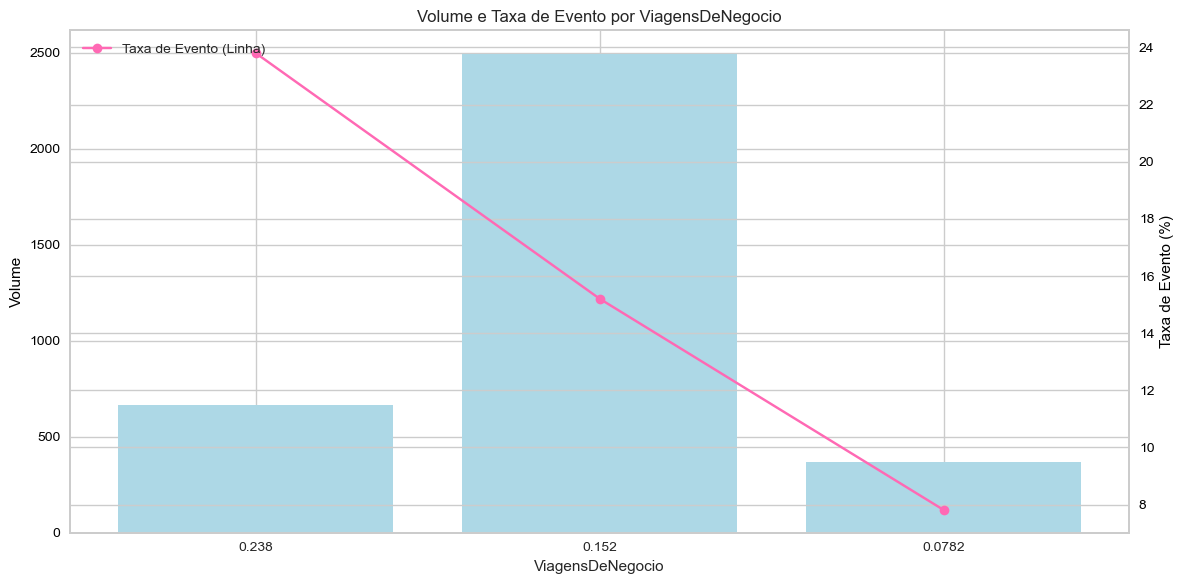

In [62]:
for _ in meta_df.loc[meta_df['cardinalidade'] <= 20, 'nome_variavel'].tolist():

    analyze_variable(
        abt_final_train_transform,
        _,
        'TARGET'
    )

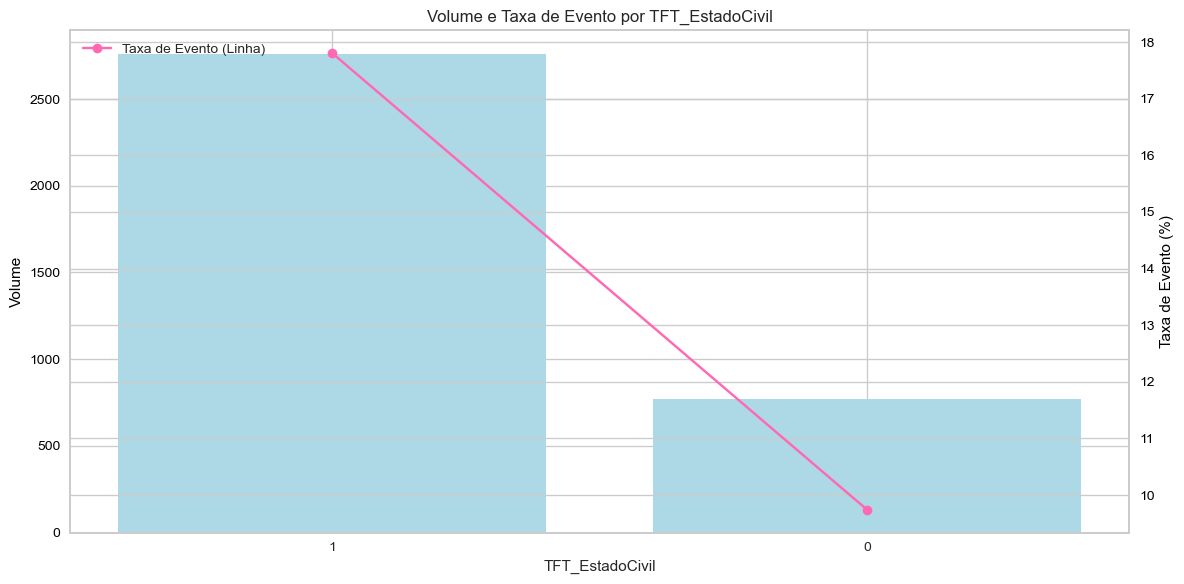

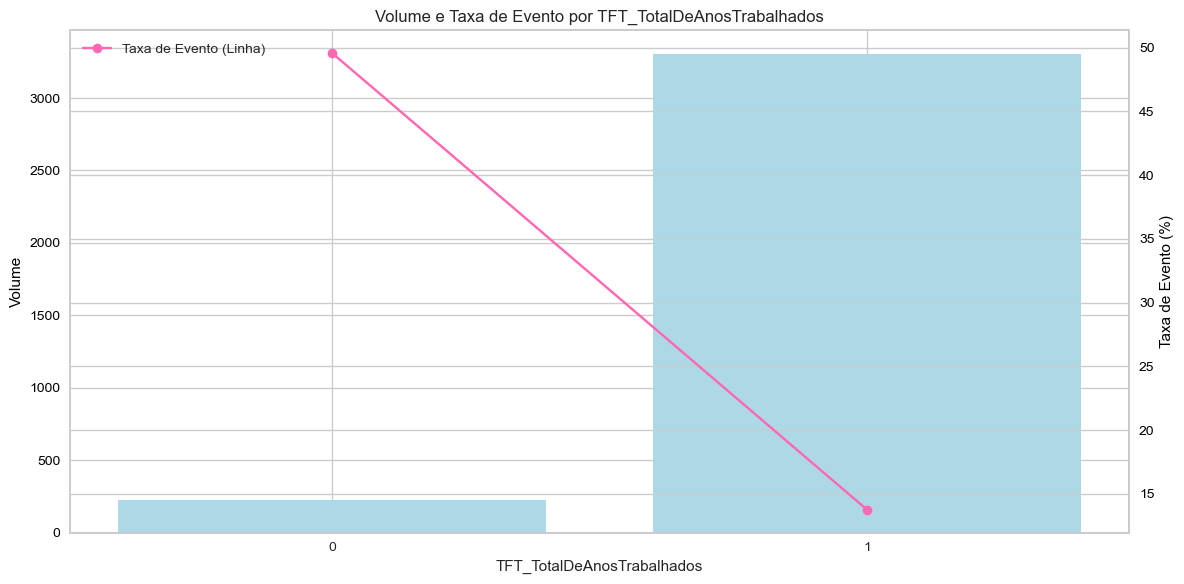

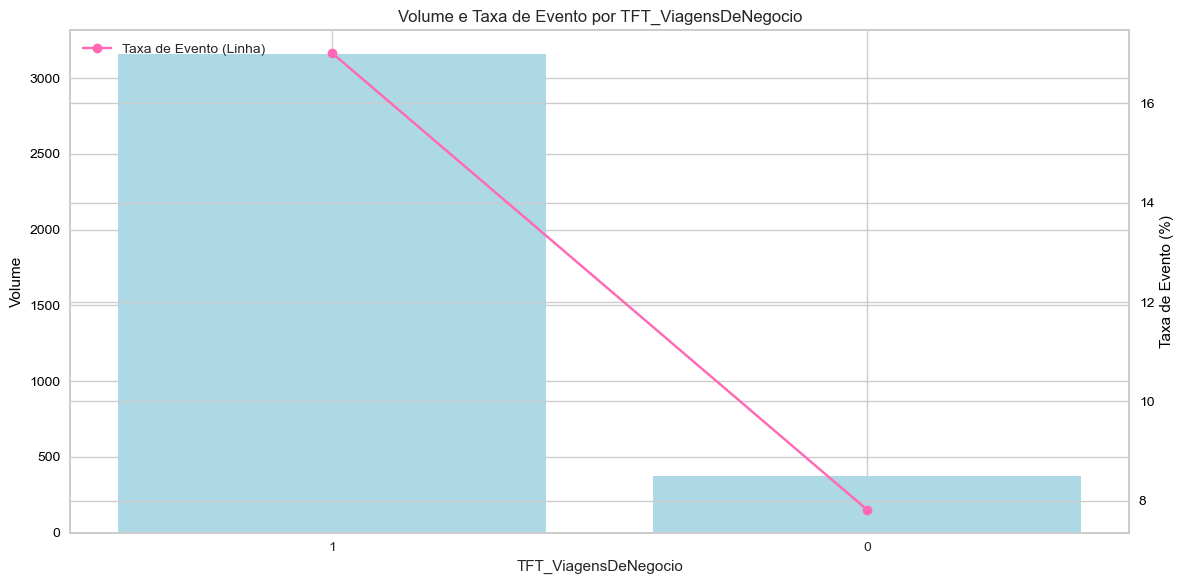

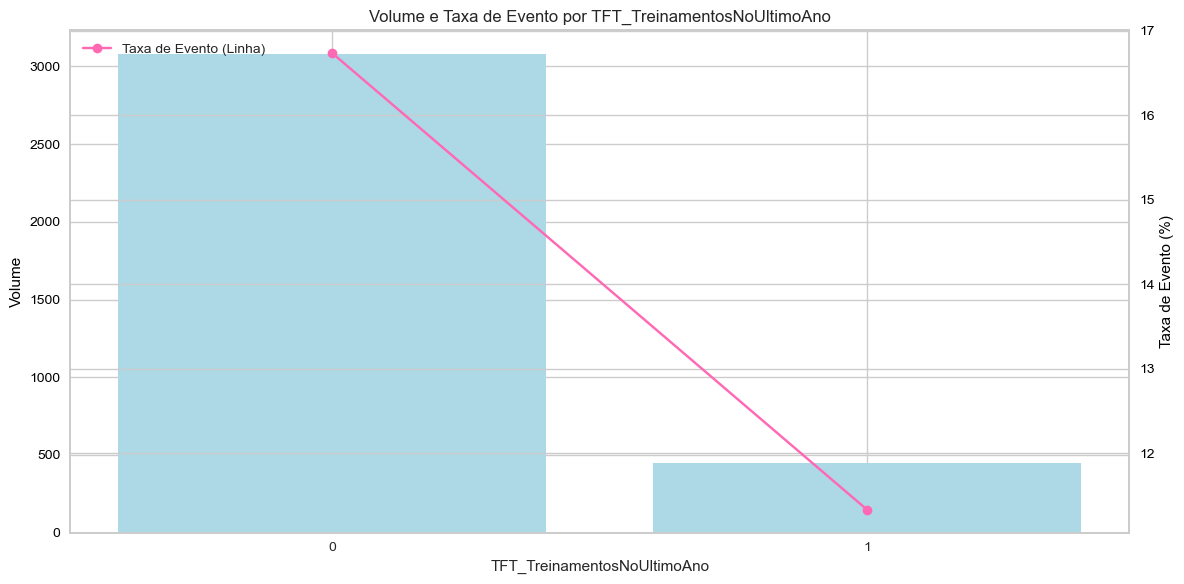

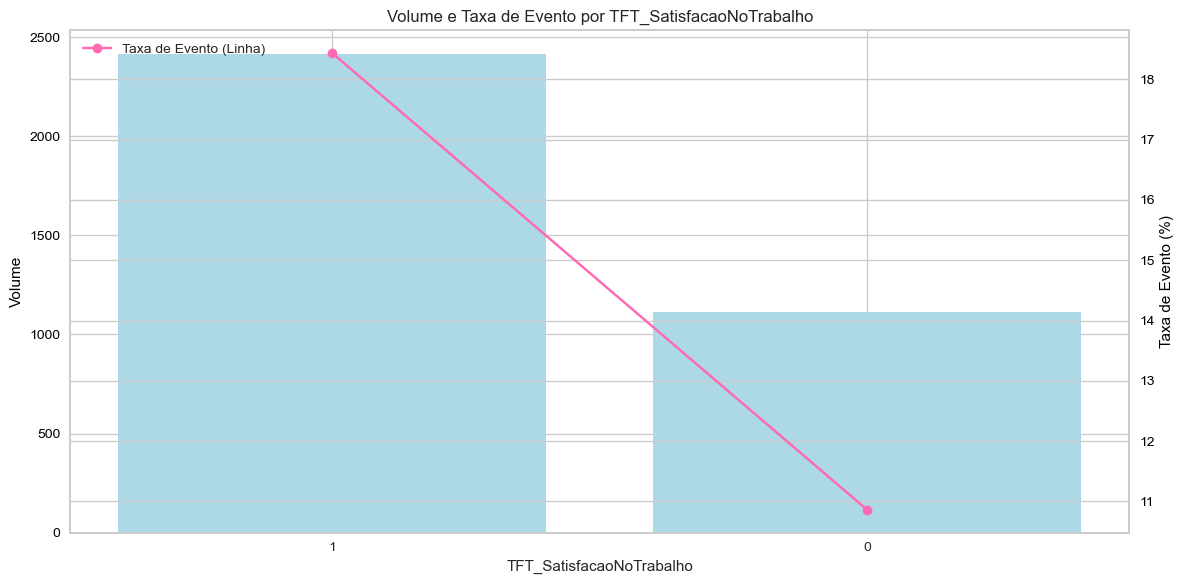

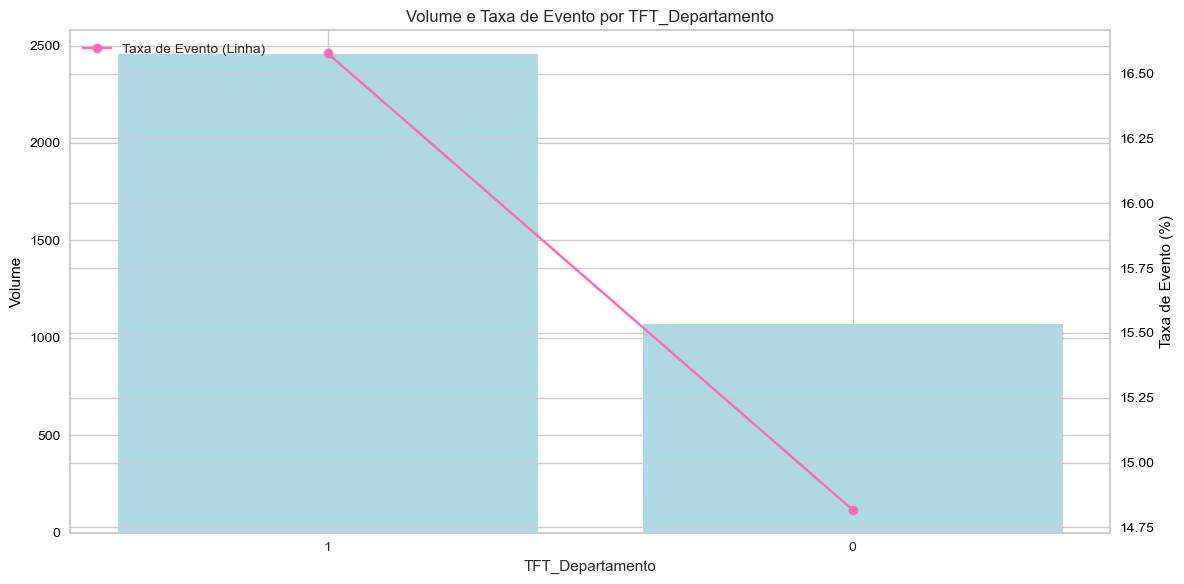

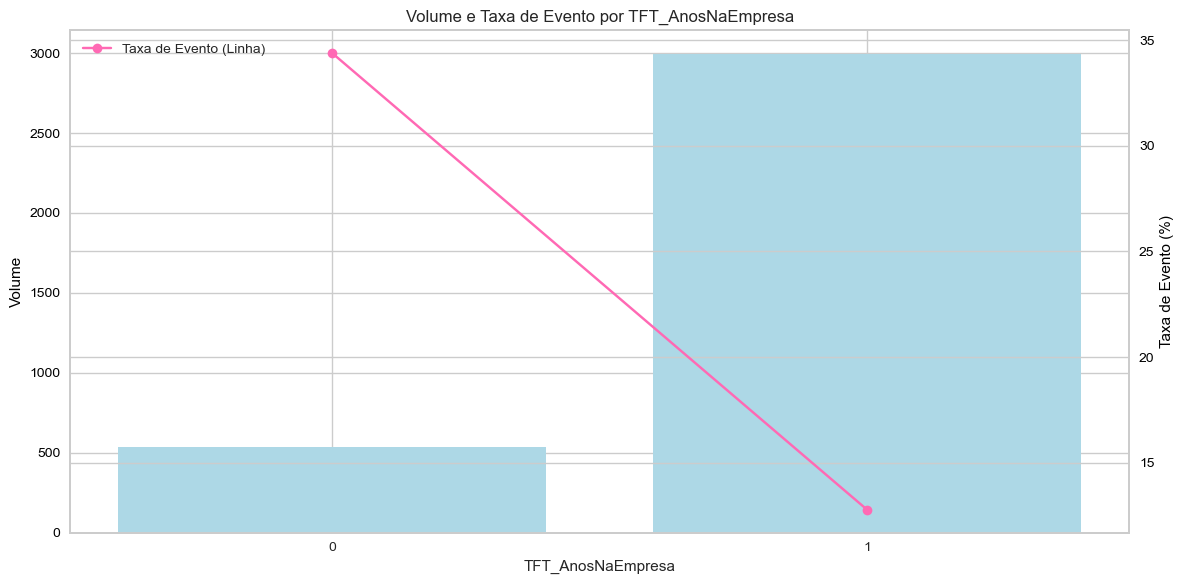

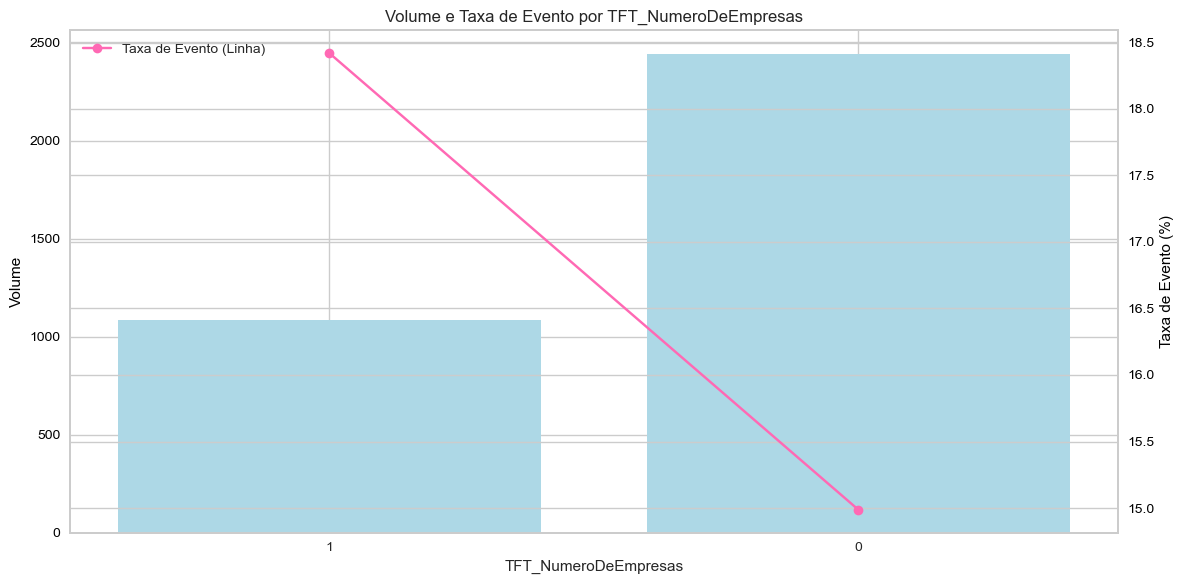

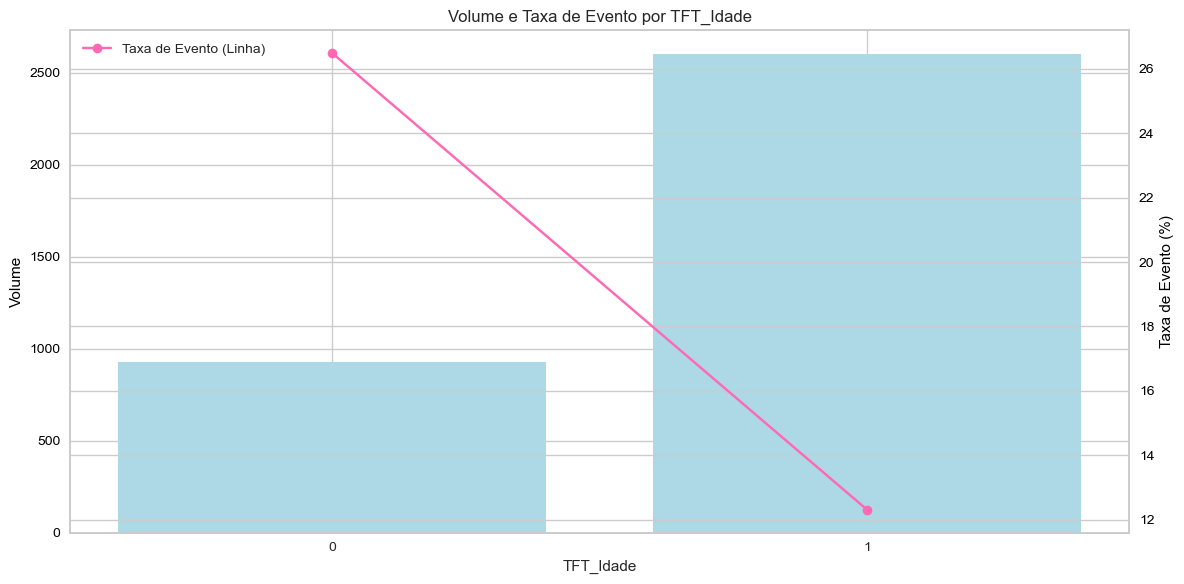

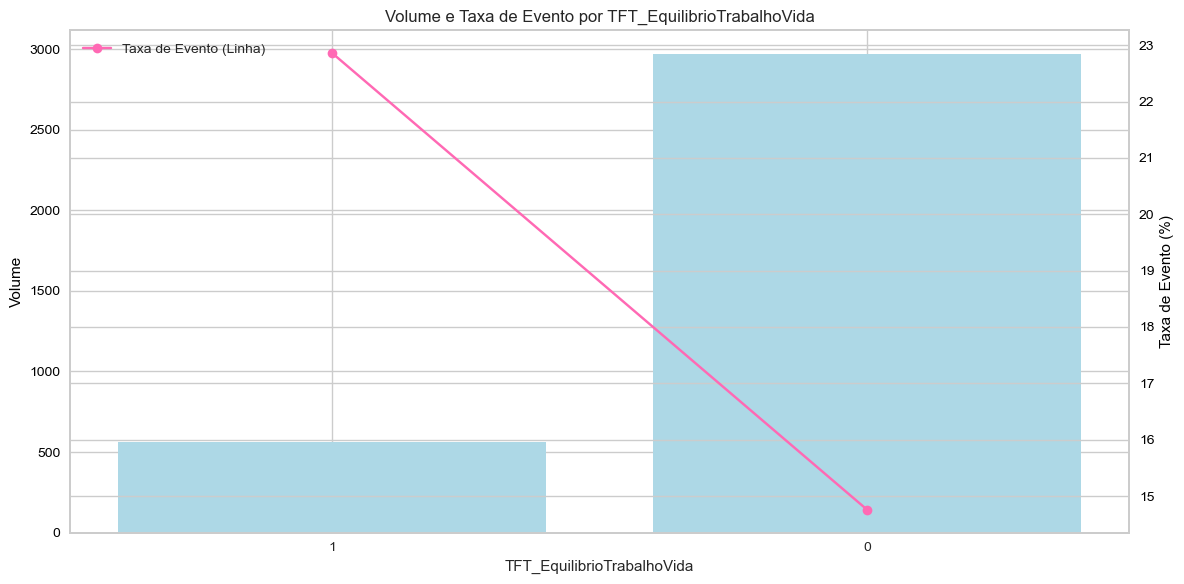

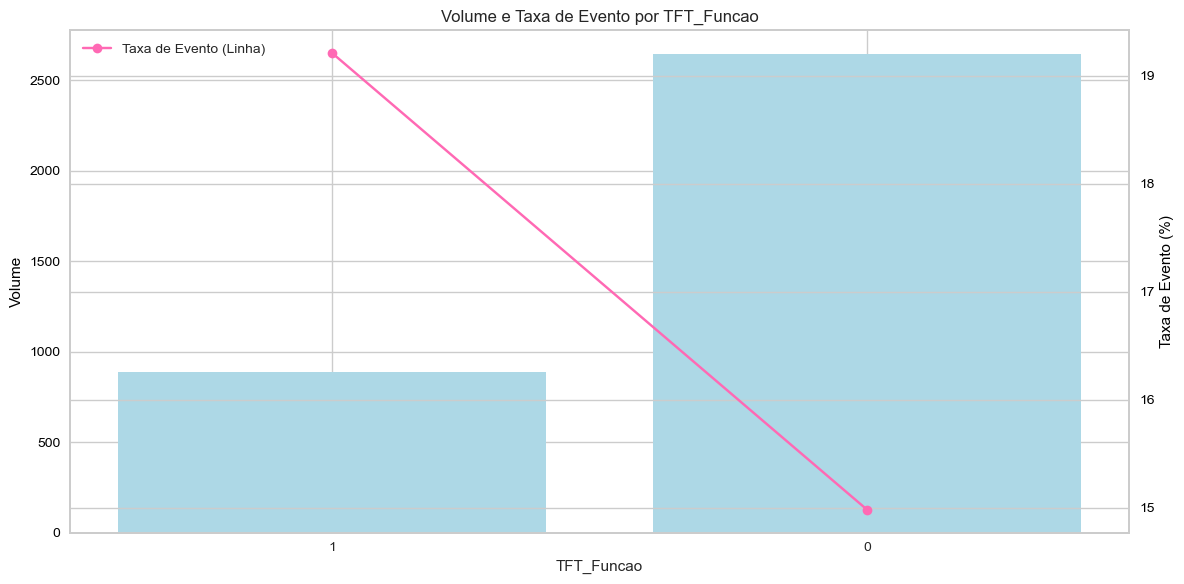

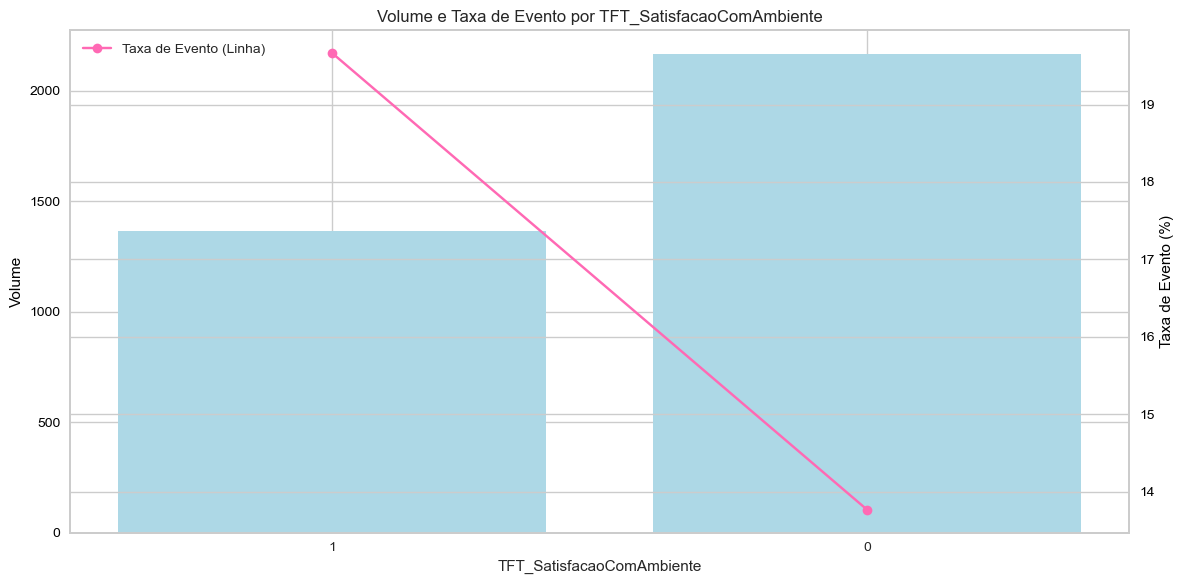

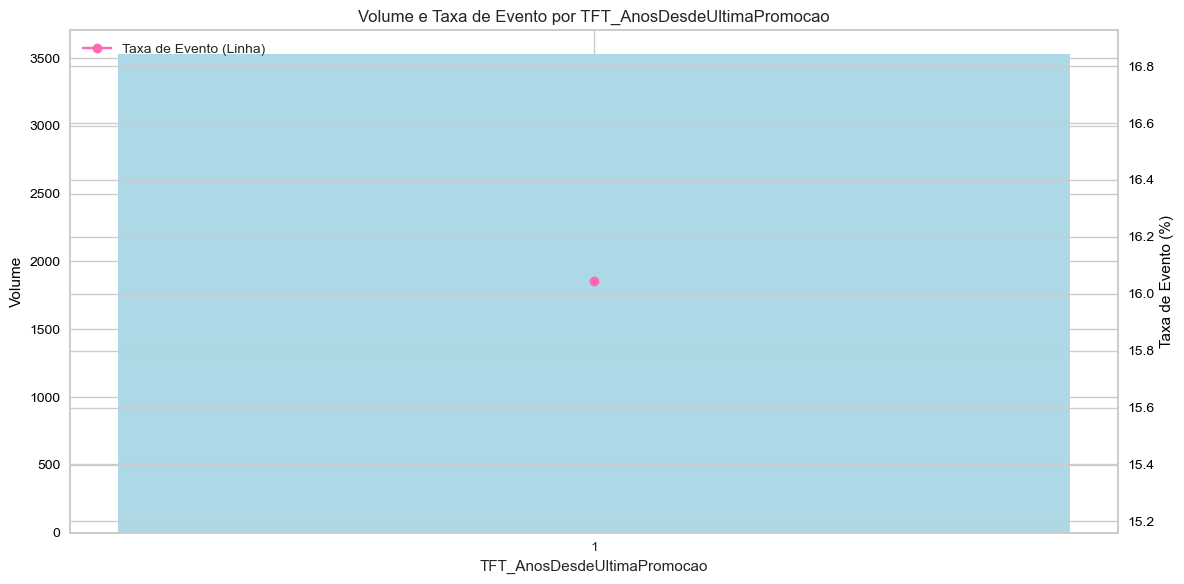

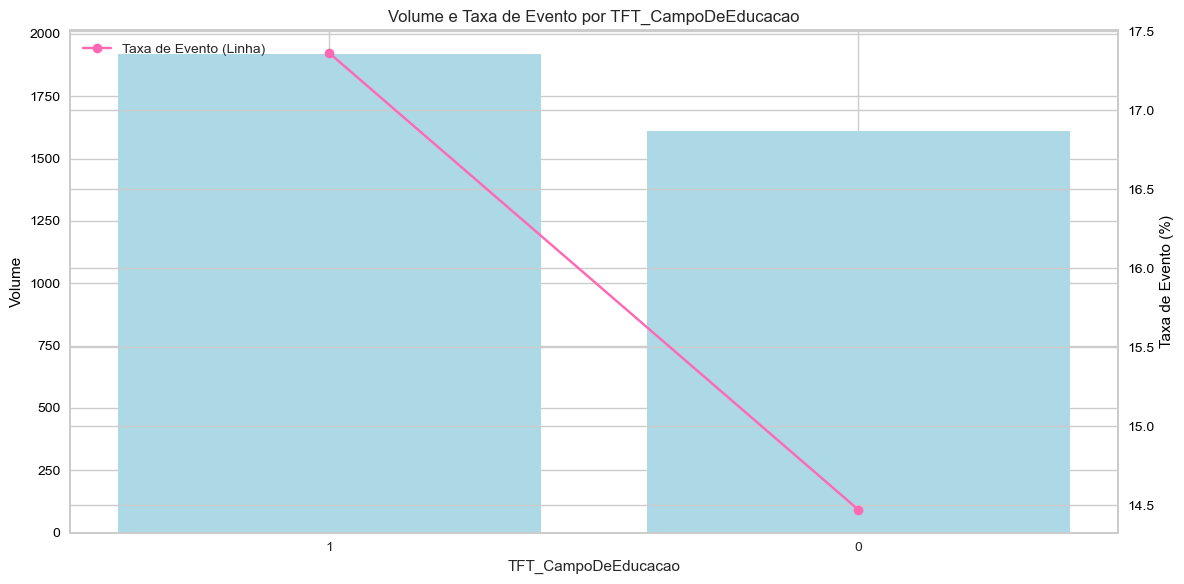

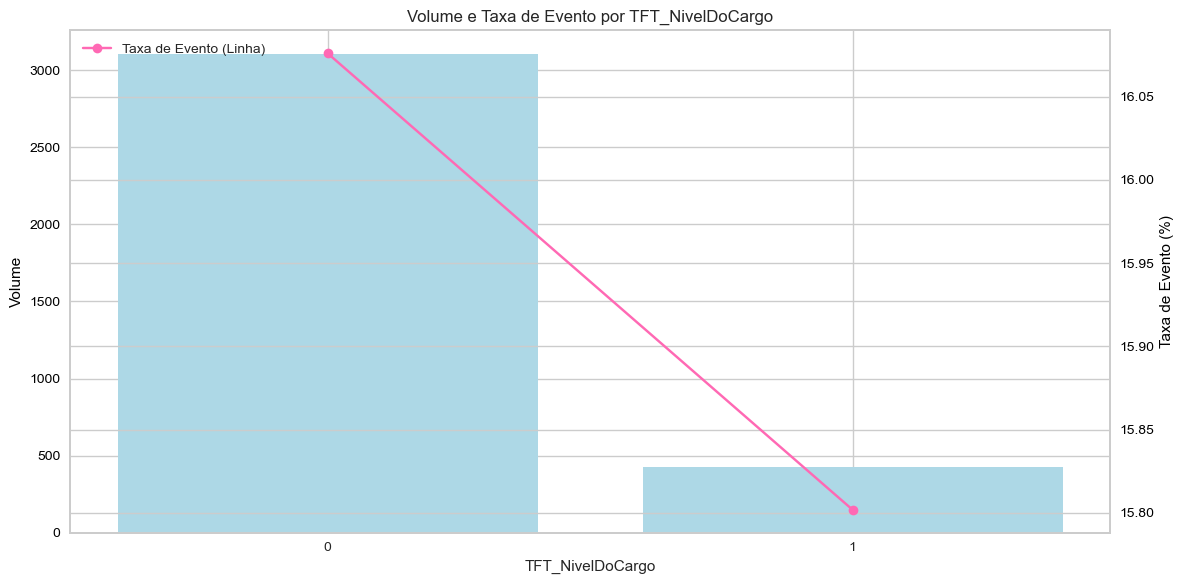

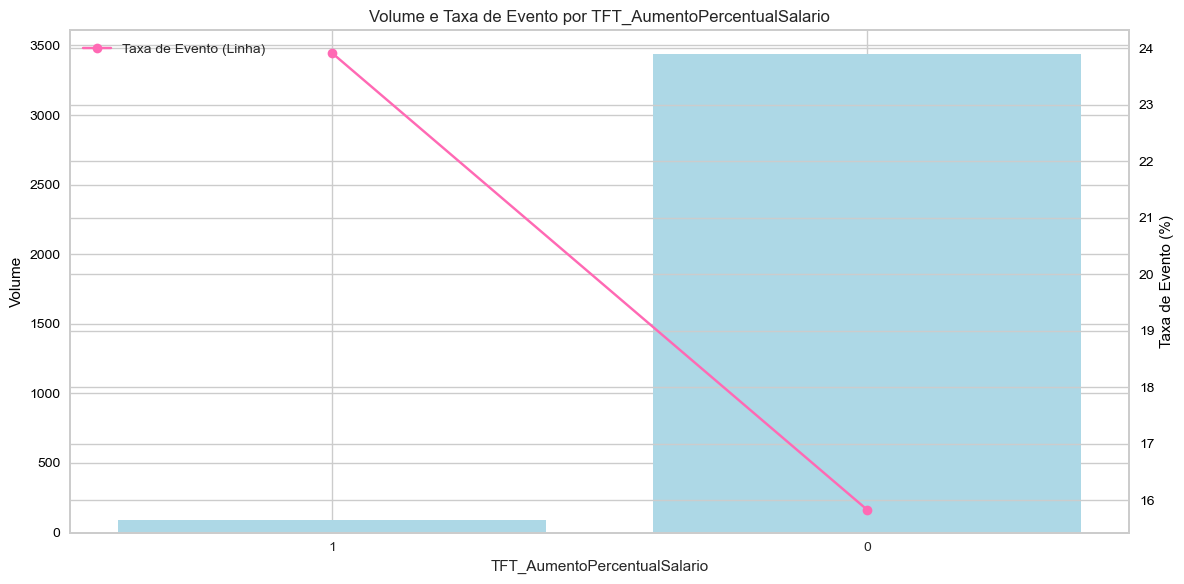

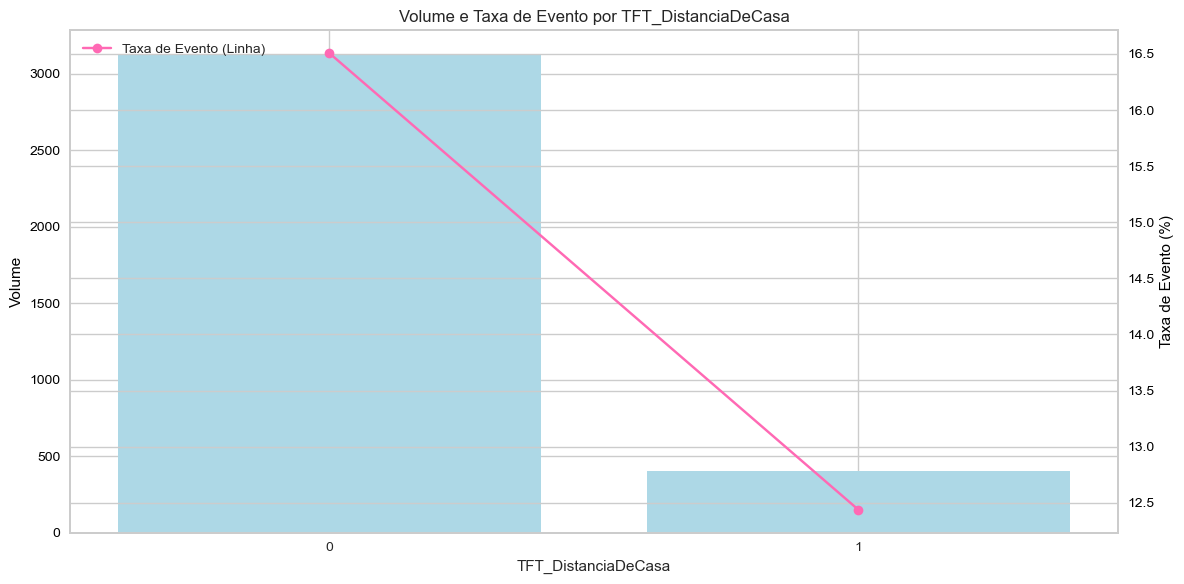

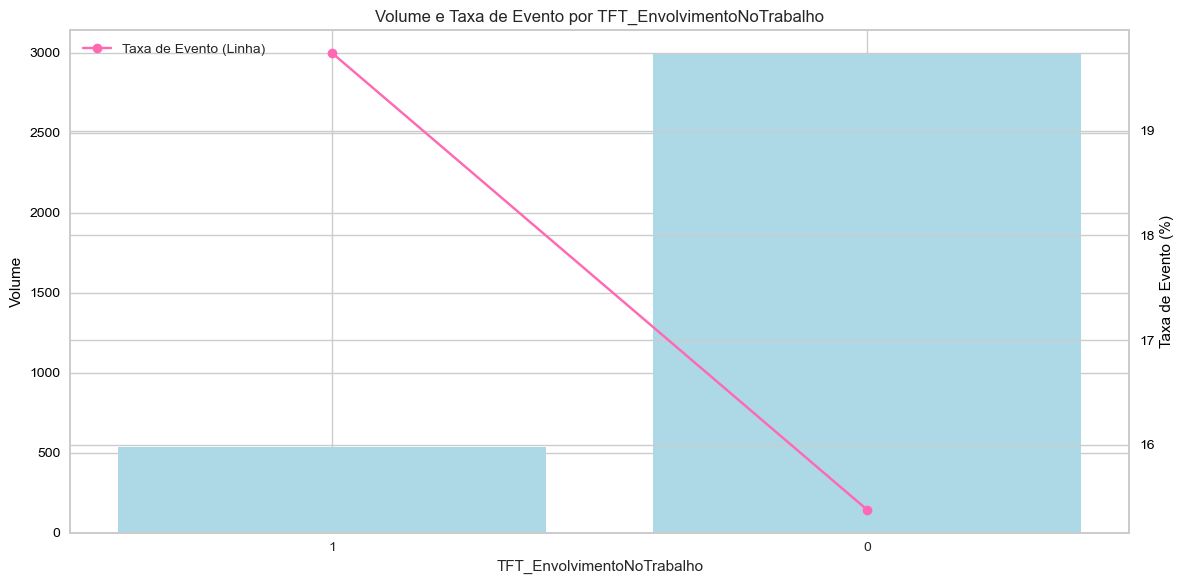

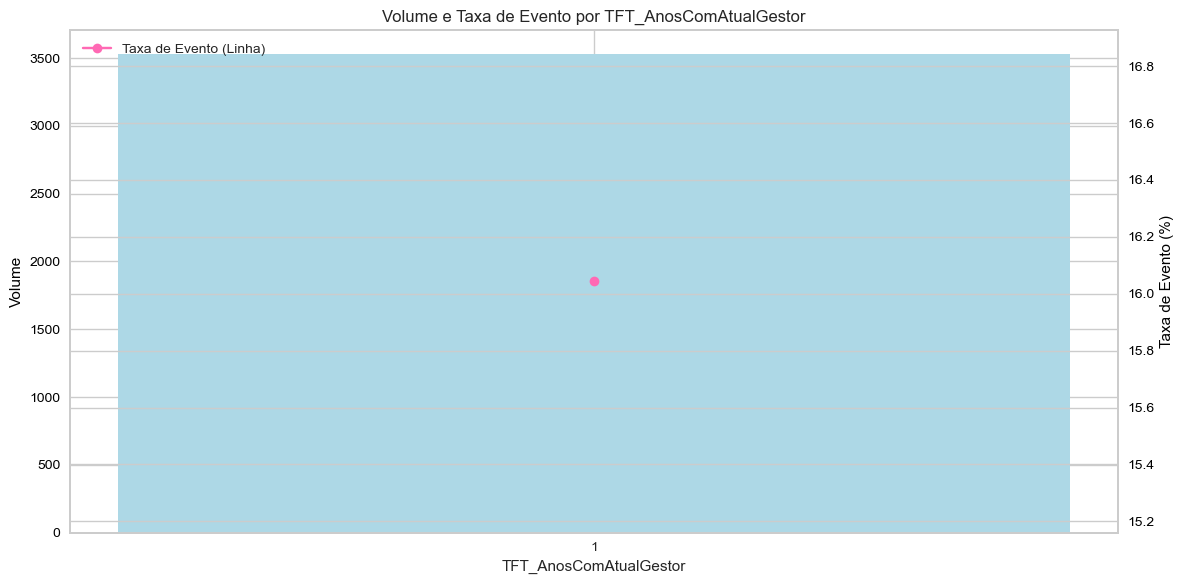

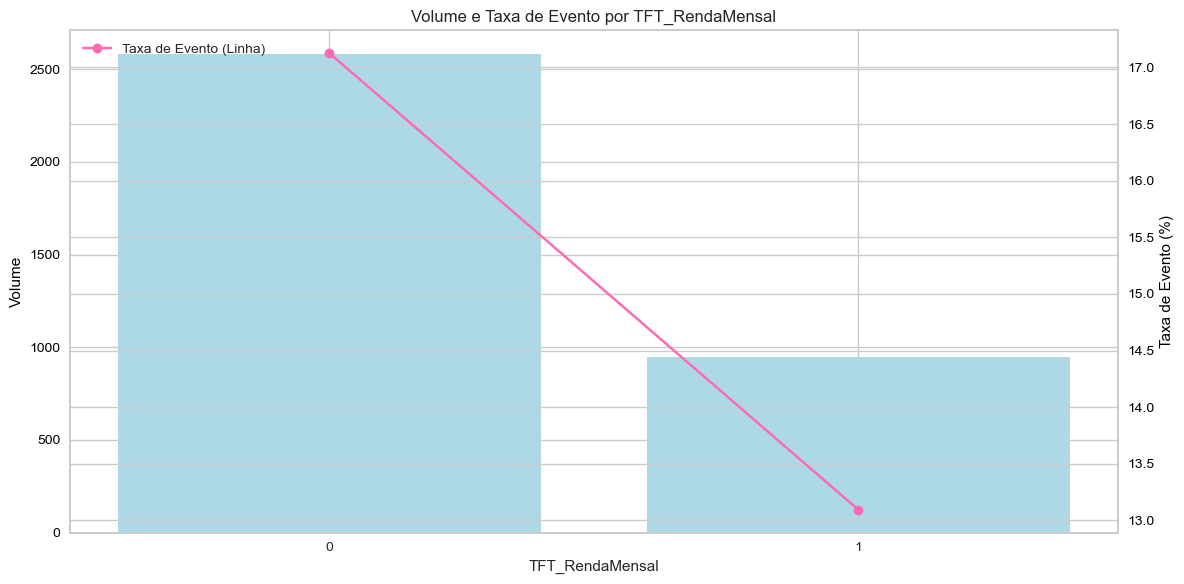

In [80]:
for pos, _ in enumerate(categorize_vars):

    if pos == 0:
        result = categorize_with_decision_tree(
            abt_final_train_transform,
            n_categories= 2,
            target= 'TARGET',
            numeric_var= _
        )

        aux = apply_tree_bins(
            abt_final_train_transform,
            result,
            numeric_var= _
        )

        analyze_variable(
            aux,
            'TFT_'+_,
            'TARGET'
        )

        temp_train = apply_tree_bins(
            abt_final_train_transform,
            result,
            numeric_var= _
        )

        temp_test = apply_tree_bins(
            abt_final_test_transform,
            result,
            numeric_var= _
        )

    else:
        result = categorize_with_decision_tree(
            temp_train,
            n_categories= 2,
            target= 'TARGET',
            numeric_var= _
        )

        aux = apply_tree_bins(
            temp_train,
            result,
            numeric_var= _
        )

        analyze_variable(
            aux,
            'TFT_'+_,
            'TARGET'
        )

        temp_train = apply_tree_bins(
            temp_train,
            result,
            numeric_var= _
        )

        temp_test = apply_tree_bins(
            temp_test,
            result,
            numeric_var= _
        )

In [81]:
from sklearn.preprocessing import OneHotEncoder

onehot_vars = ['TFT_' + var for var in categorize_vars]

for var in onehot_vars:
    temp_train[var] = temp_train[var].astype(float)
    temp_test[var] = temp_test[var].astype(float)


X = temp_train.drop(columns= ['TARGET'])

encoder = OneHotEncoder(
    drop= 'first',
    sparse_output= False,
    handle_unknown= 'ignore',
    dtype= np.int32
)

encoded_data = encoder.fit_transform(temp_train[onehot_vars])
encoded_cols = encoder.get_feature_names_out(onehot_vars)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=temp_train.index)

abt_train_model = pd.concat([temp_train.drop(onehot_vars, axis=1), encoded_df], axis=1)

In [84]:
encoded_data_test = encoder.transform(temp_test[onehot_vars])
encoded_cols_test = encoder.get_feature_names_out(onehot_vars)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=temp_test.index)

abt_test_model = pd.concat([temp_test.drop(onehot_vars, axis=1), encoded_df_test], axis=1)

feature_list = abt_train_model.drop(axis=1,columns=['TARGET']).columns.tolist()

## Aplicando a Regressão Logística

In [99]:
model, scorecard = logistic_regression_with_scorecard(
    abt_train_model,
    'TARGET',
    feature_list
)
scorecard

Optimization terminated successfully.
         Current function value: 0.379262
         Iterations 7


Beta Coefficient  P-Value  Wald Statistic
TFT_Idade_1.0                              -0.8623   0.0000         60.2653
const                                      -2.1993   0.0000         51.9627
TFT_SatisfacaoNoTrabalho_1.0                0.6384   0.0000         29.6256
TFT_TotalDeAnosTrabalhados_1.0             -1.1317   0.0000         25.9691
TFT_EquilibrioTrabalhoVida_1.0              0.6282   0.0000         25.5610
TFT_NumeroDeEmpresas_1.0                    0.5615   0.0000         25.3154
TFT_SatisfacaoComAmbiente_1.0               0.4997   0.0000         24.9078
TFT_EstadoCivil_1.0                         0.6521   0.0000         21.8936
TFT_ViagensDeNegocio_1.0                    1.0022   0.0000         21.7277
TFT_AnosNaEmpresa_1.0                      -0.7267   0.0000         21.6187
TFT_Funcao_1.0                              0.4081   0.0002         13.7831
TFT_TreinamentosNoUltimoAno_1.0            -0.4311   0.0107          6.5075
TFT_EnvolvimentoNoTrabalho_1.0              0.2963   0.0236          5.1272
TFT_CampoDeEducacao_1.0                     0.2136   0.0370          4.3496
TFT_AumentoPercentualSalario_1.0            0.5536   0.0441          4.0512
TFT_RendaMensal_1.0                        -0.2399   0.0448          4.0251
TFT_DistanciaDeCasa_1.0                    -0.2956   0.0834          2.9970
TFT_Departamento_1.0                        0.1939   0.0841          2.9840
TFT_NivelDoCargo_1.0                       -0.1137   0.4624          0.5400

* Como a variável `TFT_NivelDoCargo_1.0` possui um p-valor muito próximo do limiar de rejeição (0.05), vamos remove-lo do modelo.

In [100]:
feature_list_final = pd.DataFrame(scorecard[scorecard['P-Value'] <= 0.035].reset_index()).rename(columns={'index':'variable'}).variable.to_list()

feature_list_final.remove('const')

abt_train_model_final = abt_train_model[feature_list_final]
abt_train_model_final = pd.concat((abt_train_model_final,y_train),axis=1)

abt_test_model_final = abt_test_model[feature_list_final]
abt_test_model_final = pd.concat((abt_test_model_final,y_test),axis=1)

model, scorecard = logistic_regression_with_scorecard(abt_train_model_final, 'TARGET', abt_train_model_final.drop(columns='TARGET').columns.to_list())
scorecard

Optimization terminated successfully.
         Current function value: 0.381790
         Iterations 7


Beta Coefficient  P-Value  Wald Statistic
TFT_Idade_1.0                             -0.8678   0.0000         61.4971
const                                     -2.0381   0.0000         52.7208
TFT_SatisfacaoNoTrabalho_1.0               0.6143   0.0000         27.7671
TFT_NumeroDeEmpresas_1.0                   0.5834   0.0000         27.6135
TFT_TotalDeAnosTrabalhados_1.0            -1.1601   0.0000         27.4965
TFT_EquilibrioTrabalhoVida_1.0             0.6341   0.0000         26.3695
TFT_EstadoCivil_1.0                        0.6838   0.0000         24.2913
TFT_SatisfacaoComAmbiente_1.0              0.4889   0.0000         24.0482
TFT_ViagensDeNegocio_1.0                   1.0288   0.0000         23.2555
TFT_AnosNaEmpresa_1.0                     -0.7155   0.0000         21.1412
TFT_Funcao_1.0                             0.3972   0.0003         13.1782
TFT_TreinamentosNoUltimoAno_1.0           -0.4359   0.0095          6.7223
TFT_EnvolvimentoNoTrabalho_1.0             0.2822   0.0308          4.6624

In [102]:
abt_train_model_final = abt_train_model_final.drop(columns='TARGET').copy()
abt_test_model_final = abt_test_model_final.drop(columns='TARGET').copy()

abt_train_model_final['const'] = 1.0
abt_test_model_final['const'] = 1.0

abt_train_model_final['Score_1'] = model.predict(abt_train_model_final).round(4)
abt_test_model_final['Score_1'] = model.predict(abt_test_model_final).round(4)

abt_train_model_final['Score_0'] = 1 - abt_train_model_final['Score_1']
abt_test_model_final['Score_0'] = 1 - abt_test_model_final['Score_1']

abt_train_model_final = pd.concat((abt_train_model_final,y_train),axis=1)
abt_test_model_final = pd.concat((abt_test_model_final,y_test),axis=1)

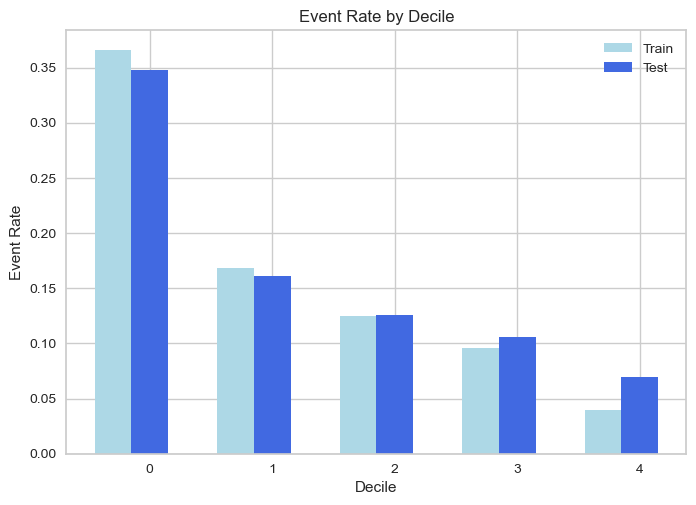

In [109]:
metrics, ord_score_train, ord_score_test = calculate_metrics(
    train_df= abt_train_model_final,
    test_df= abt_test_model_final,
    score_0= 'Score_0',
    score_column= 'Score_1',
    target_column= 'TARGET',
    bins= 5
)

In [108]:
metrics

Metric  Train Value  Test Value
0     KS       0.3393      0.2757
1    AUC       0.7356      0.6871
2   Gini       0.4712      0.3742